In [3]:
# this one uses 3*3 size filters
import numpy as np
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import time


Visualize Image

Image resolution: 1280 x 720
Image resolution: 1280 x 720


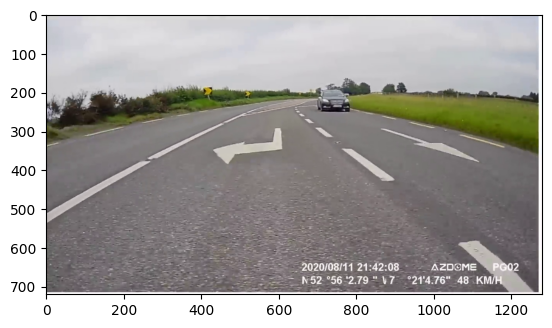

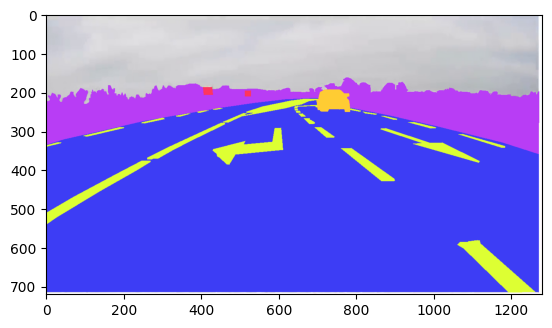

In [4]:
# Libraries you already have
import matplotlib.pyplot as plt
from PIL import Image

# Define the image path (replace with your actual working directory)
image_path = "/kaggle/input/roads-segmentation-dataset/images/0.png"
o_image_path = "/kaggle/input/roads-segmentation-dataset/masks/0.png"

# Read the image using PIL
img = Image.open(image_path)
o_img= Image.open(o_image_path)
width, height = img.size
print(f"Image resolution: {width} x {height}")
o_width, o_height = o_img.size
print(f"Image resolution: {o_width} x {o_height}")
# Display the image using matplotlib
plt.imshow(img)
plt.show()
plt.imshow(o_img)
plt.show()

In [5]:
#create list of images with and masks
images_path =  '/kaggle/input/roads-segmentation-dataset/images'
masks_path = '/kaggle/input/roads-segmentation-dataset/masks'

#loop over all the images in folders and create one to one mapping of images and masks
# {image:"path", mask:"path"}
image_paths = {}
mask_paths = {}
for item in os.listdir(images_path):
    item_path = os.path.join(images_path, item)
    filename = os.path.basename(item_path)
    file_stem = os.path.splitext(filename)[0]
    image_paths[int(file_stem)] = item_path

for item in os.listdir(masks_path):
    item_path = os.path.join(masks_path, item)
    filename = os.path.basename(item_path)
    file_stem = os.path.splitext(filename)[0]
    mask_paths[int(file_stem)] = item_path
print(image_paths[0])
print(mask_paths[0])

/kaggle/input/roads-segmentation-dataset/images/0.png
/kaggle/input/roads-segmentation-dataset/masks/0.png


In [6]:
color_map = {
    (61, 61, 245): 0,      # 3d3df5: Class 0 (e.g., road_surface)
    (221,255,51): 1,      # ddff33: Class 1 (e.g., marking)
    (255,204,51): 2,      # ffcc33: Class 2 (e.g., car)
    (255,53,94): 3,    # ff355e: Class 3 (e.g., road_sign)
    (184,61,245): 4           # b83df5: class 4 (e.g., background)
}

In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, transform=None):
        #data loading
        self.x = image_paths
        self.y = mask_paths
        self.n_samples = len(image_paths)
        self.transform = transform
    def __getitem__(self, index):
        #dataset[0] image data
        image = Image.open(self.x[index]).convert("RGB")
        mask = Image.open(self.y[index]).convert("RGB")
        mask = np.array(mask)
        mask = self.rgb_to_onehot(mask, color_map)
        #print("size:",mask.shape)
        if (self.transform):
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask
        
    def __len__(self):
        # len(dataset)
        return self.n_samples
    #one hot encoding
    def rgb_to_onehot(self, rgb_image, color_map):
        """Converts an RGB image to a one-hot encoded image using a color map."""
        height, width, _ = rgb_image.shape
        #print("hw",_,height,width)
        num_classes = len(color_map)
        onehot_image = np.zeros((height, width, num_classes), dtype=np.float32) # changed to float32
        for h in range(height):
            for w in range(width):
                rgb = tuple(rgb_image[h, w])
                #print("rgb:",rgb)
                if rgb in color_map:
                    class_index = color_map[rgb]
                    onehot_image[h, w, class_index] = 1
                else:
                    # Handle unknown colors (e.g., set to background or raise an error)
                    #print(f"Warning: RGB color {rgb} not found in color map. Setting to background (index 4).")
                    onehot_image[h, w, 4] = 1  # Set to background class
        return onehot_image
print("declared")

declared


In [8]:
dataset = SegmentationDataset(transform=transforms.ToTensor())
first_data = dataset[0]
features, labels = first_data
print(type(features), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [9]:
start_time = time.time()
#device
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
#hyperparameters

batch_size = 4


dataset = SegmentationDataset(transform=transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=4, shuffle=True, num_workers=2)

train_loader=torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

print(train_loader)
examples = iter(train_loader)
print(examples)
samples, labels = next(examples)

print("Printing samples and shape")
print(samples.shape, labels.shape)

Printing samples and shape
torch.Size([4, 3, 720, 1280]) torch.Size([4, 5, 720, 1280])


In [23]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.ds_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.ds_pool1 = nn.MaxPool2d(2, stride=2)

        self.ds_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.ds_pool2 = nn.MaxPool2d(2, stride=2)

        self.us_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.us_upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.us_conv2 = nn.Conv2d(16, 5, kernel_size=3, padding=1)  # Output 5 channels
        self.us_upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Downsampling
        x = self.ds_pool1(F.relu(self.ds_conv1(x)))
        x = self.ds_pool2(F.relu(self.ds_conv2(x)))

        # Upsampling
        x = self.us_upsample1(F.relu(self.us_conv1(x)))
        x = self.us_upsample2(F.relu(self.us_conv2(x)))

        # x = torch.sigmoid(x) # no need of sigmoid CrossEntropyLoss applies it

        return x

In [24]:
learning_rate = 0.01
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
print(model.parameters())
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
n_total_steps = len(train_loader)

<generator object Module.parameters at 0x78d5448a8970>


In [16]:
def index_to_rgb(outputs, color_map):
    """Converts a model output tensor (class indices) to RGB images.

    Args:
        outputs (torch.Tensor): The model output tensor of shape (batch_size, num_classes, H, W).
        color_map (dict): A dictionary mapping RGB tuples to class indices.

    Returns:
        torch.Tensor: A tensor of shape (batch_size, 3, H, W) representing the RGB images, or None if there's an issue.
    """
    if not isinstance(outputs, torch.Tensor):
      print("outputs is not a tensor")
      return None
    if not isinstance(color_map, dict):
      print("color_map is not a dict")
      return None
    if len(outputs.shape)!=4:
      print("output shape is not correct")
      return None
    try:
        batch_size, num_classes, h, w = outputs.shape
    except ValueError:
        print("Invalid output shape. Expected (batch_size, num_classes, H, W).")
        return None

    color_map_expanded = list(color_map.items()) # Convert to list for indexing

    rgb_images = torch.zeros((batch_size, 3, h, w), dtype=torch.uint8, device=outputs.device)

    predicted_indices = torch.argmax(outputs, dim=1)  # Shape: (batch_size, H, W)

    for b in range(batch_size):
        for c, (color, index) in enumerate(color_map_expanded):
            mask = predicted_indices[b] == index
            rgb_images[b, :, mask] = torch.tensor(color, dtype=torch.uint8, device=outputs.device).view(3, 1)

    return rgb_images

def display_tensor_image(tensor):
    """Displays a PyTorch tensor as an image using matplotlib."""
    # Check if the tensor is on the GPU and move to CPU if necessary
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # If it's a batch of images, display the first one
    if tensor.ndim == 4:
        tensor = tensor[0]  # Take the first image in the batch

    # If it has a channel dimension, permute it to (H, W, C)
    if tensor.ndim == 3:
      if tensor.shape[0] == 3:
        tensor = tensor.permute(1, 2, 0)

    # Convert to NumPy array and ensure correct data type
    img = tensor.numpy().astype(np.uint8)

    # Display the image using matplotlib
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

device cuda


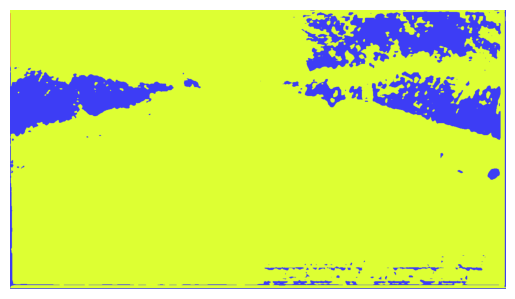

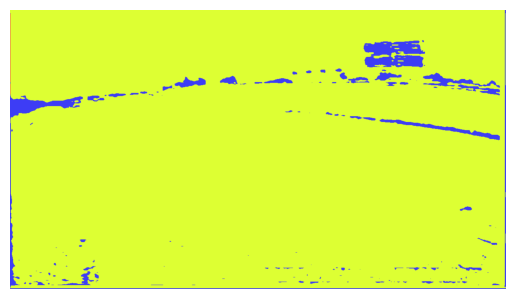

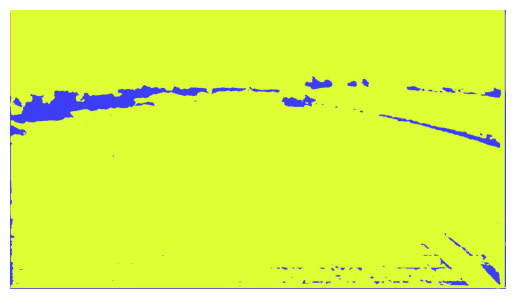

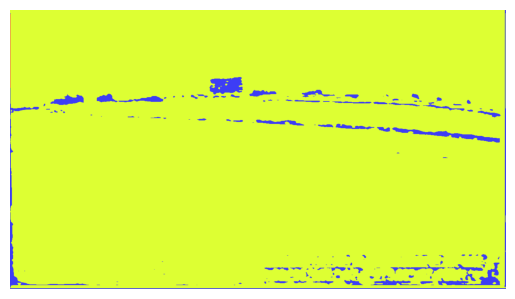

This is epoch 1/20, step 1/8, loss = 1.6062


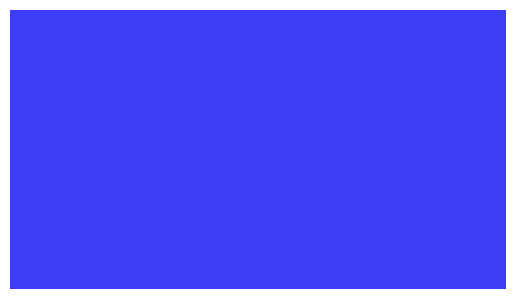

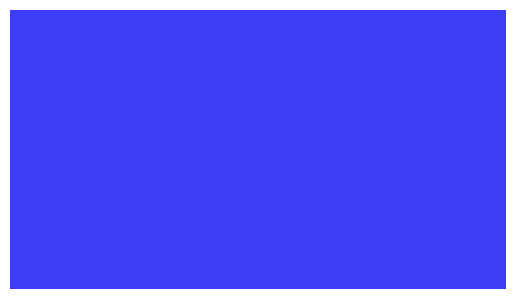

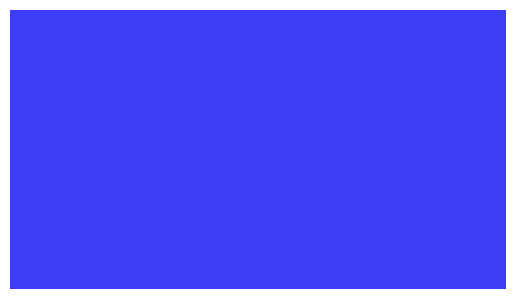

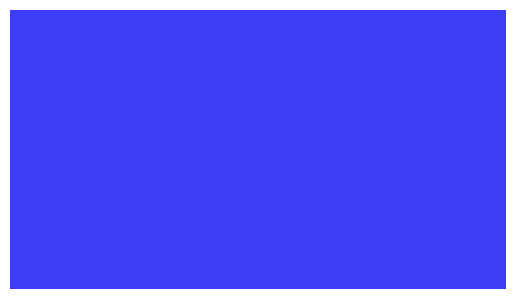

This is epoch 1/20, step 2/8, loss = 1.4721


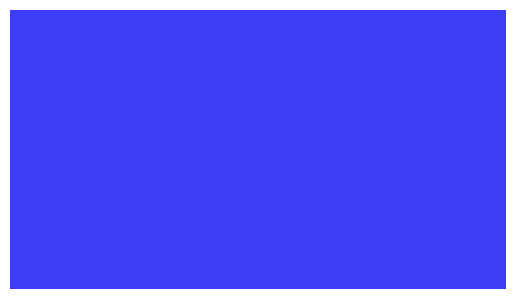

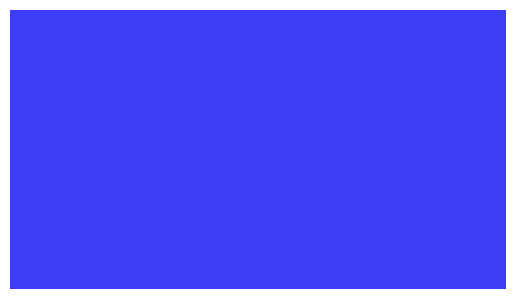

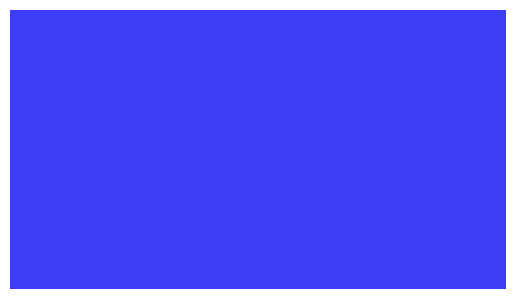

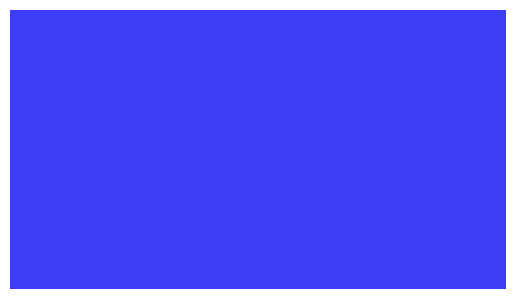

This is epoch 1/20, step 3/8, loss = 1.4716


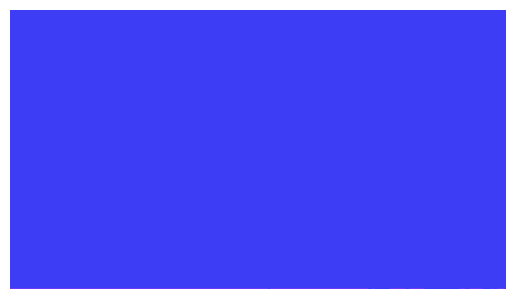

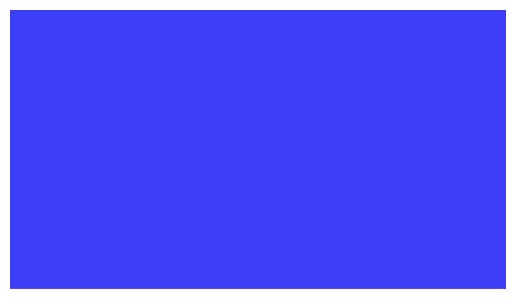

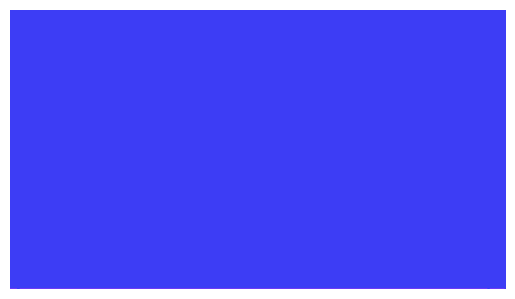

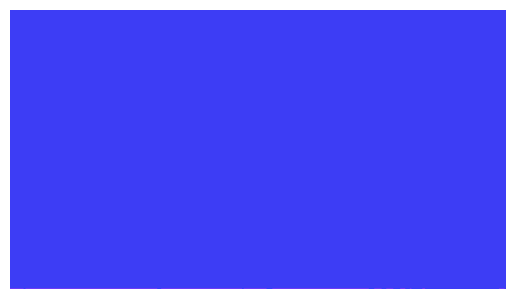

This is epoch 1/20, step 4/8, loss = 1.1832


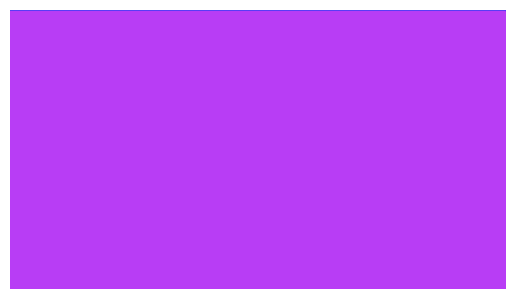

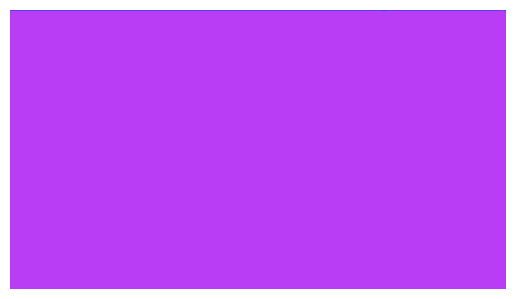

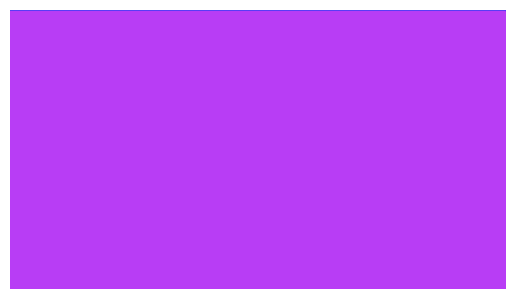

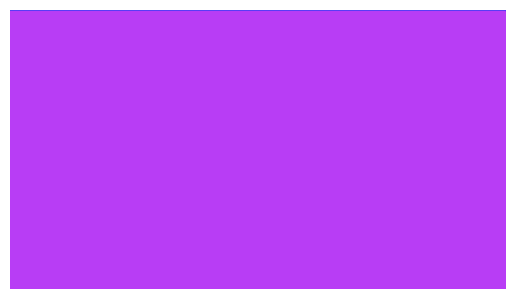

This is epoch 1/20, step 5/8, loss = 1.1049


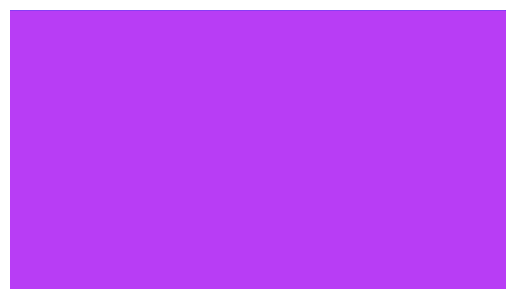

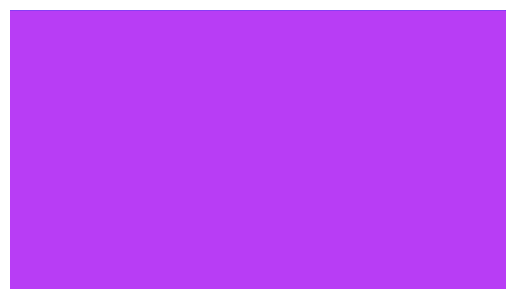

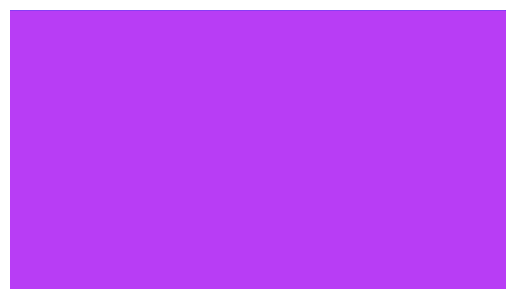

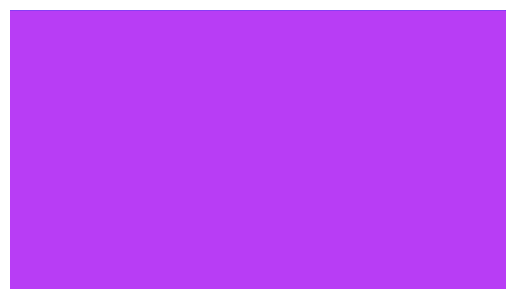

This is epoch 1/20, step 6/8, loss = 1.0066


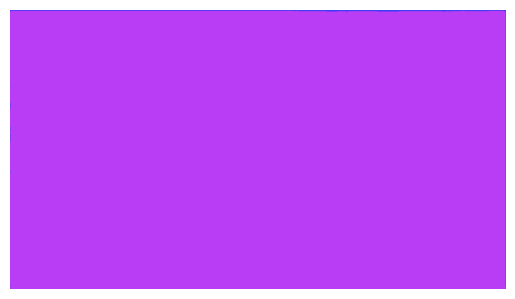

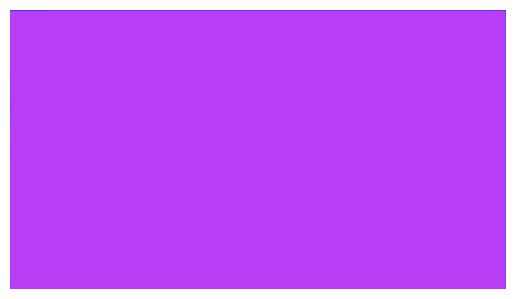

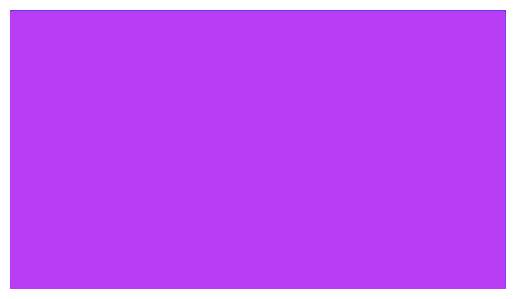

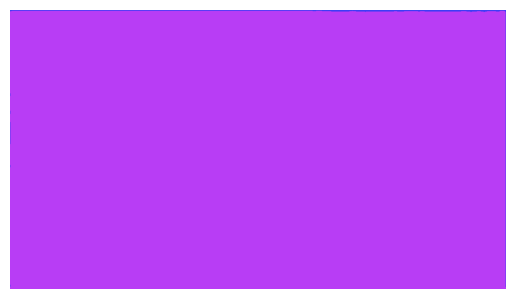

This is epoch 1/20, step 7/8, loss = 0.8377


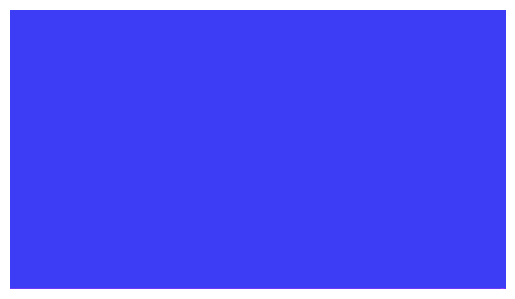

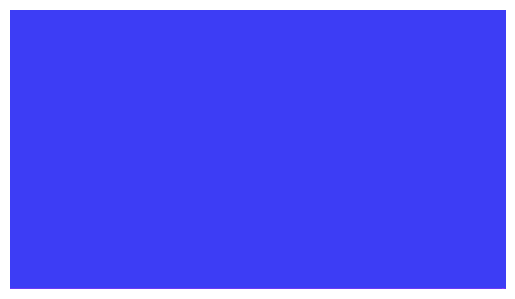

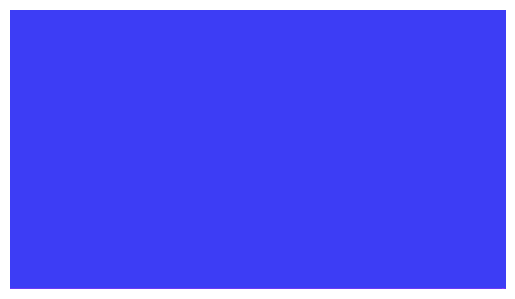

This is epoch 1/20, step 8/8, loss = 0.9312


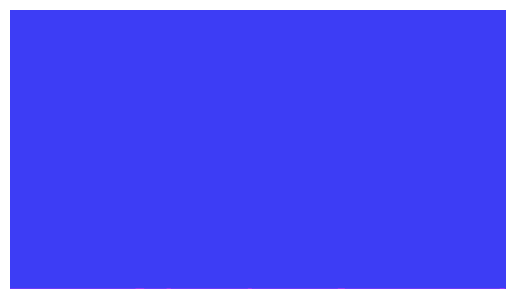

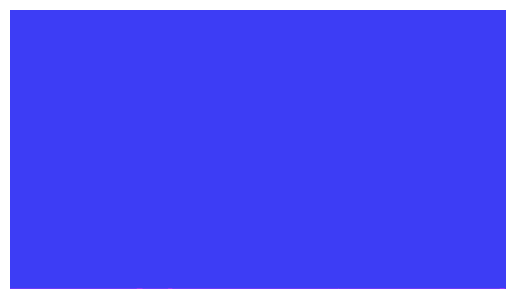

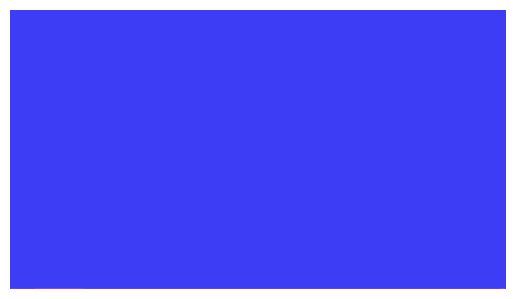

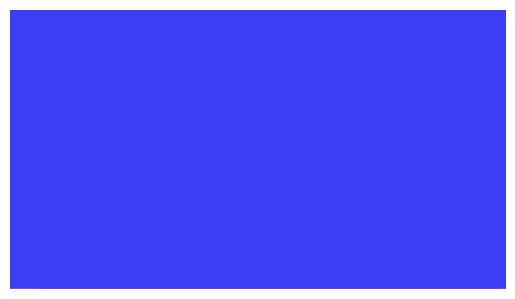

This is epoch 2/20, step 1/8, loss = 0.8732


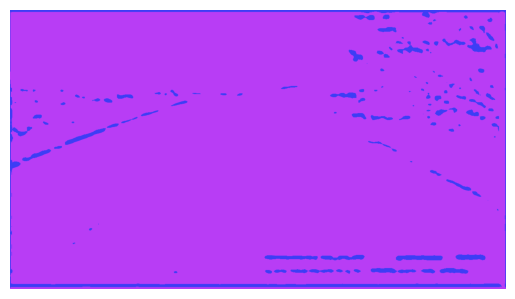

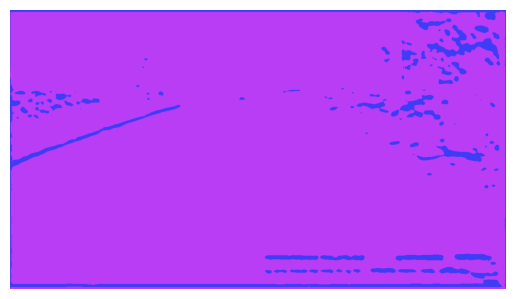

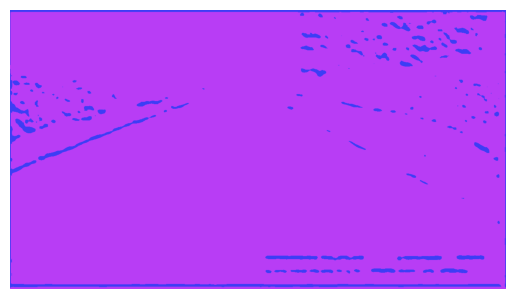

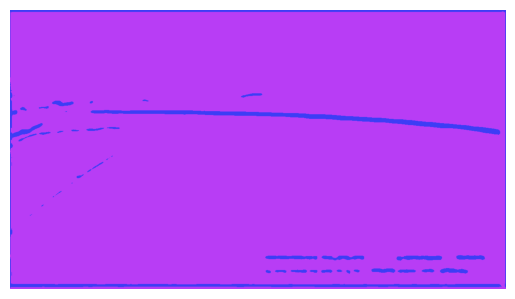

This is epoch 2/20, step 2/8, loss = 0.7768


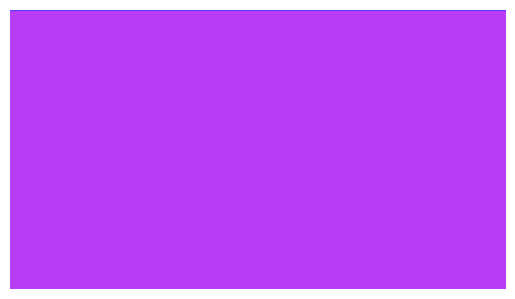

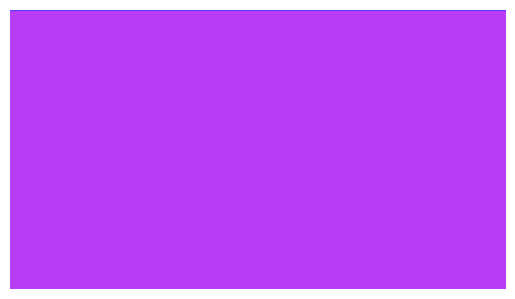

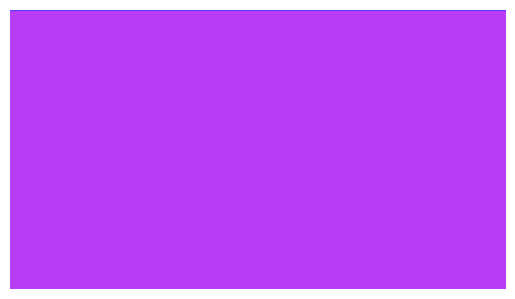

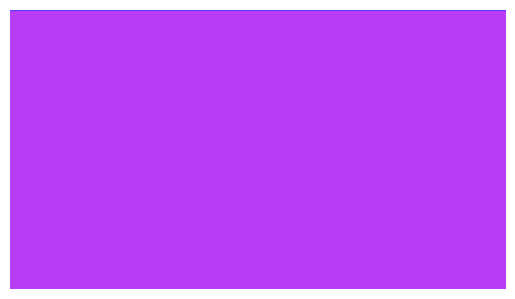

This is epoch 2/20, step 3/8, loss = 0.9745


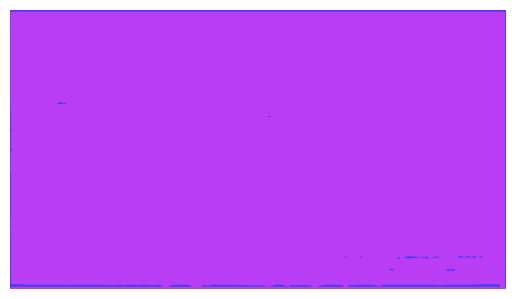

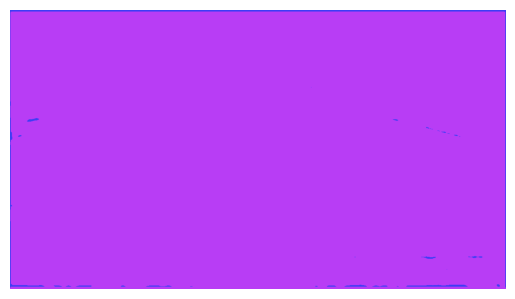

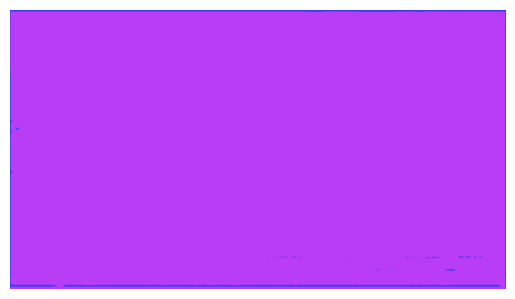

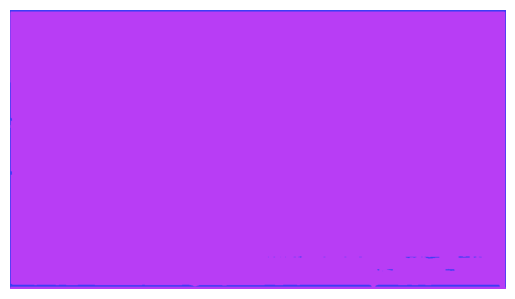

This is epoch 2/20, step 4/8, loss = 0.8085


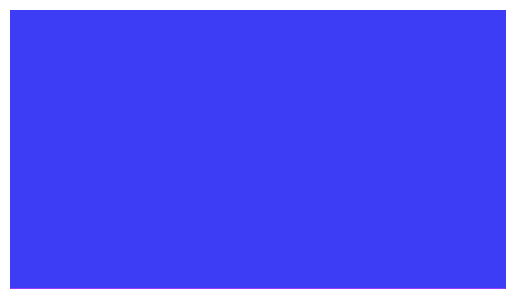

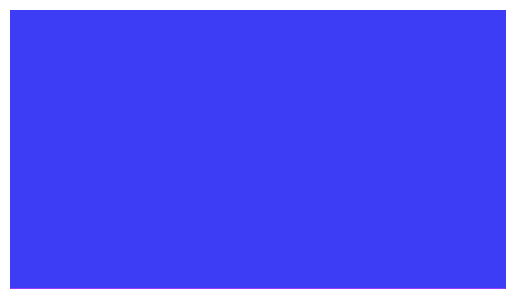

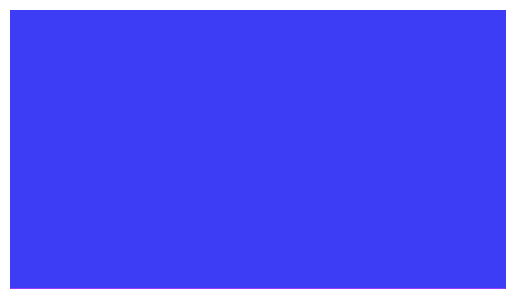

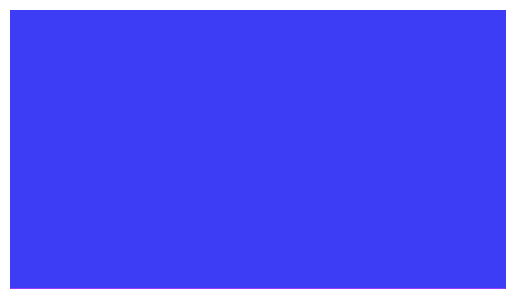

This is epoch 2/20, step 5/8, loss = 0.8044


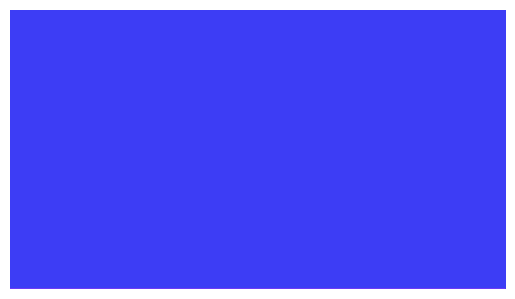

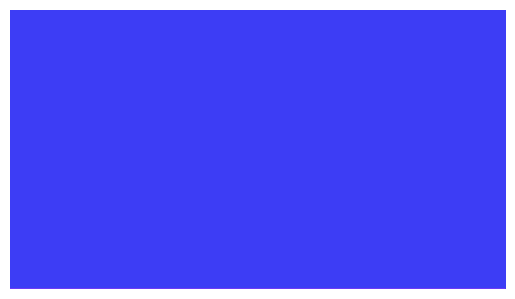

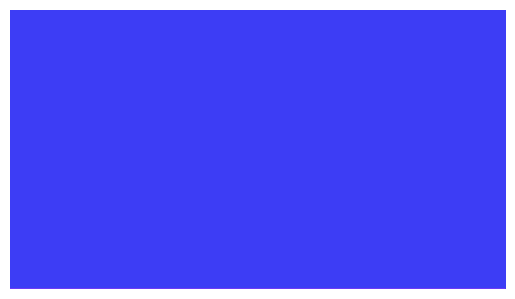

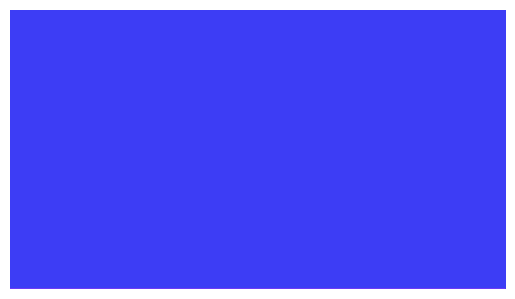

This is epoch 2/20, step 6/8, loss = 0.9242


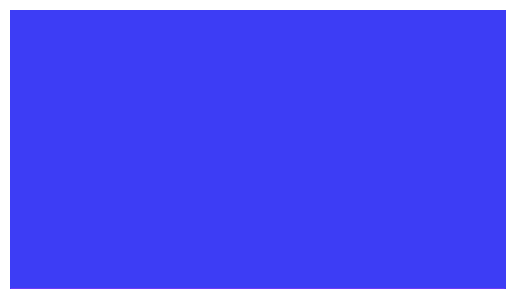

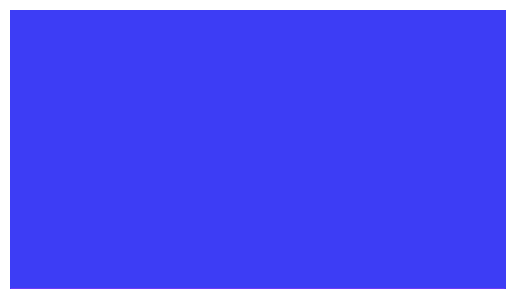

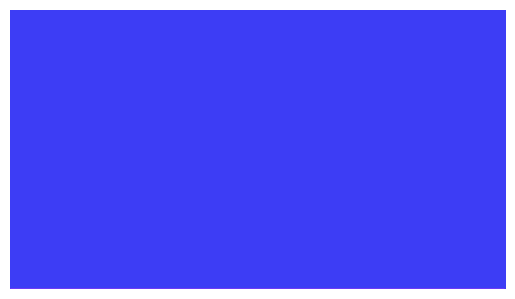

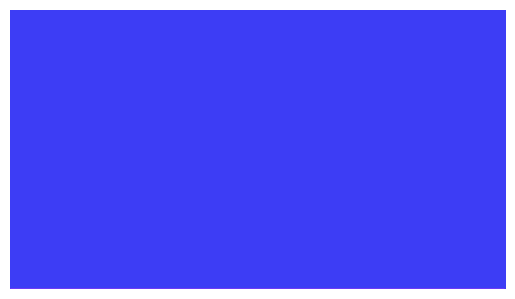

This is epoch 2/20, step 7/8, loss = 0.8712


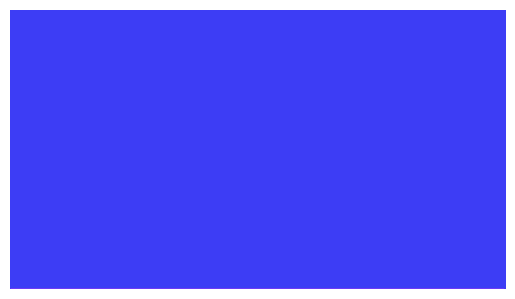

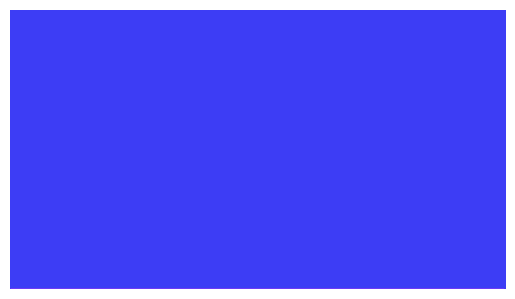

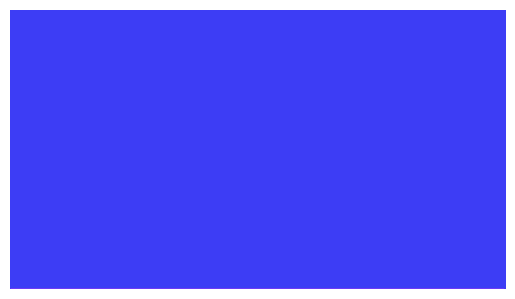

This is epoch 2/20, step 8/8, loss = 0.8033


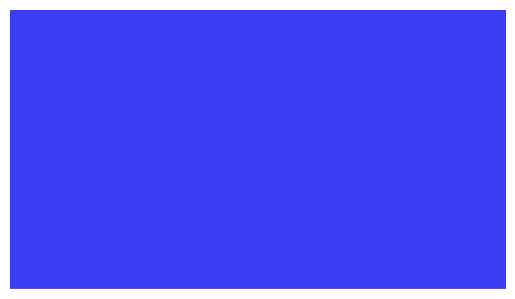

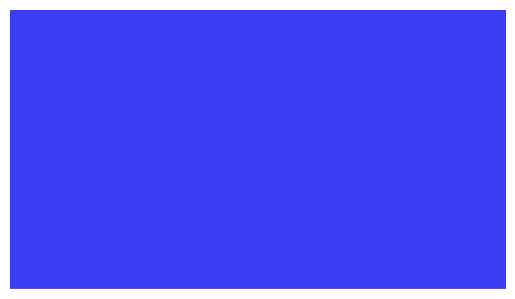

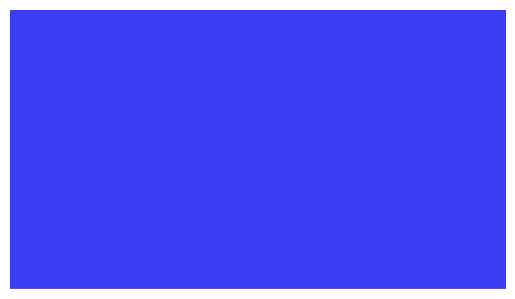

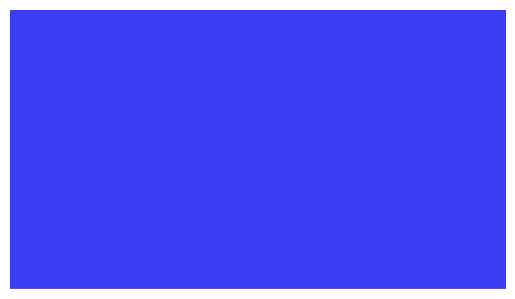

This is epoch 3/20, step 1/8, loss = 0.8291


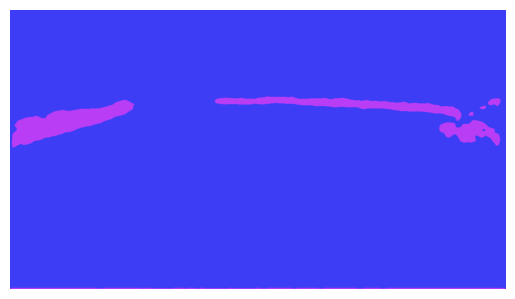

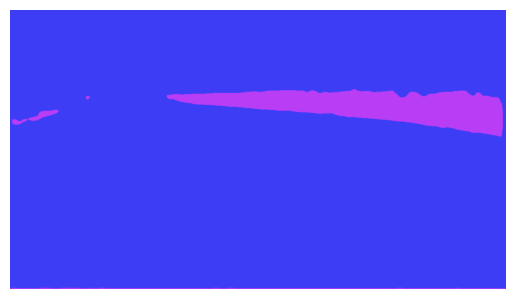

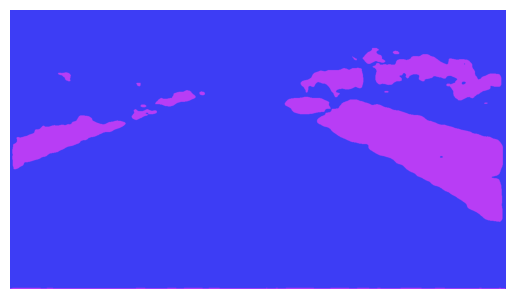

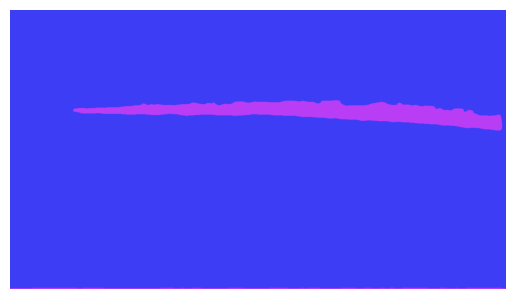

This is epoch 3/20, step 2/8, loss = 0.8051


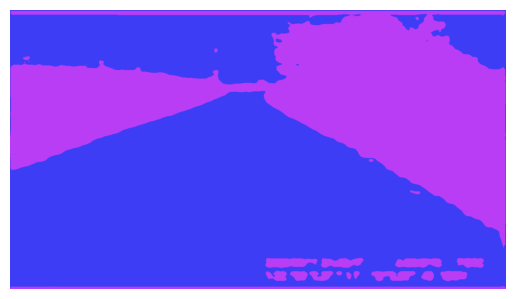

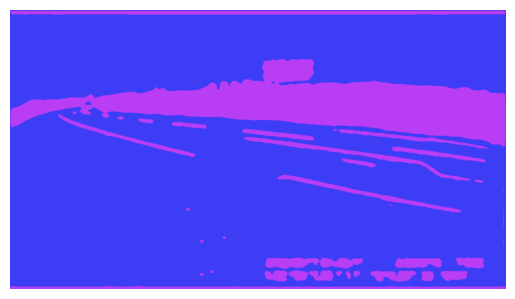

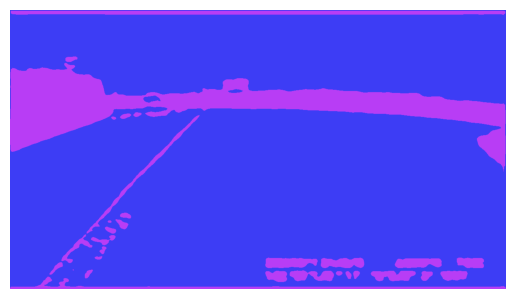

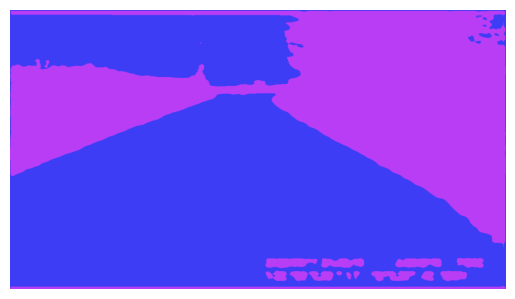

This is epoch 3/20, step 3/8, loss = 0.7469


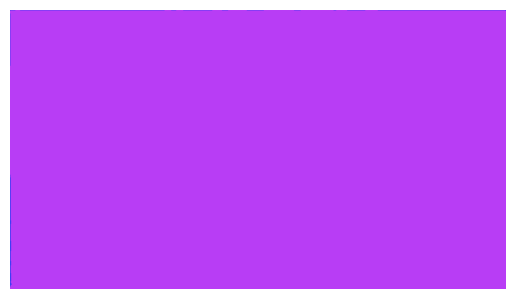

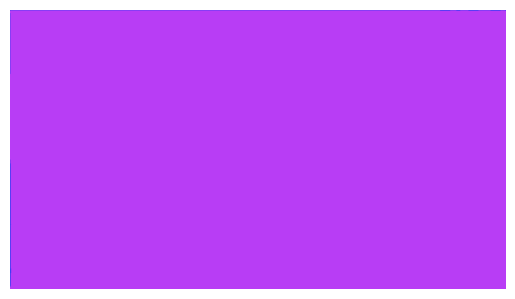

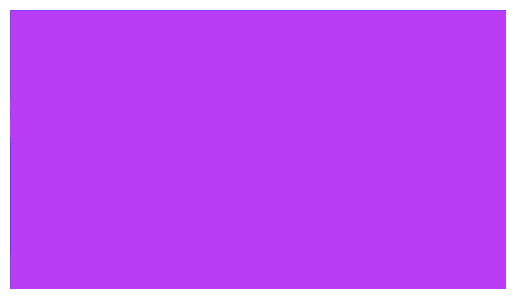

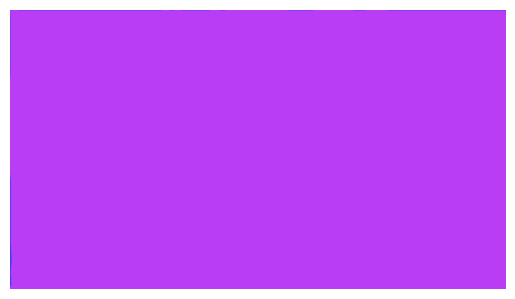

This is epoch 3/20, step 4/8, loss = 0.7102


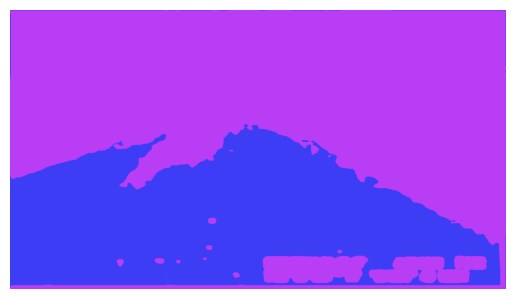

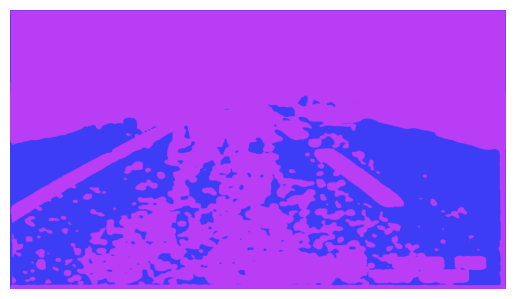

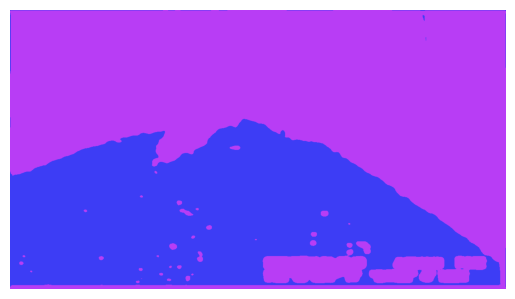

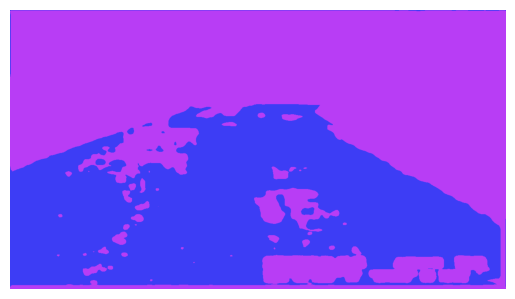

This is epoch 3/20, step 5/8, loss = 0.6656


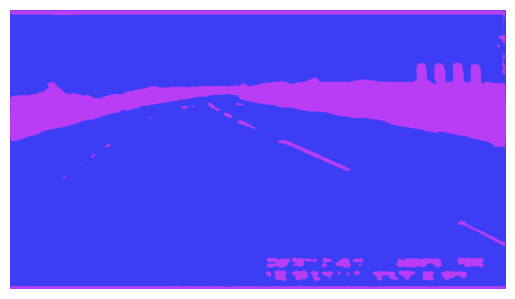

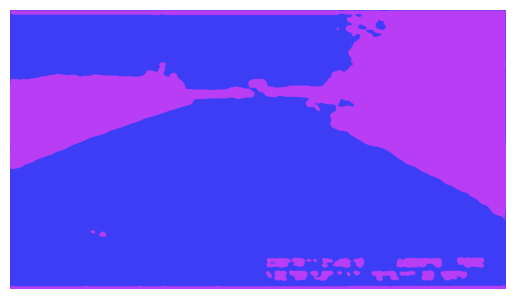

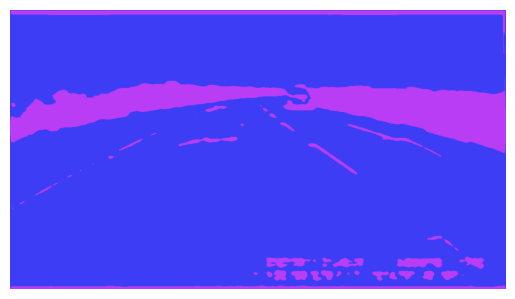

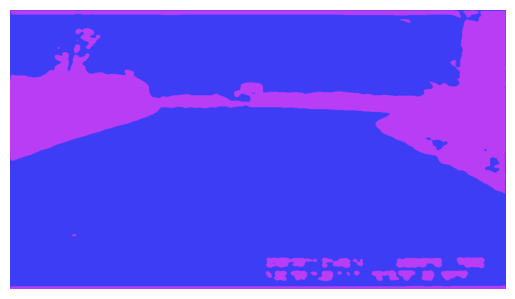

This is epoch 3/20, step 6/8, loss = 0.7308


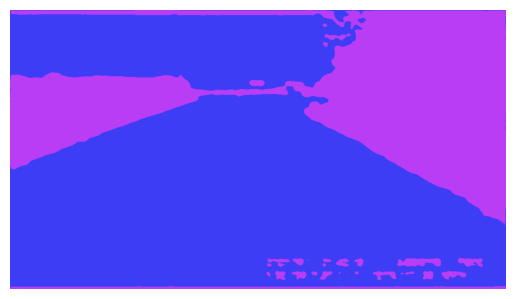

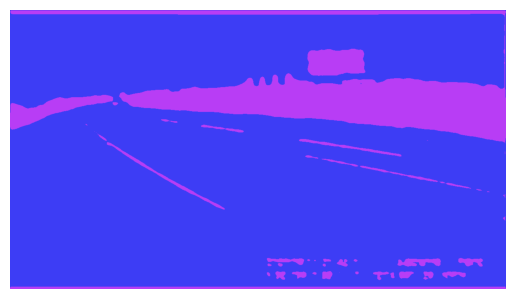

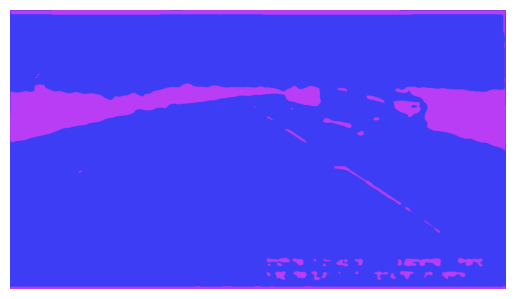

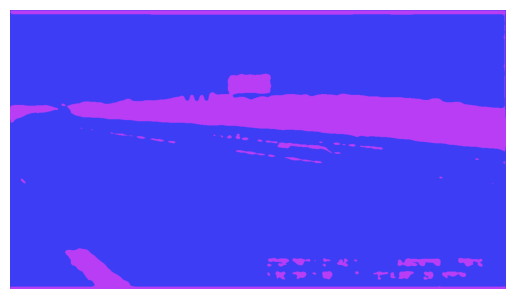

This is epoch 3/20, step 7/8, loss = 0.7607


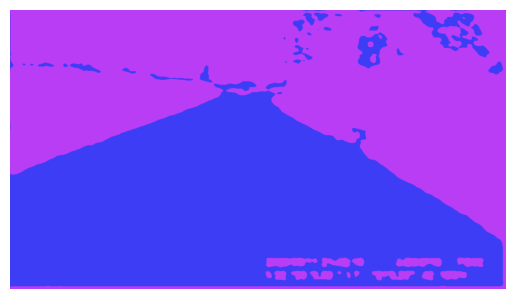

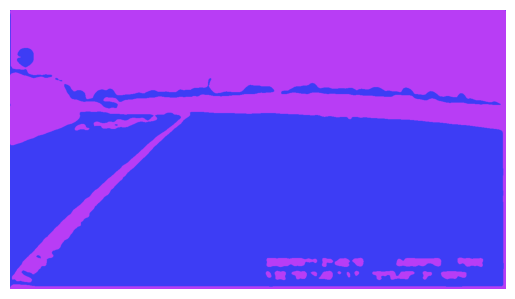

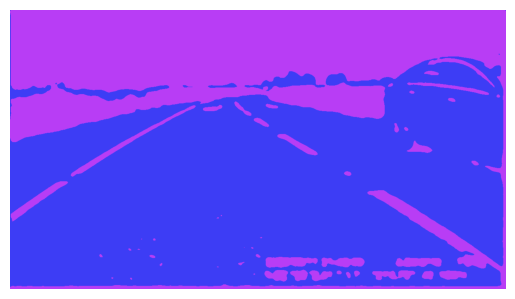

This is epoch 3/20, step 8/8, loss = 0.7426


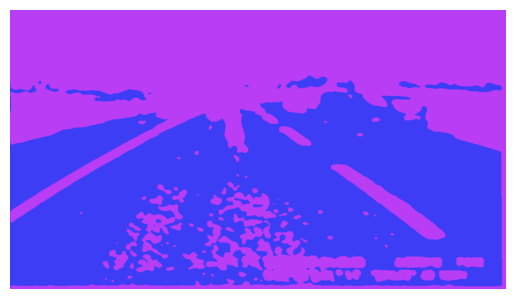

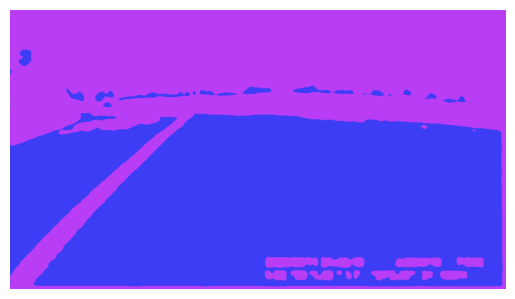

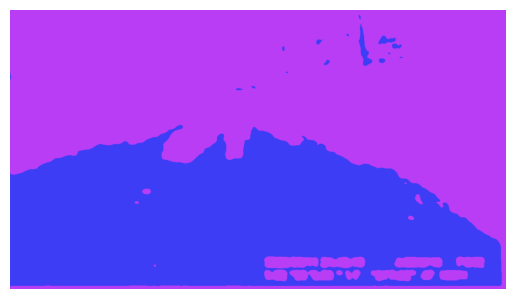

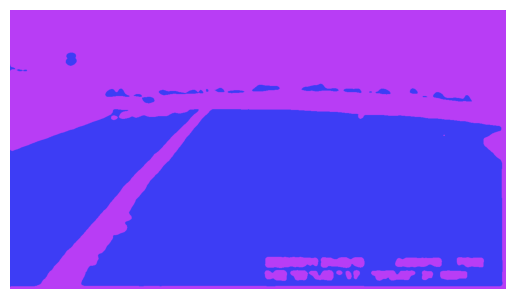

This is epoch 4/20, step 1/8, loss = 0.6608


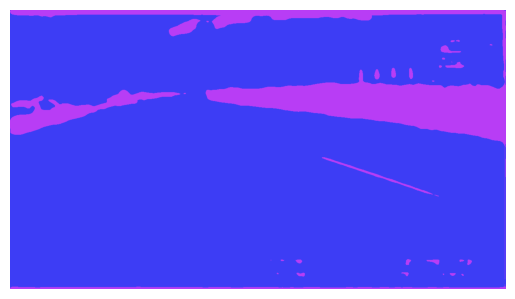

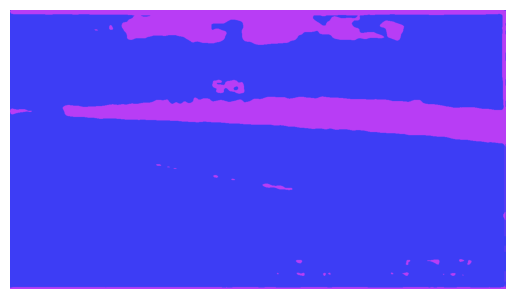

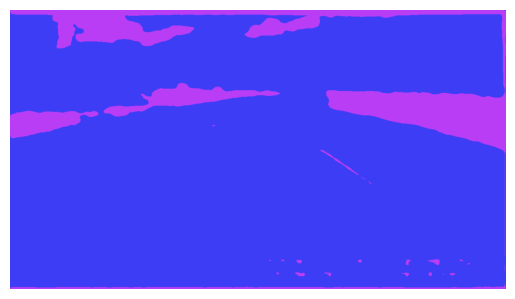

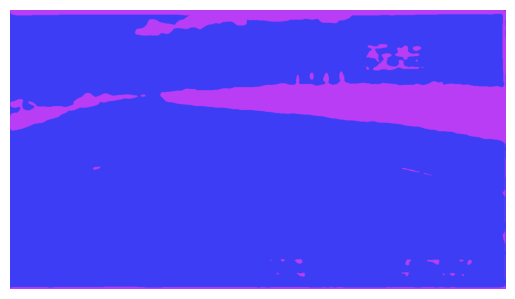

This is epoch 4/20, step 2/8, loss = 0.6660


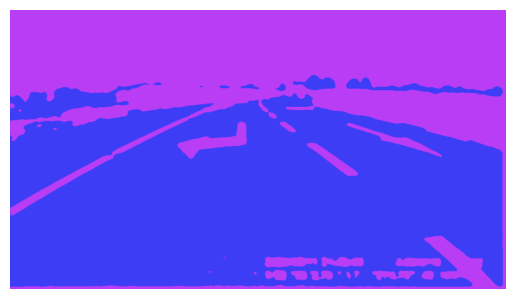

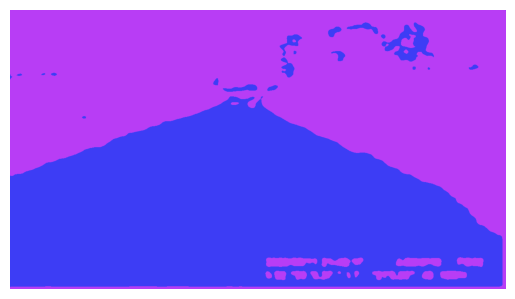

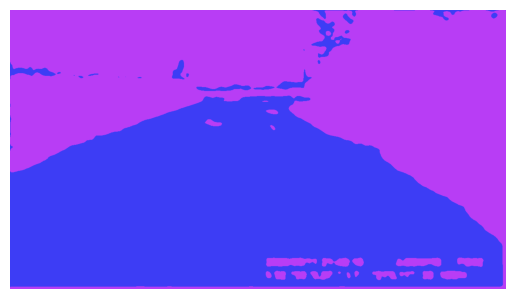

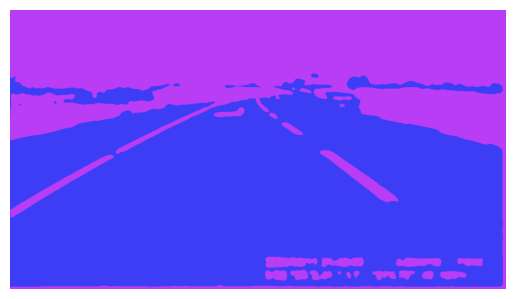

This is epoch 4/20, step 3/8, loss = 0.4735


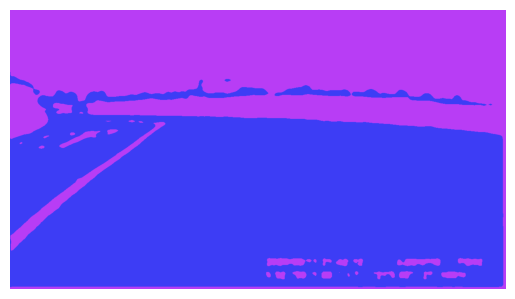

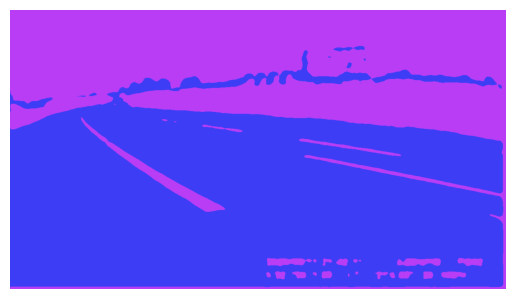

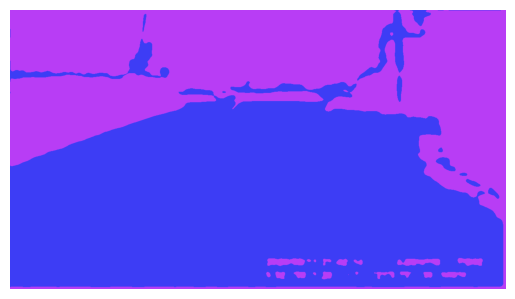

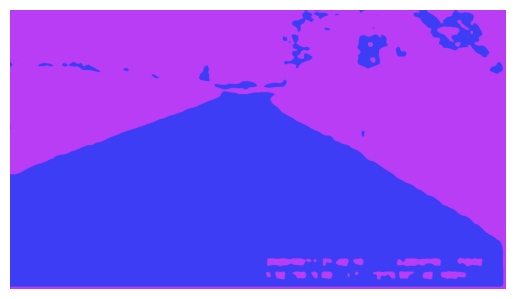

This is epoch 4/20, step 4/8, loss = 0.3883


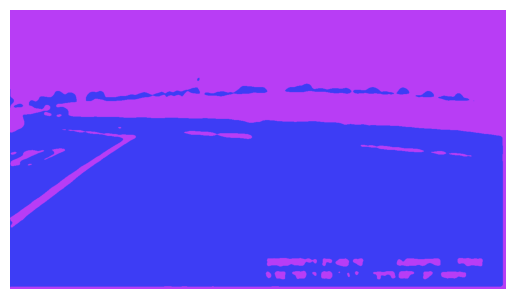

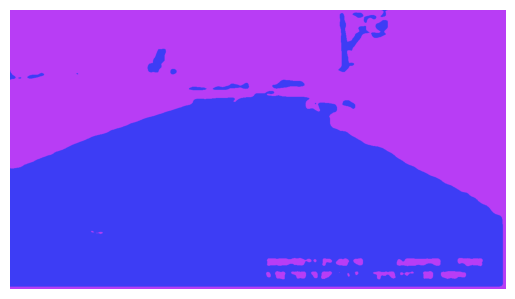

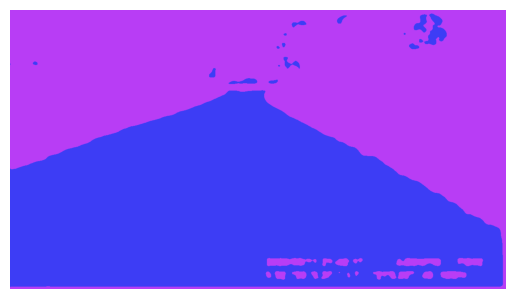

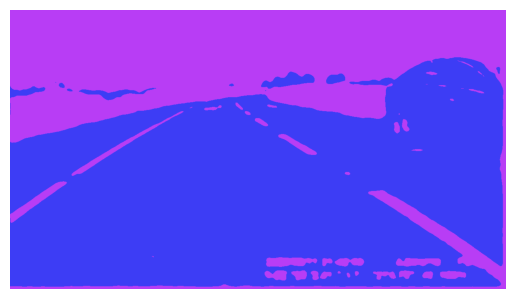

This is epoch 4/20, step 5/8, loss = 0.3891


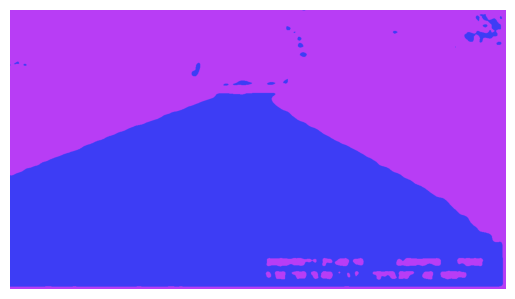

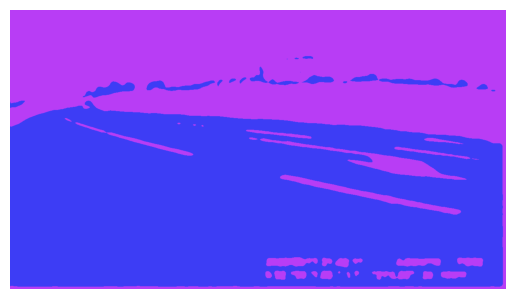

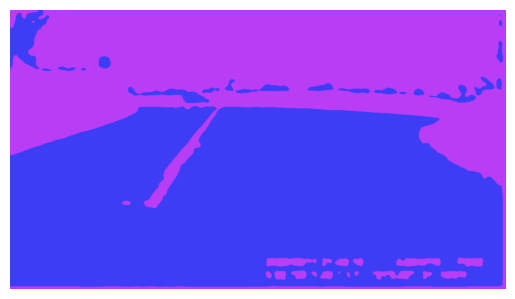

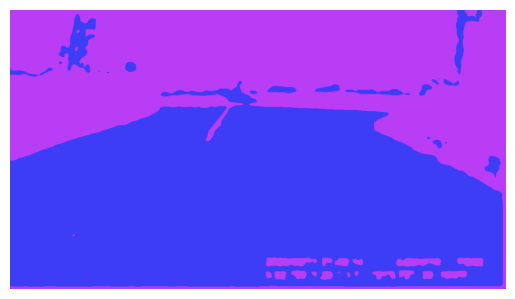

This is epoch 4/20, step 6/8, loss = 0.2763


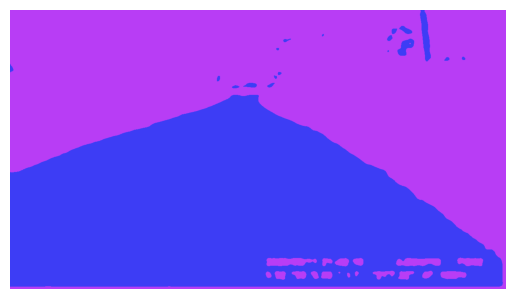

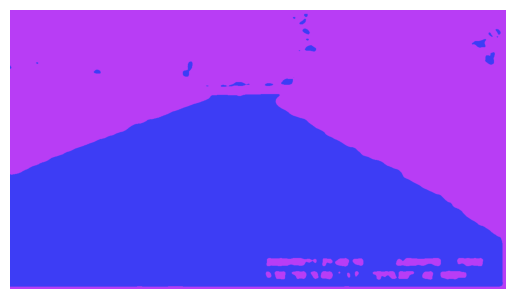

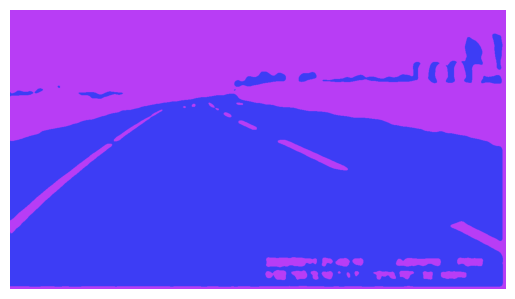

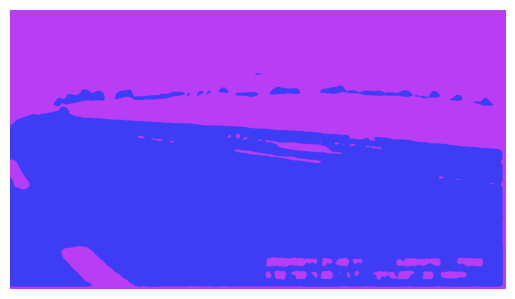

This is epoch 4/20, step 7/8, loss = 0.2776


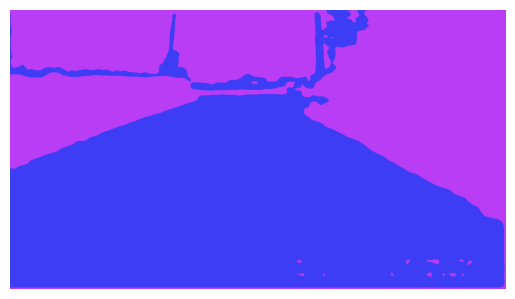

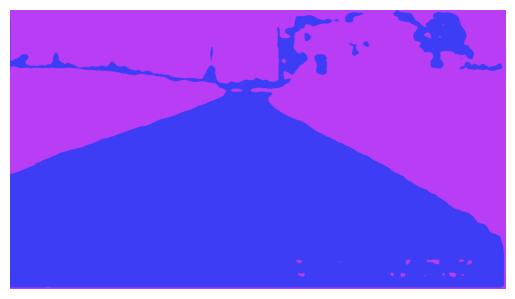

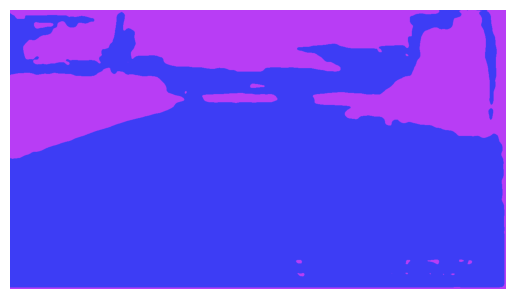

This is epoch 4/20, step 8/8, loss = 0.2647


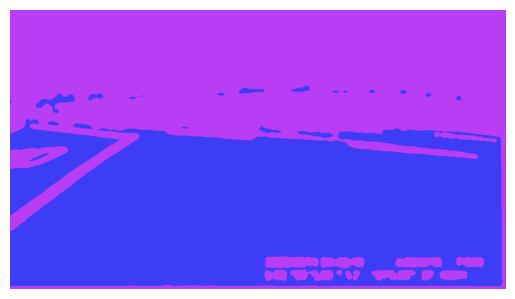

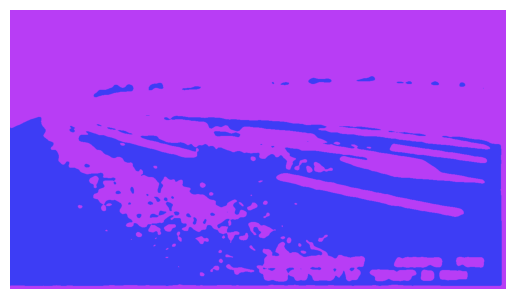

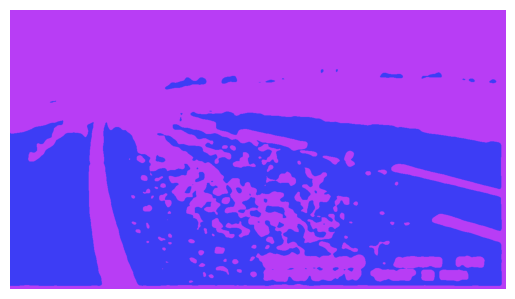

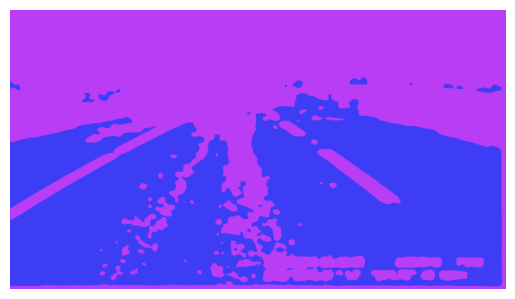

This is epoch 5/20, step 1/8, loss = 0.7217


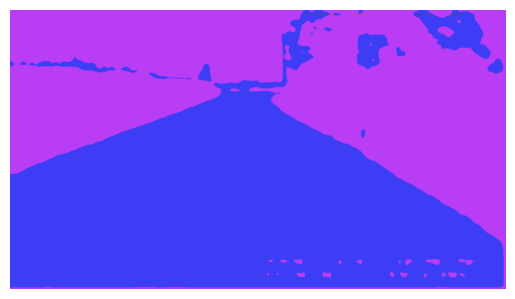

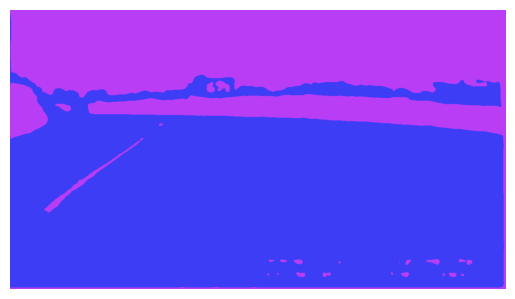

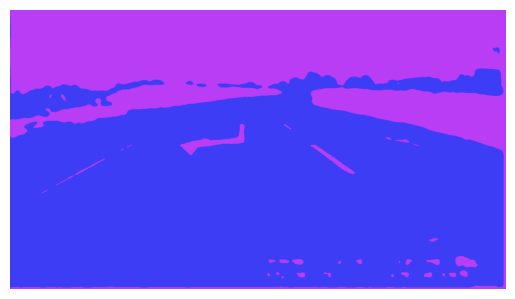

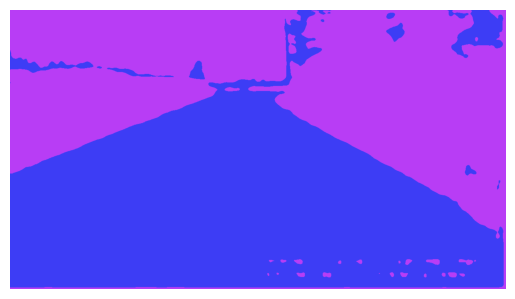

This is epoch 5/20, step 2/8, loss = 0.2853


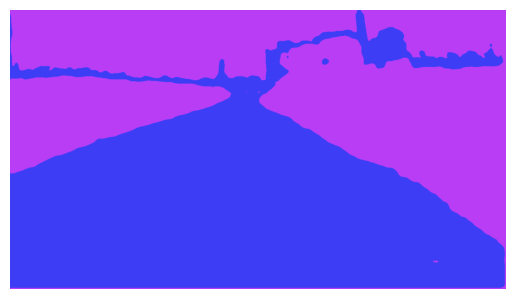

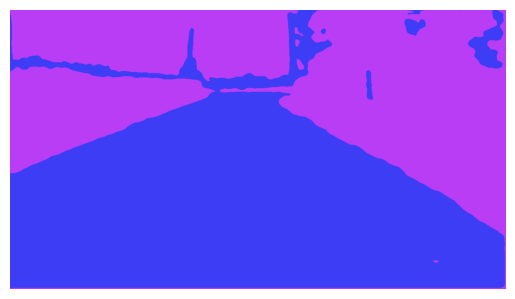

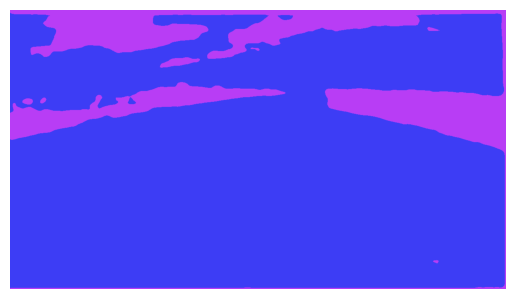

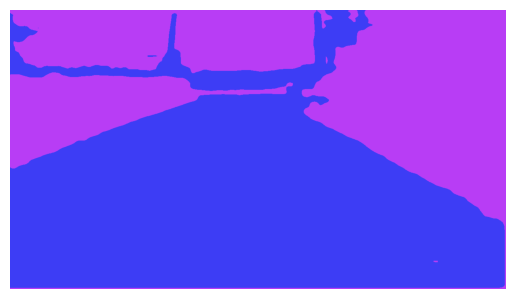

This is epoch 5/20, step 3/8, loss = 0.3348


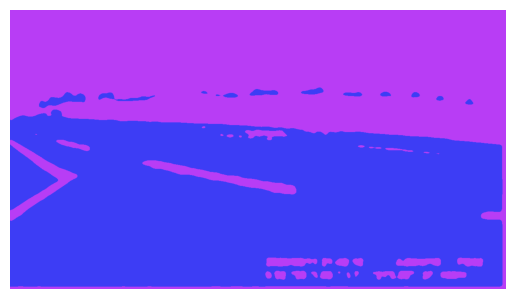

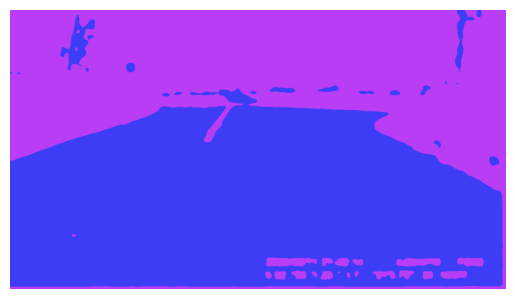

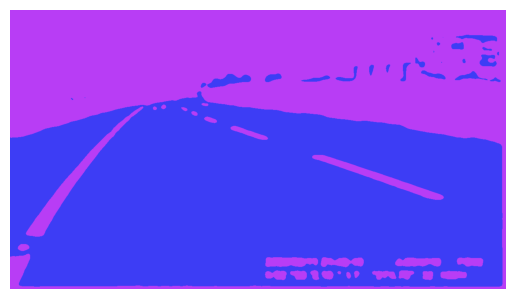

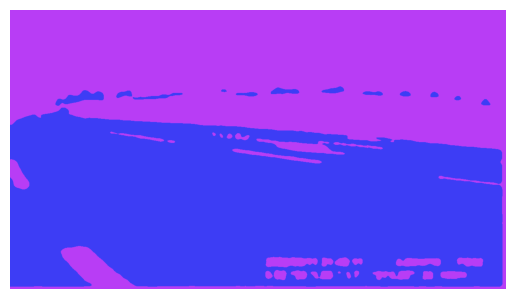

This is epoch 5/20, step 4/8, loss = 0.3625


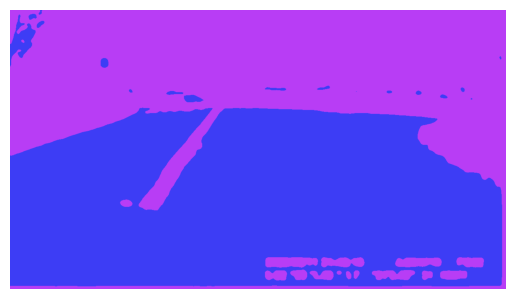

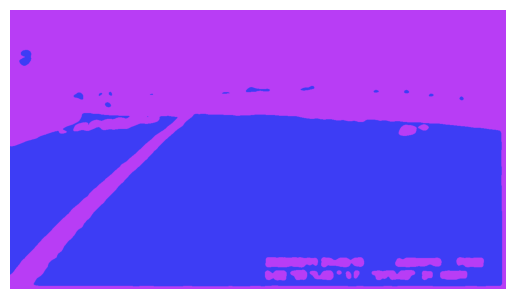

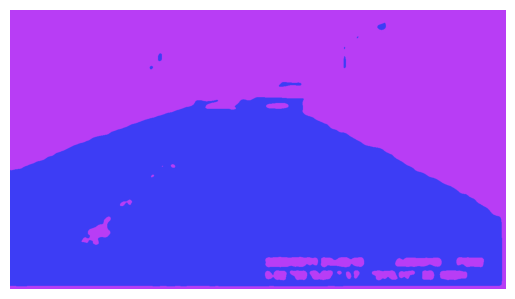

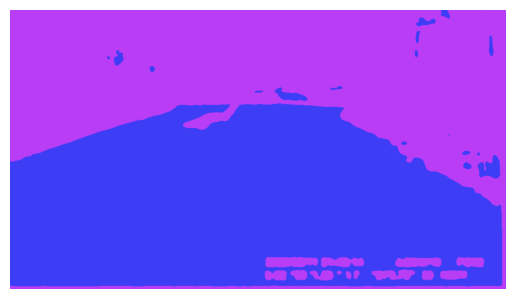

This is epoch 5/20, step 5/8, loss = 0.3209


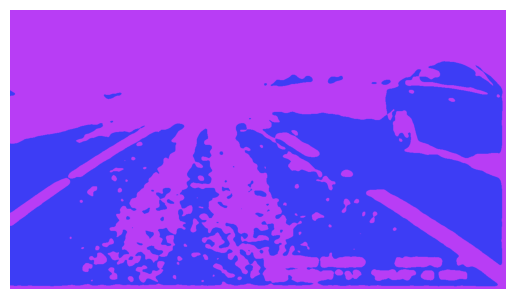

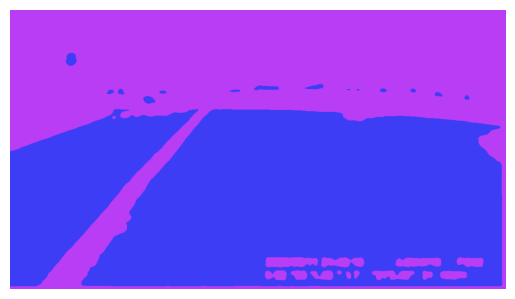

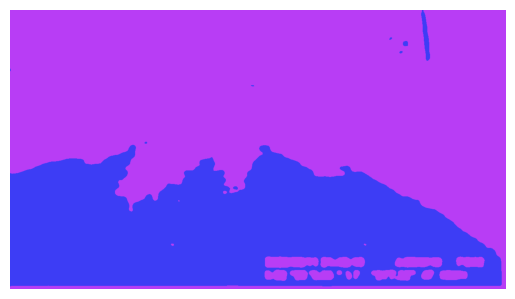

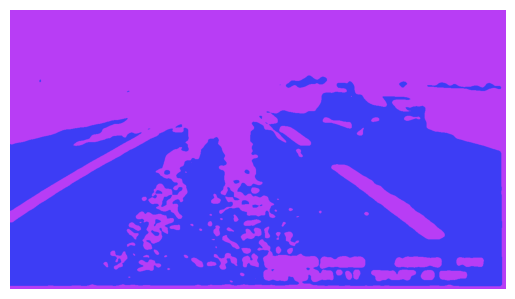

This is epoch 5/20, step 6/8, loss = 0.6971


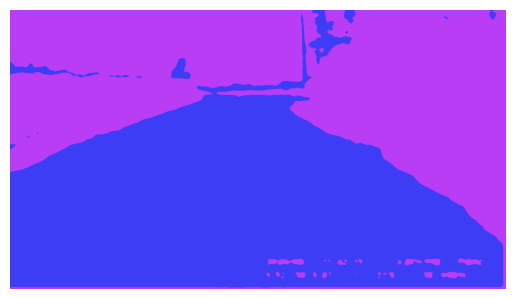

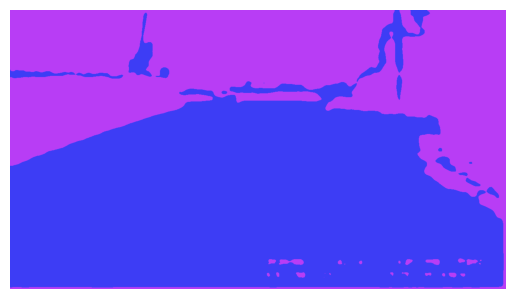

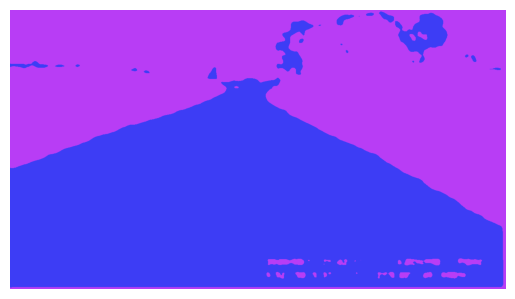

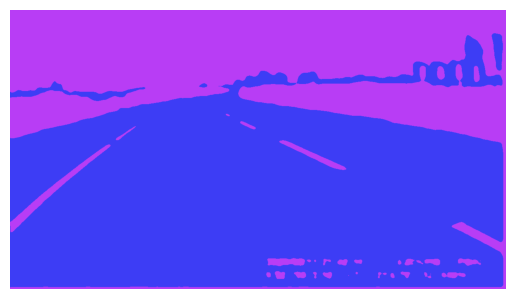

This is epoch 5/20, step 7/8, loss = 0.2080


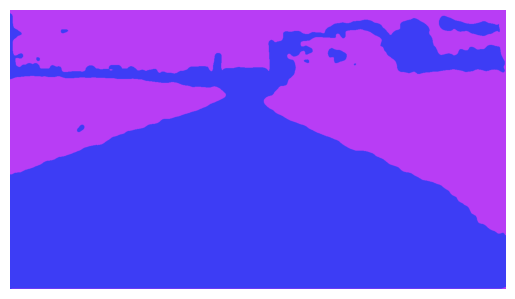

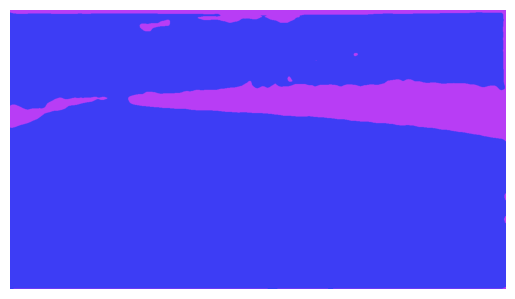

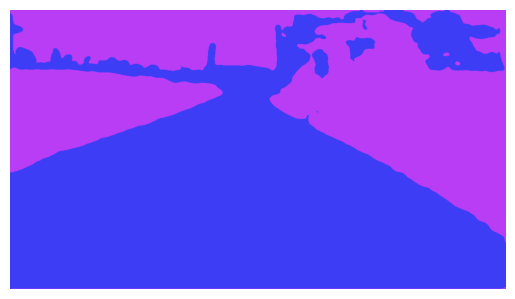

This is epoch 5/20, step 8/8, loss = 0.5724


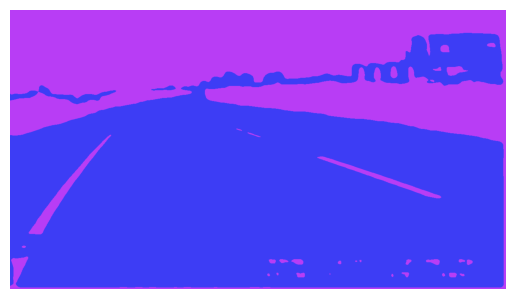

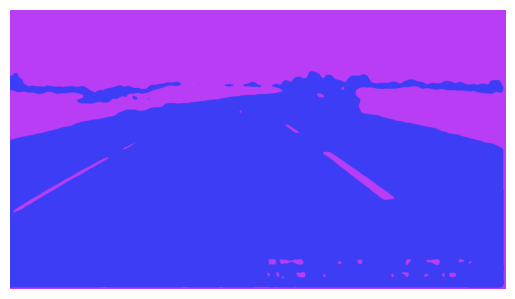

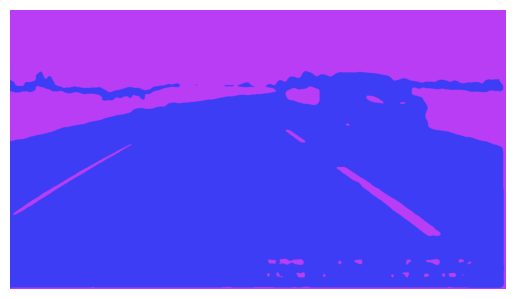

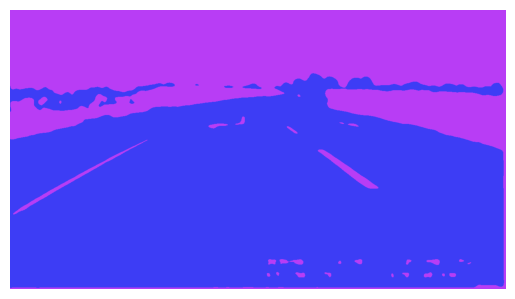

This is epoch 6/20, step 1/8, loss = 0.3828


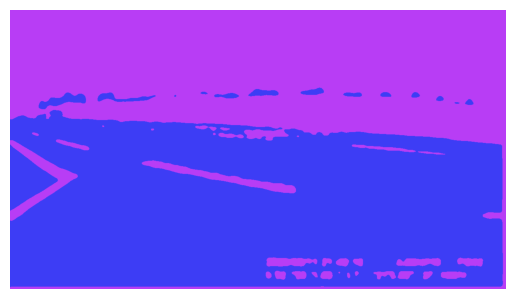

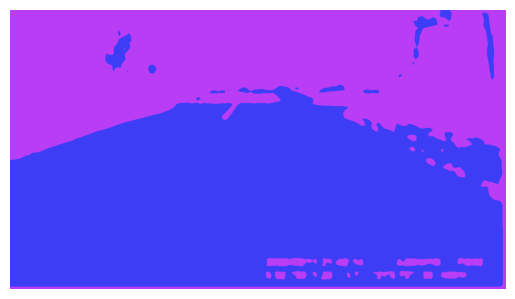

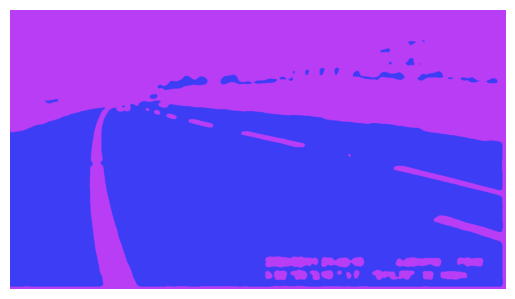

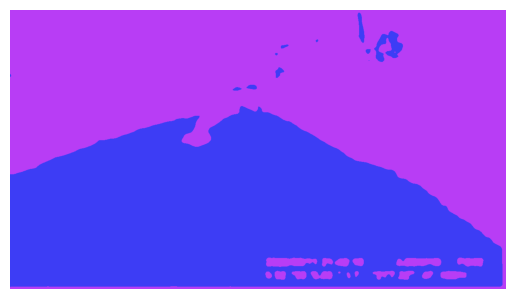

This is epoch 6/20, step 2/8, loss = 0.2822


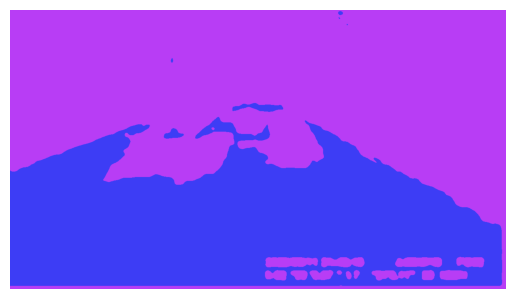

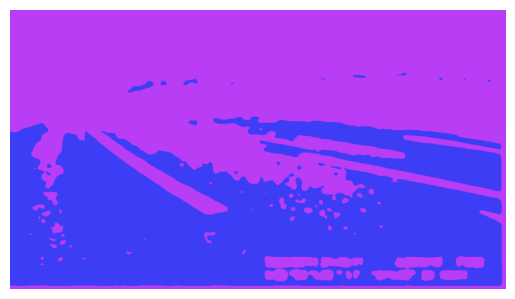

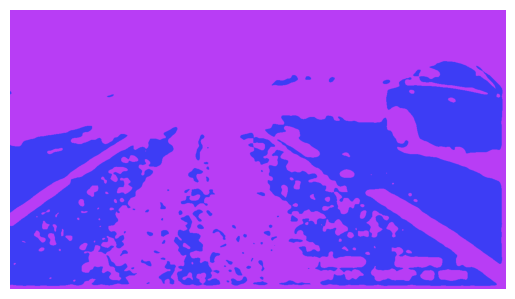

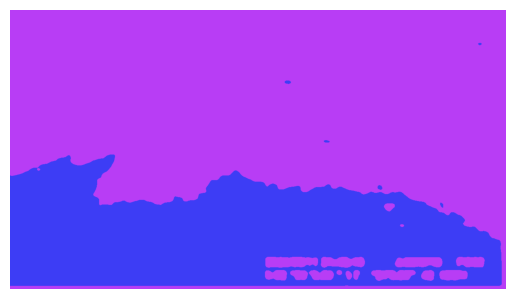

This is epoch 6/20, step 3/8, loss = 0.7008


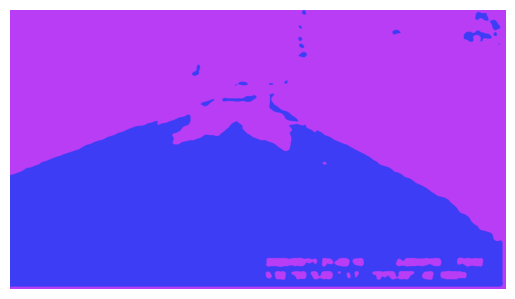

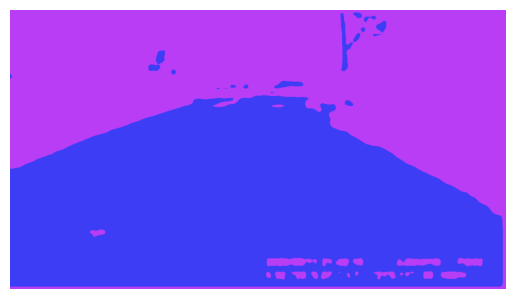

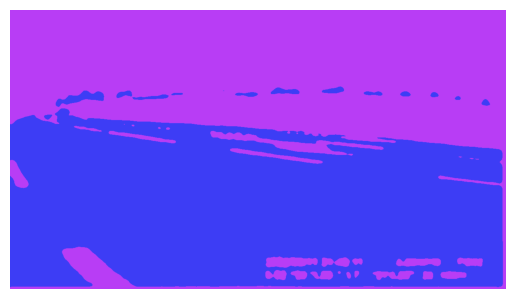

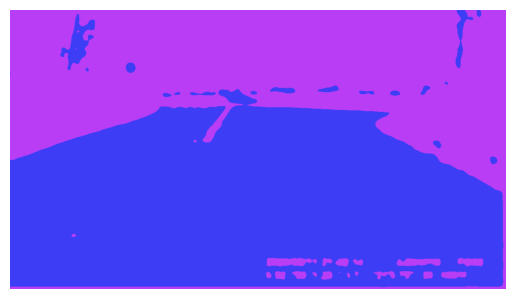

This is epoch 6/20, step 4/8, loss = 0.2452


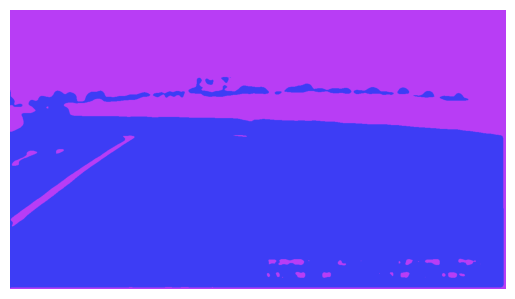

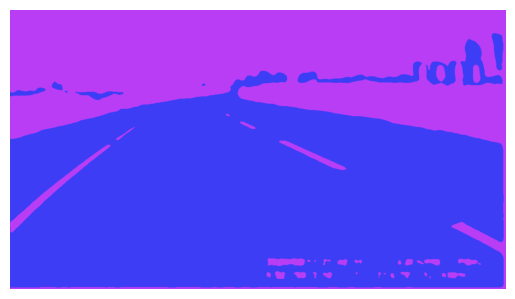

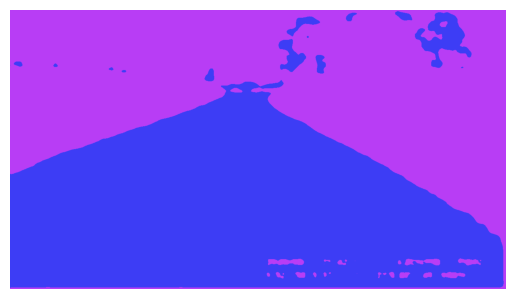

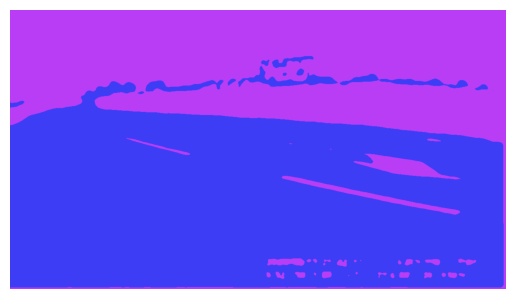

This is epoch 6/20, step 5/8, loss = 0.2766


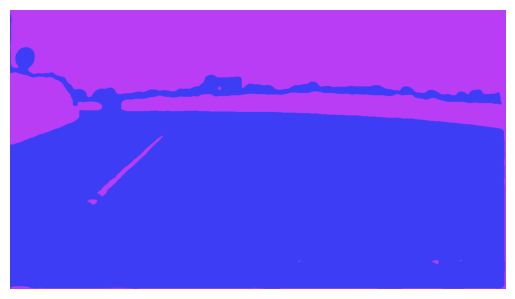

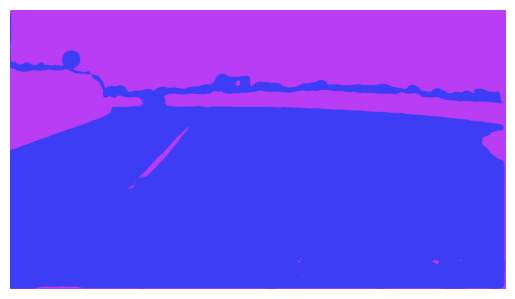

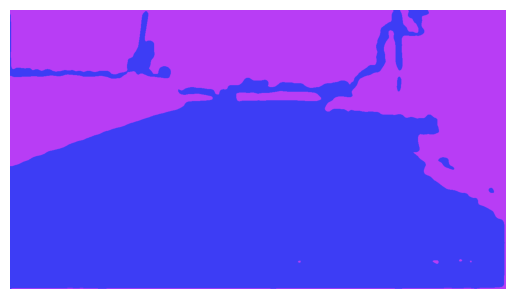

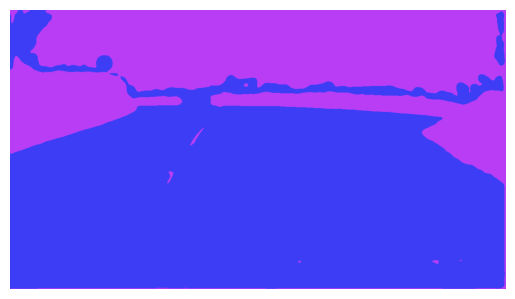

This is epoch 6/20, step 6/8, loss = 0.3921


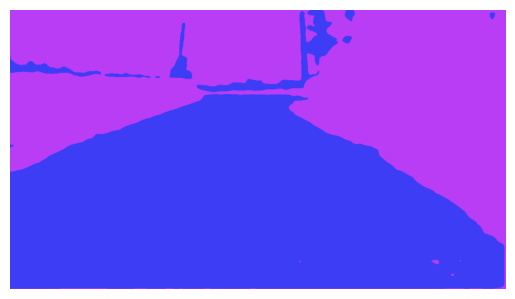

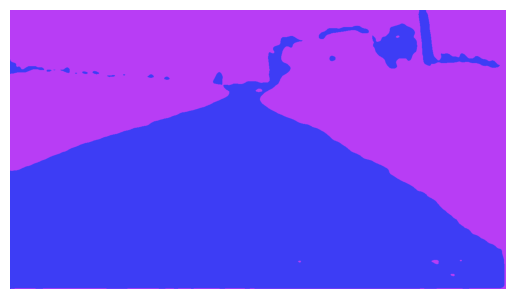

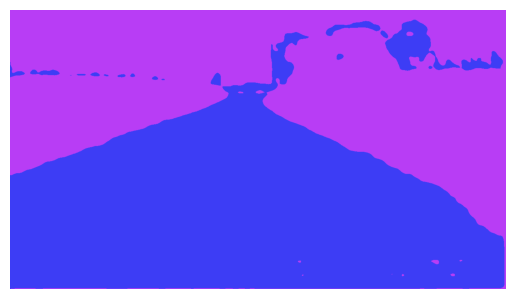

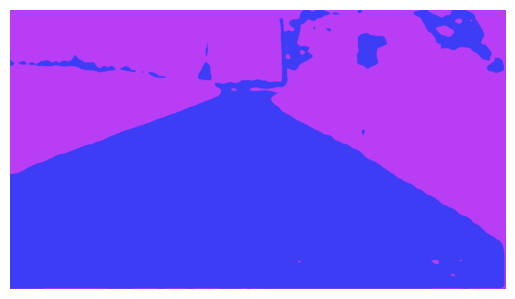

This is epoch 6/20, step 7/8, loss = 0.2041


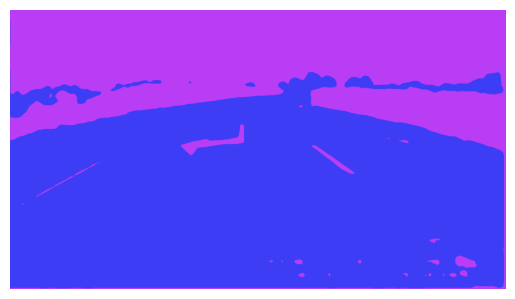

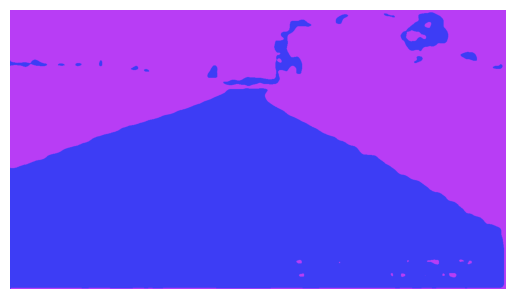

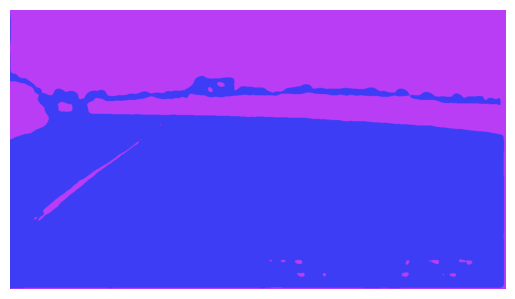

This is epoch 6/20, step 8/8, loss = 0.2957


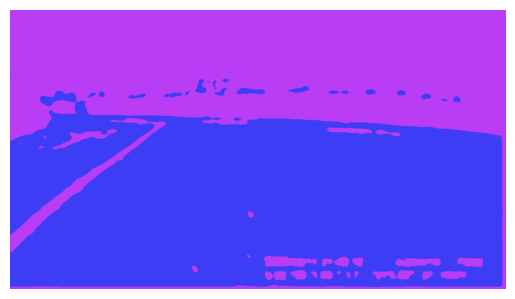

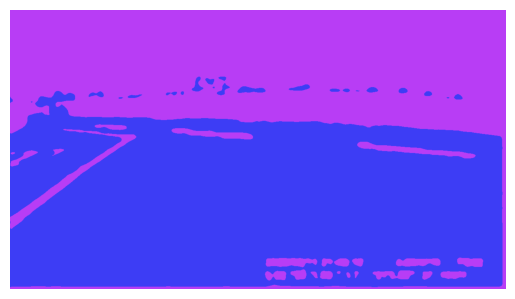

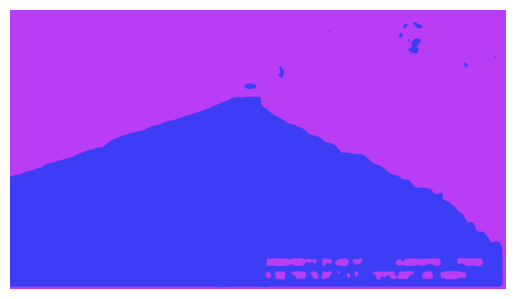

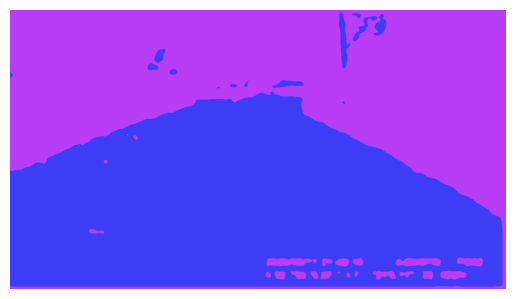

This is epoch 7/20, step 1/8, loss = 0.2778


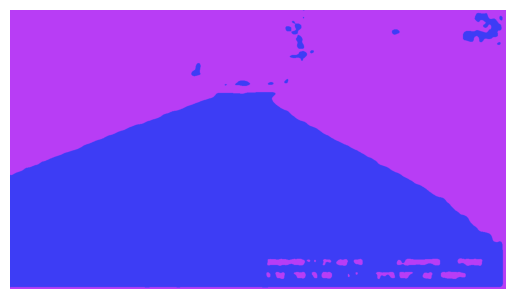

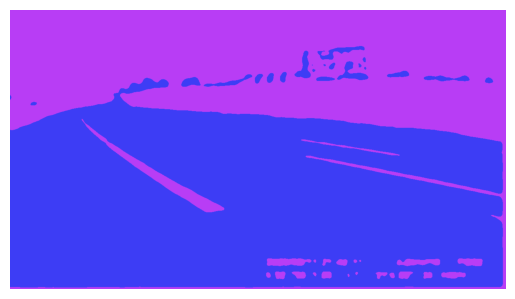

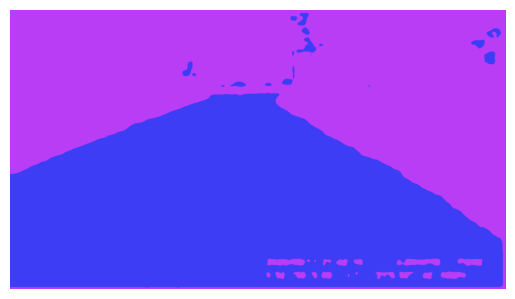

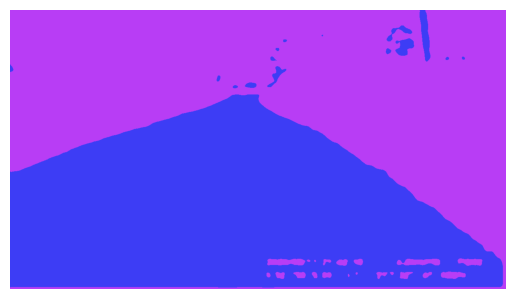

This is epoch 7/20, step 2/8, loss = 0.1692


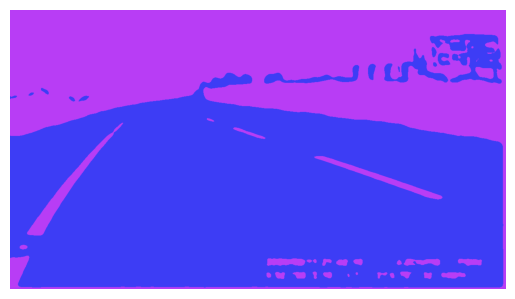

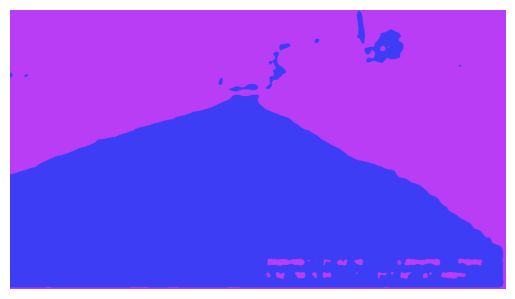

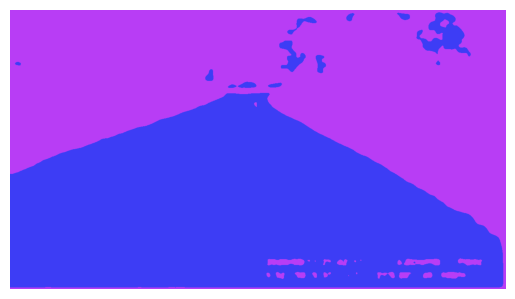

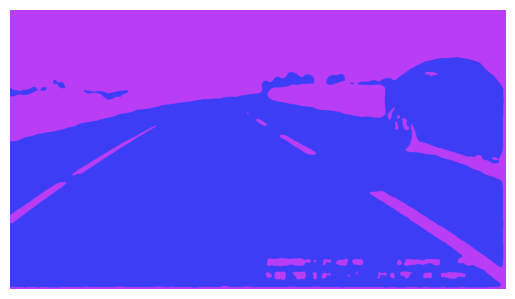

This is epoch 7/20, step 3/8, loss = 0.2995


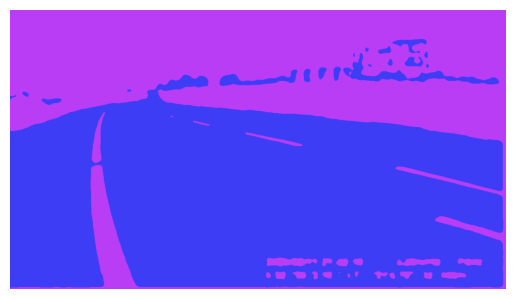

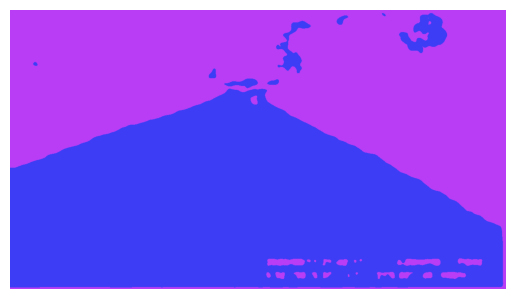

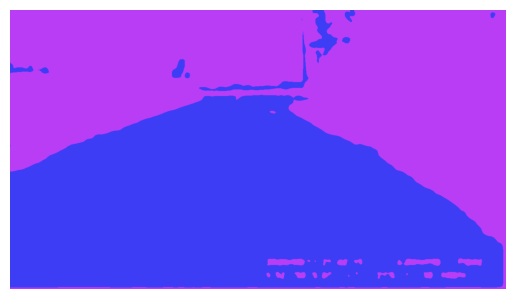

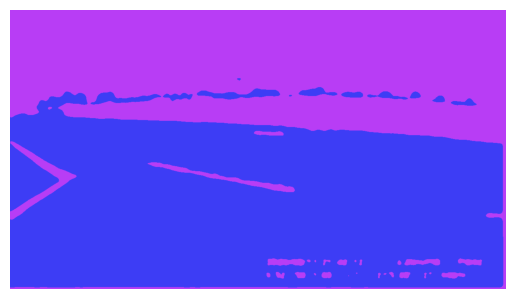

This is epoch 7/20, step 4/8, loss = 0.2010


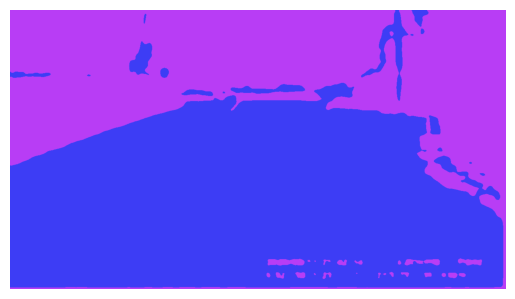

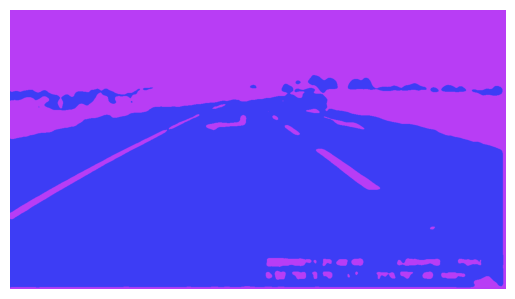

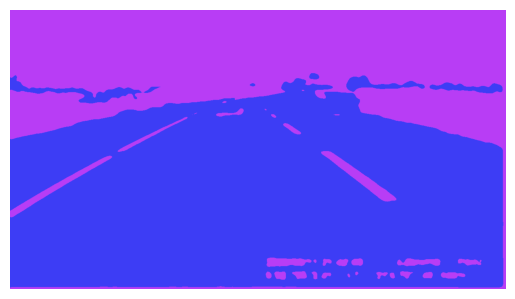

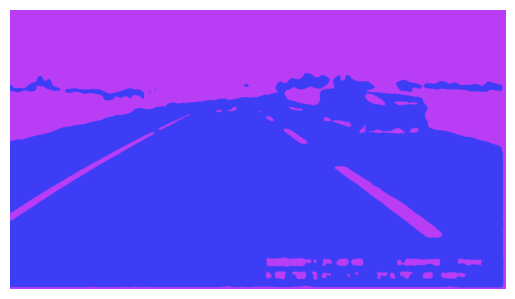

This is epoch 7/20, step 5/8, loss = 0.3041


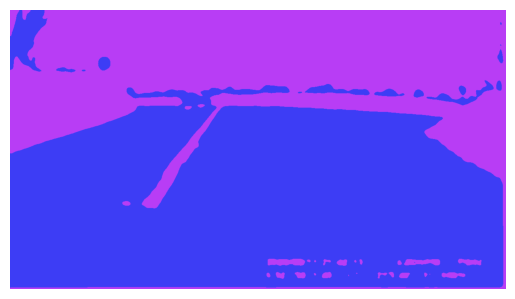

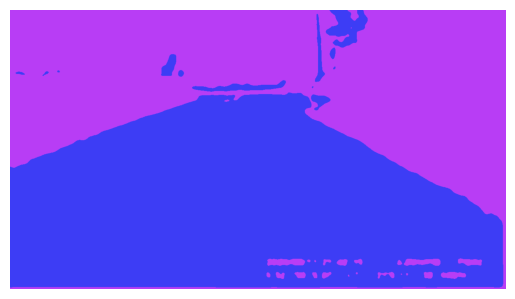

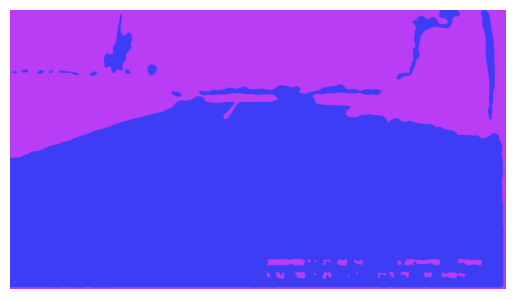

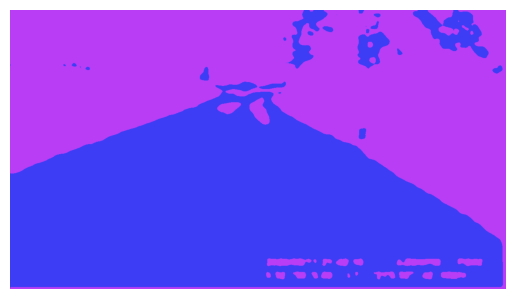

This is epoch 7/20, step 6/8, loss = 0.2217


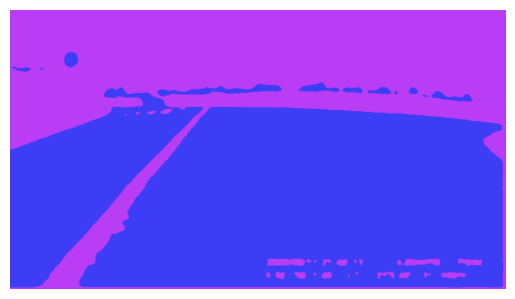

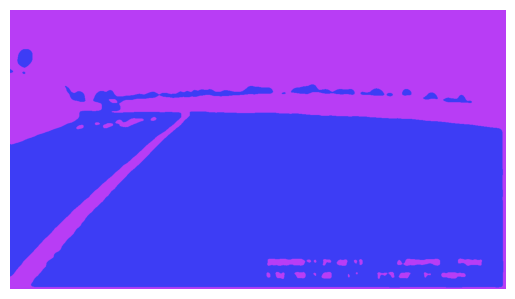

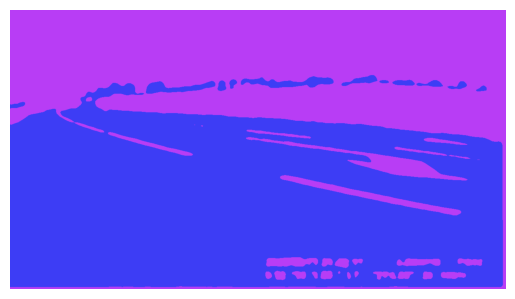

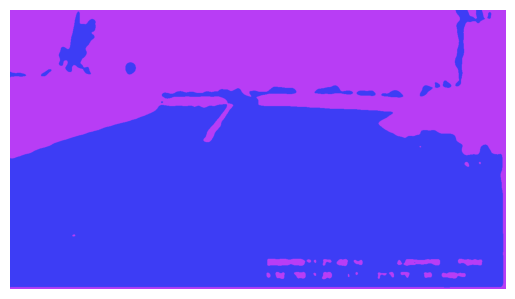

This is epoch 7/20, step 7/8, loss = 0.2650


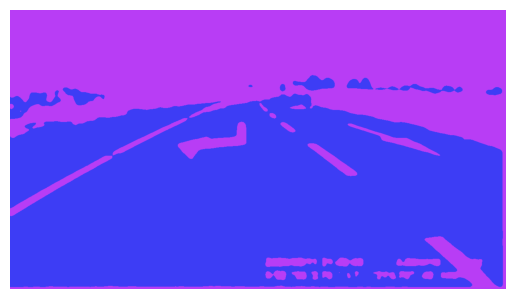

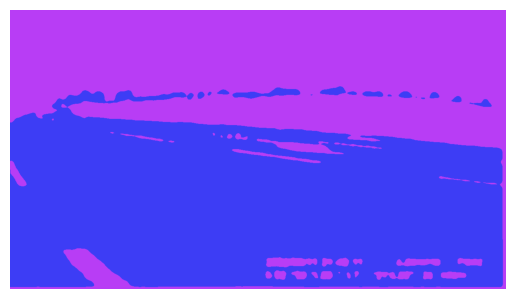

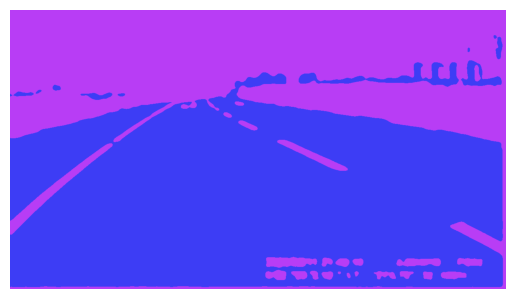

This is epoch 7/20, step 8/8, loss = 0.2973


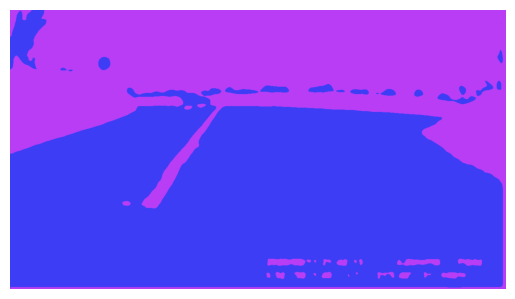

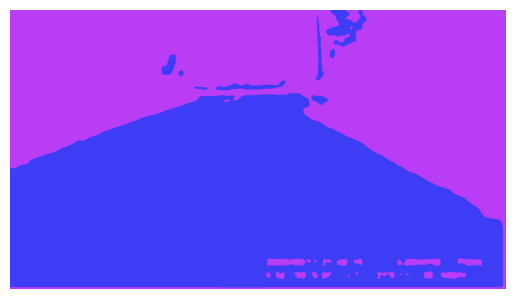

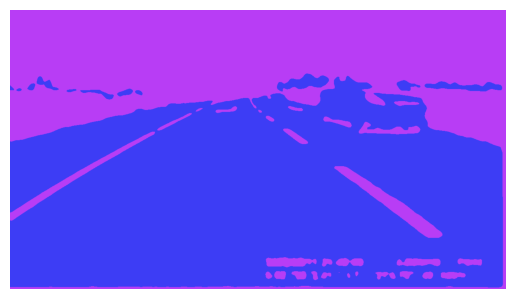

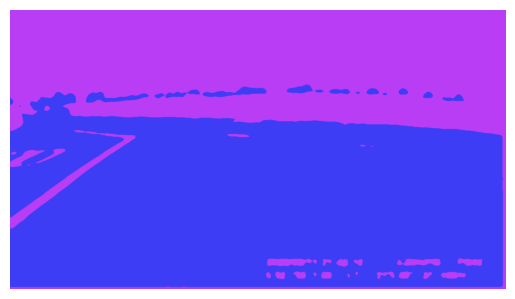

This is epoch 8/20, step 1/8, loss = 0.2378


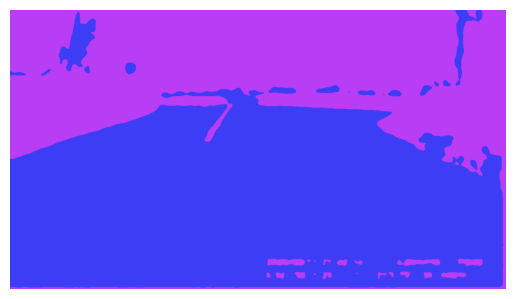

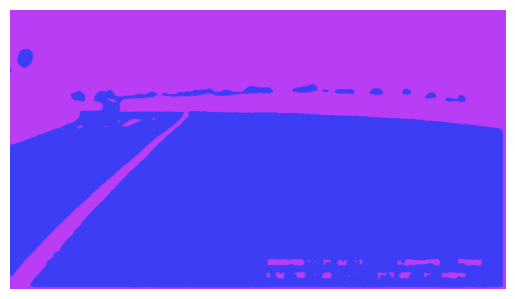

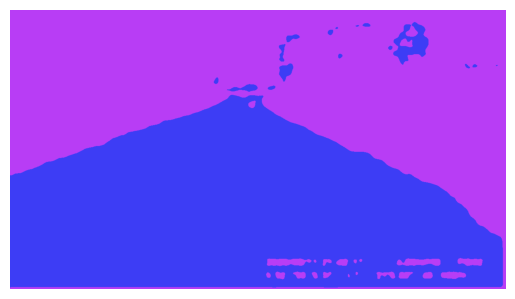

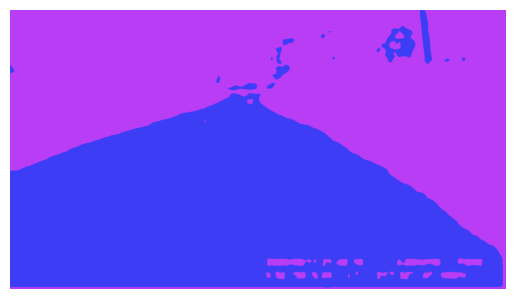

This is epoch 8/20, step 2/8, loss = 0.1564


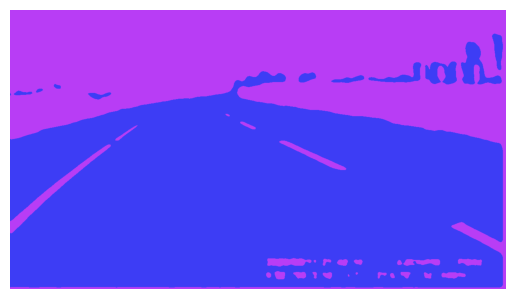

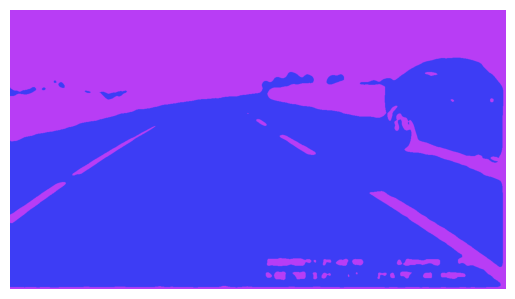

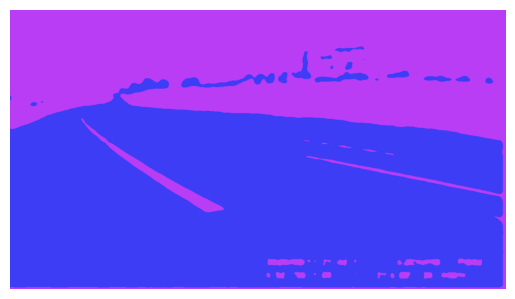

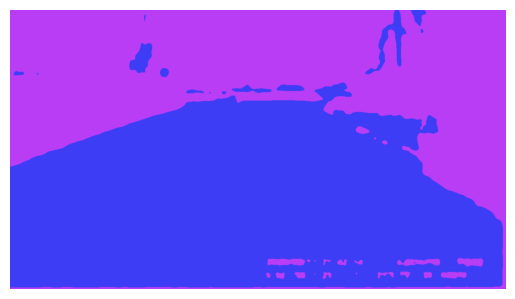

This is epoch 8/20, step 3/8, loss = 0.3302


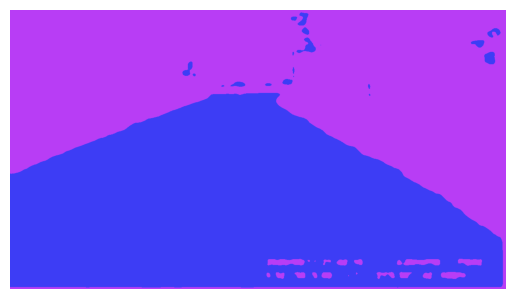

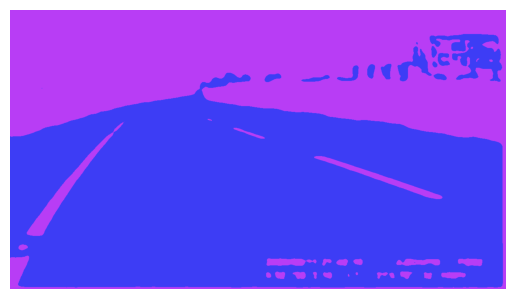

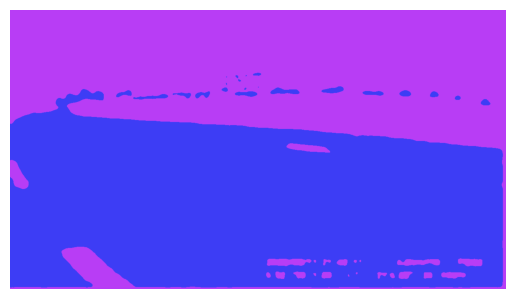

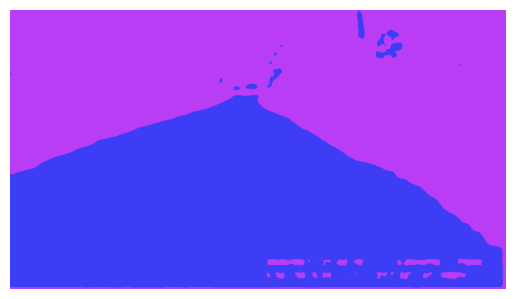

This is epoch 8/20, step 4/8, loss = 0.1943


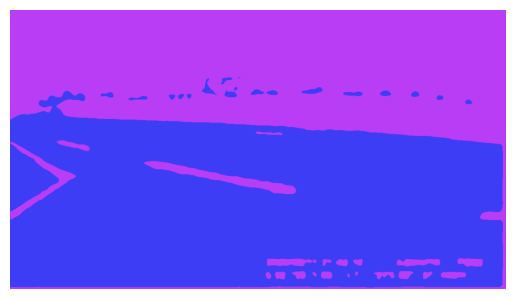

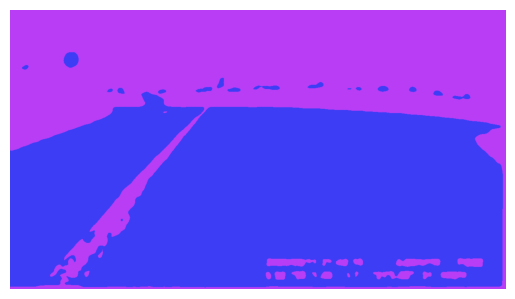

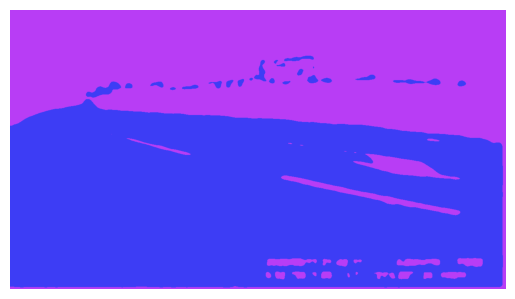

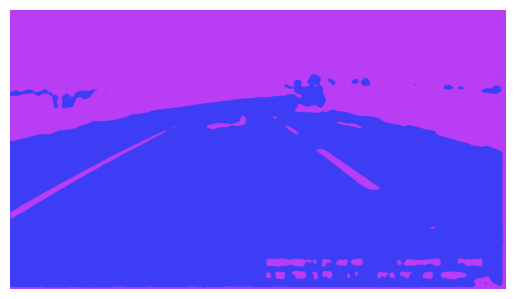

This is epoch 8/20, step 5/8, loss = 0.2644


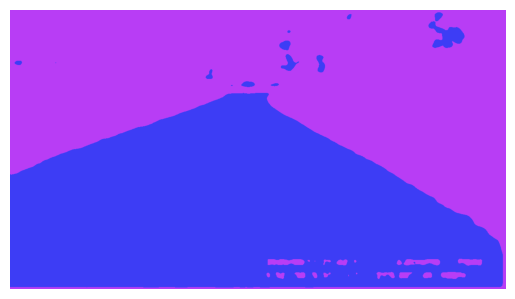

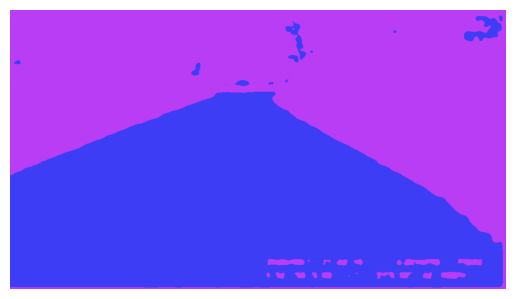

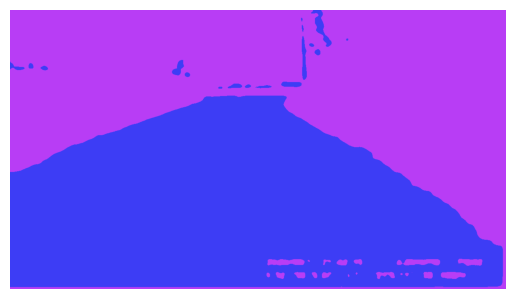

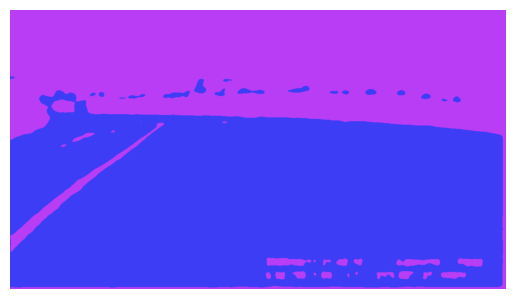

This is epoch 8/20, step 6/8, loss = 0.1313


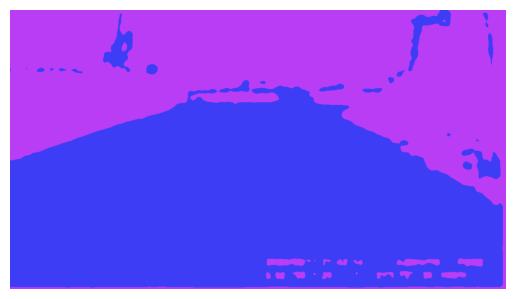

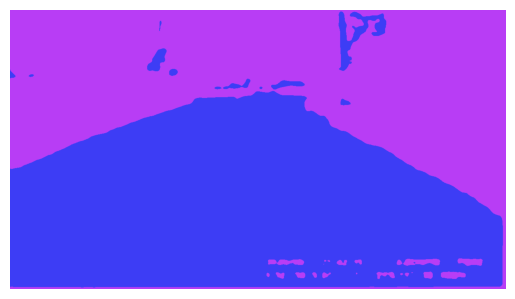

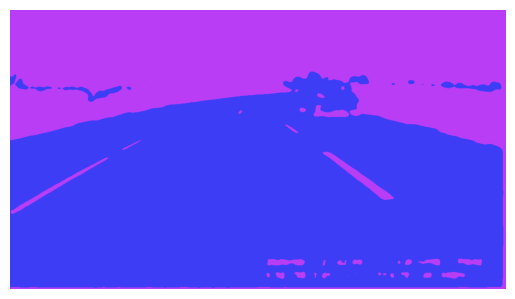

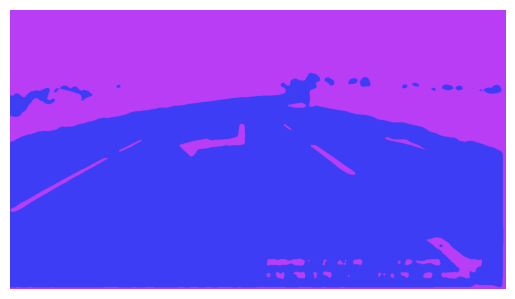

This is epoch 8/20, step 7/8, loss = 0.2065


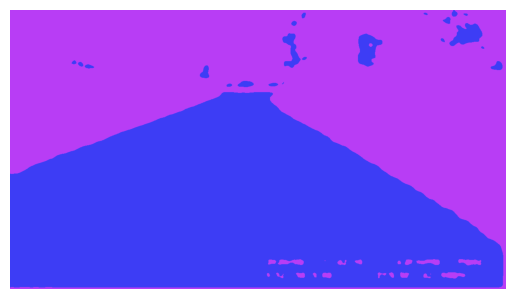

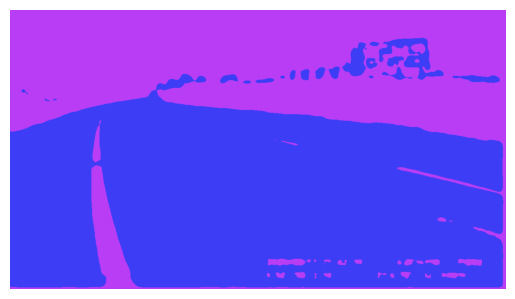

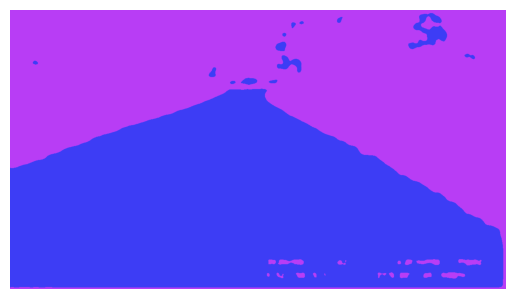

This is epoch 8/20, step 8/8, loss = 0.1573


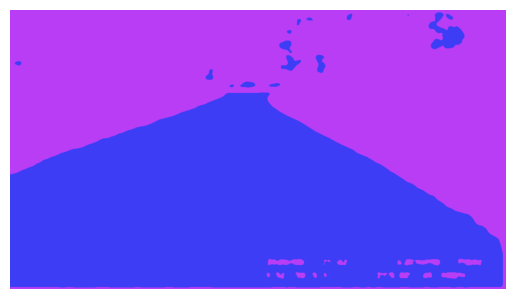

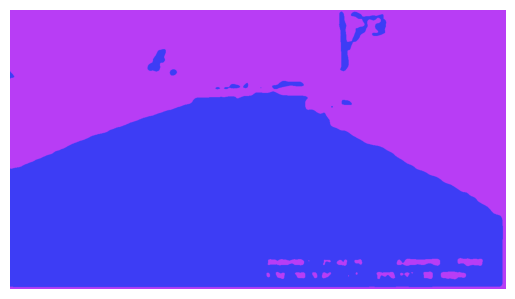

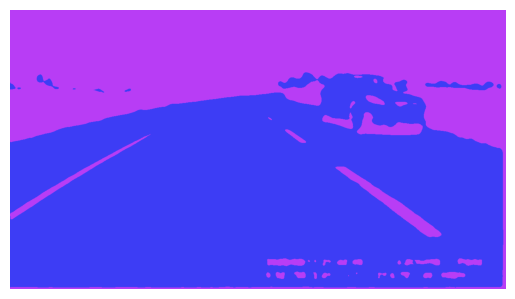

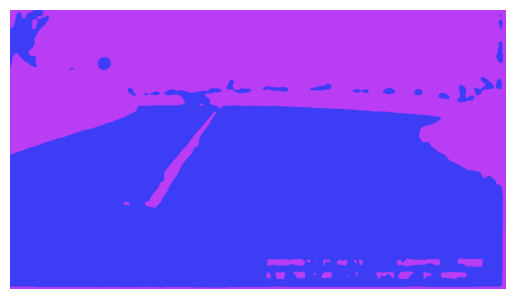

This is epoch 9/20, step 1/8, loss = 0.1845


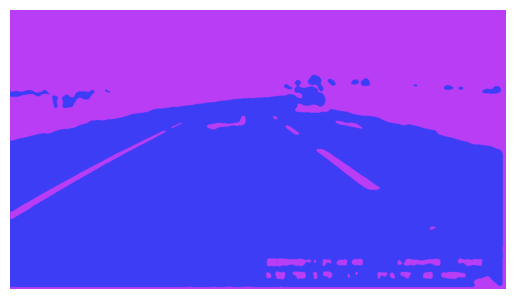

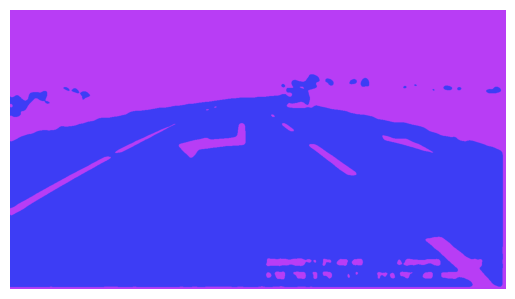

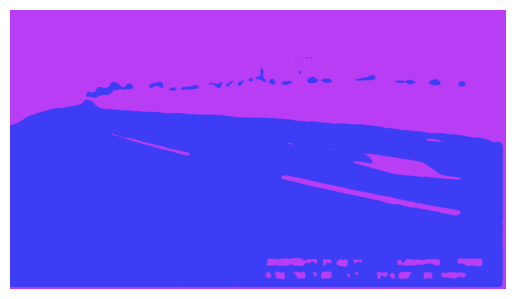

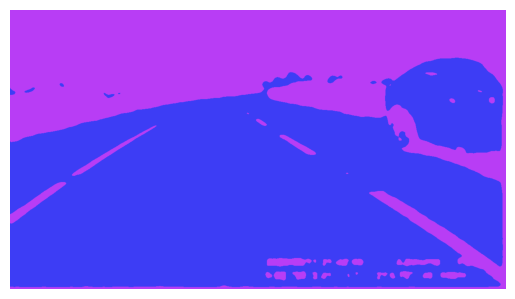

This is epoch 9/20, step 2/8, loss = 0.3166


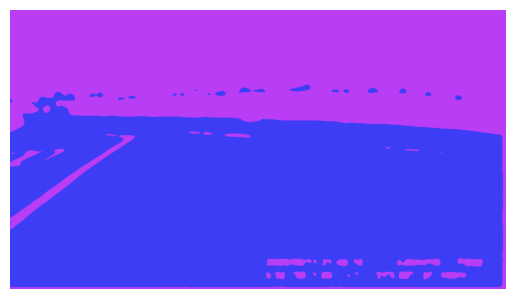

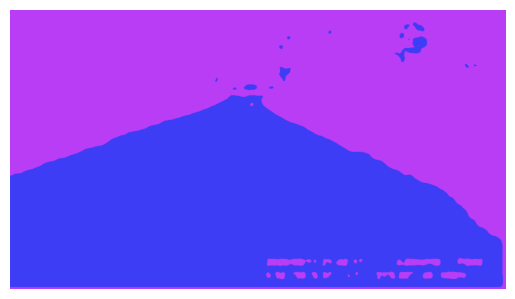

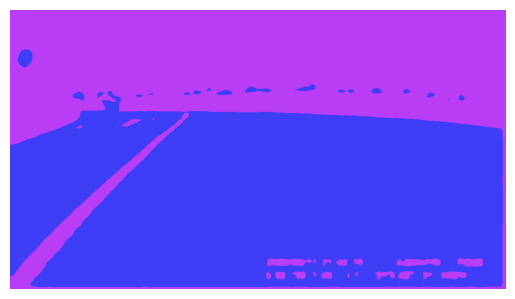

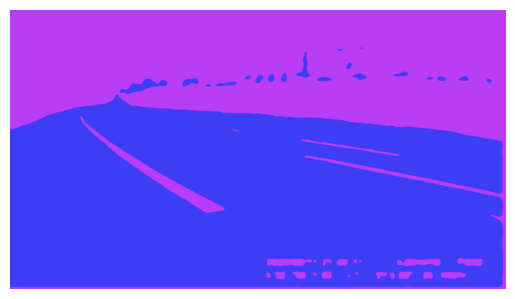

This is epoch 9/20, step 3/8, loss = 0.1913


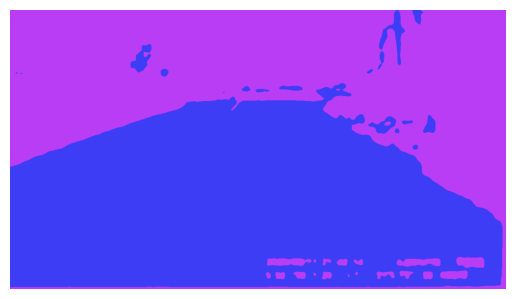

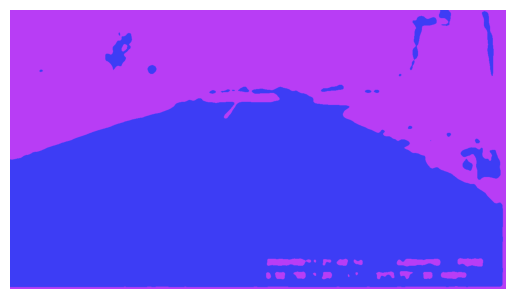

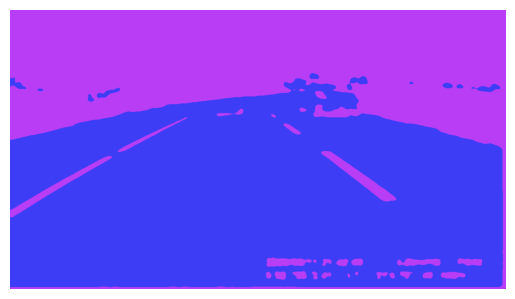

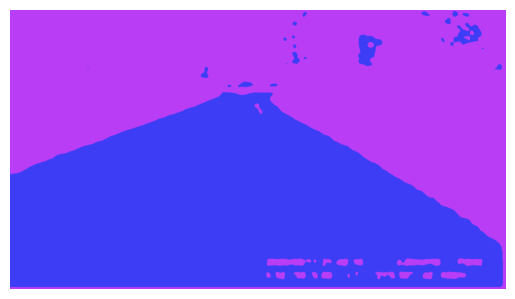

This is epoch 9/20, step 4/8, loss = 0.1577


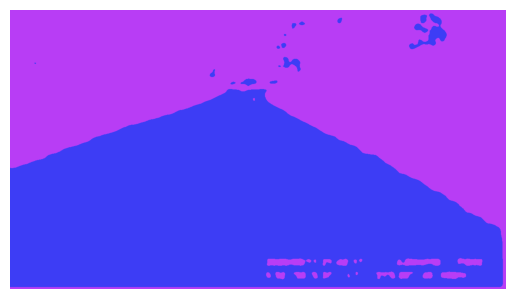

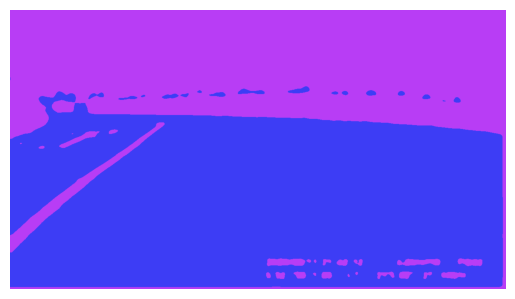

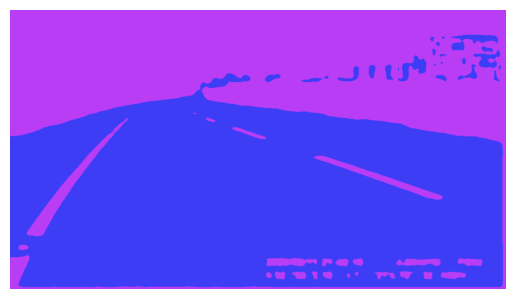

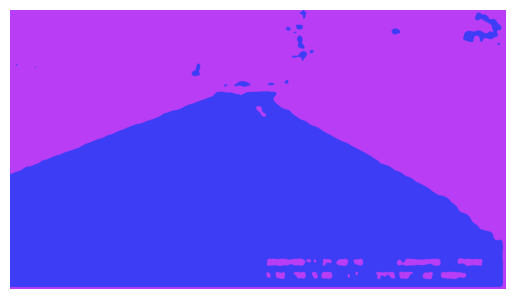

This is epoch 9/20, step 5/8, loss = 0.1609


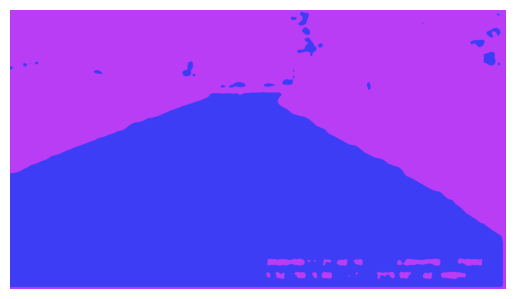

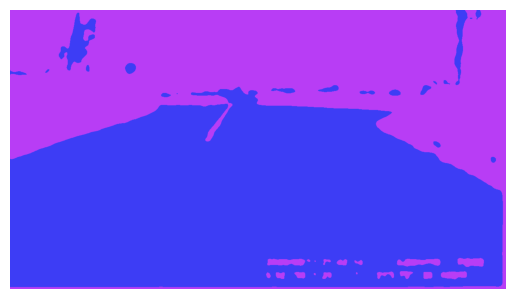

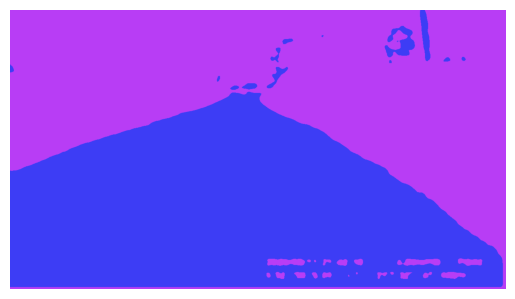

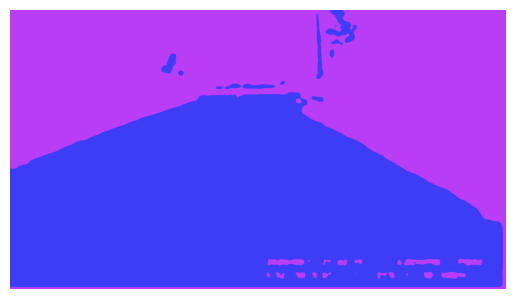

This is epoch 9/20, step 6/8, loss = 0.1034


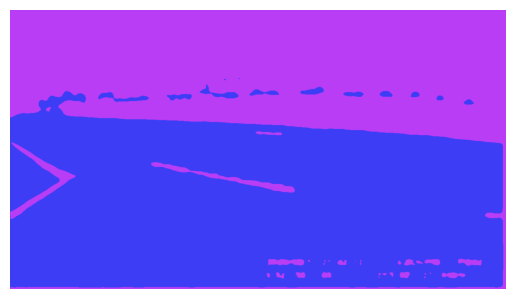

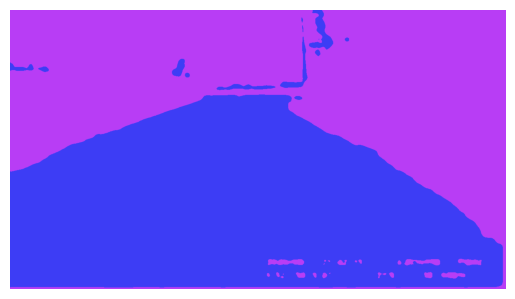

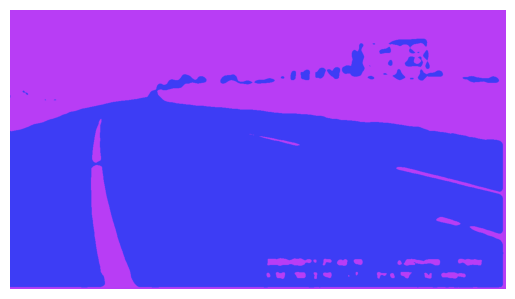

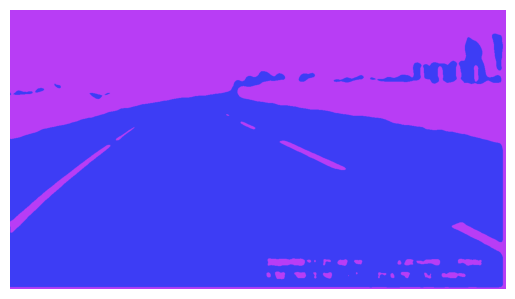

This is epoch 9/20, step 7/8, loss = 0.1993


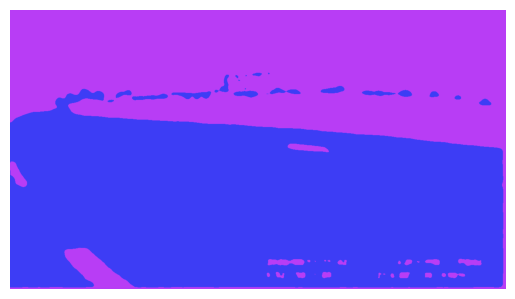

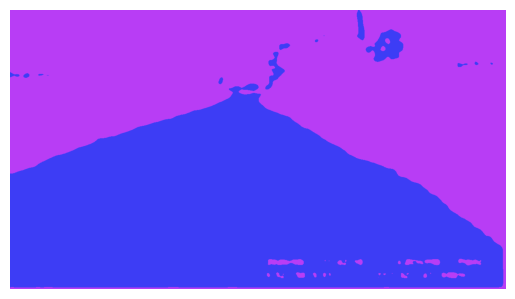

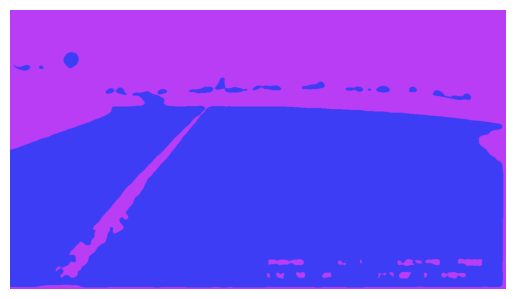

This is epoch 9/20, step 8/8, loss = 0.1795


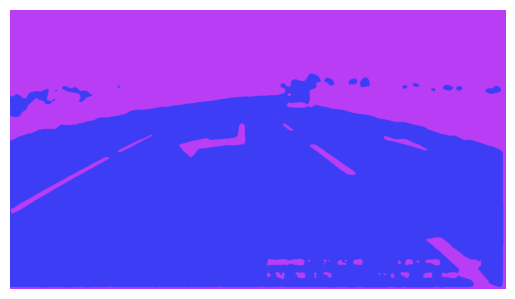

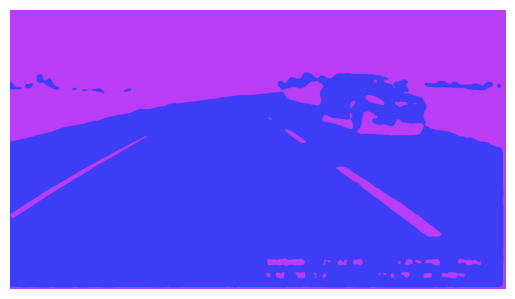

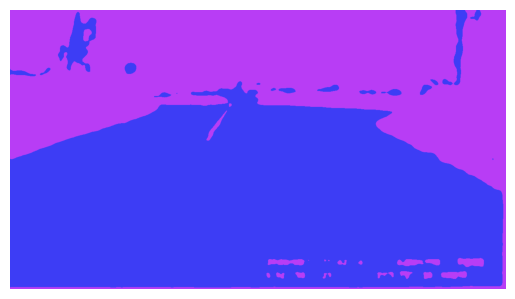

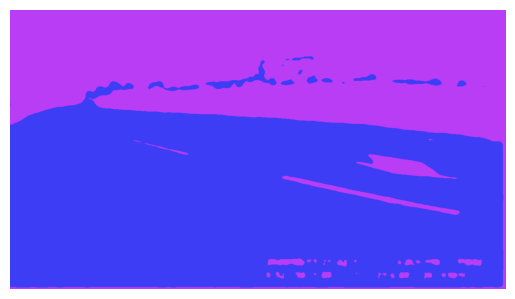

This is epoch 10/20, step 1/8, loss = 0.2445


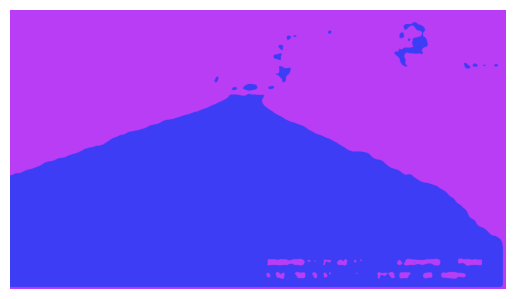

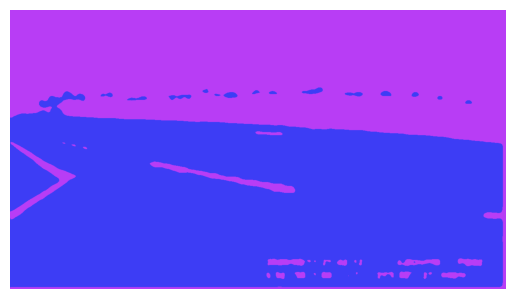

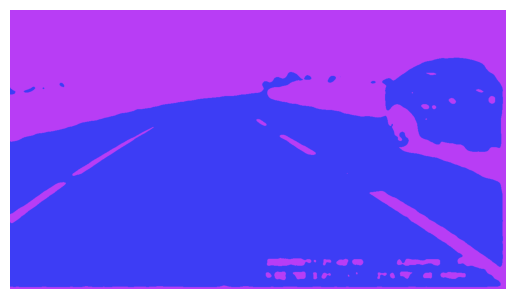

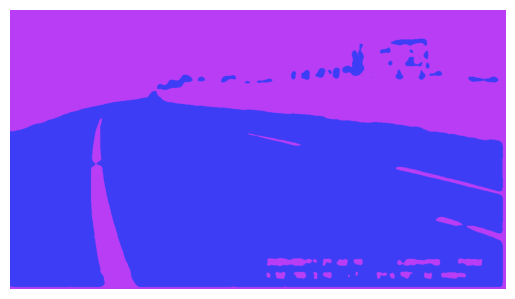

This is epoch 10/20, step 2/8, loss = 0.2665


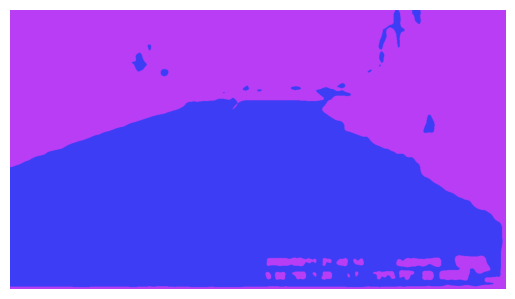

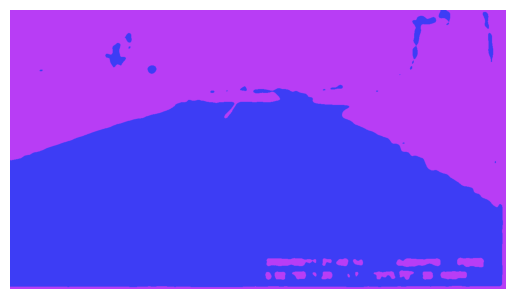

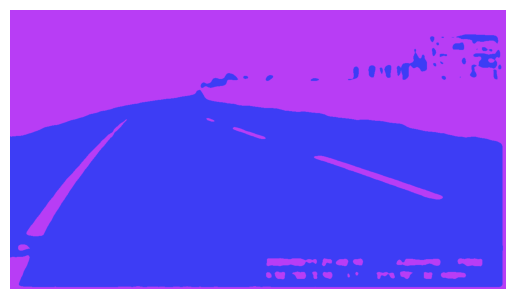

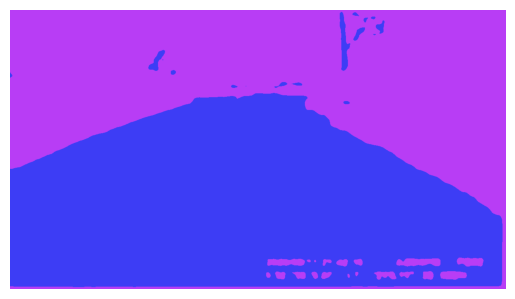

This is epoch 10/20, step 3/8, loss = 0.1696


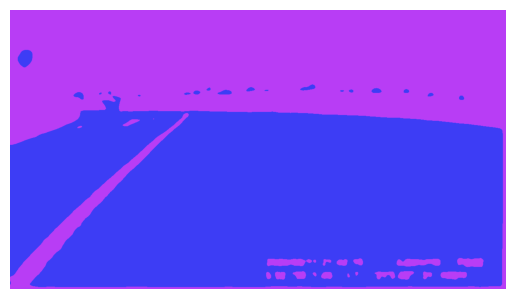

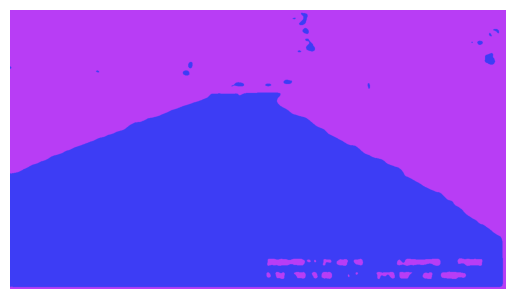

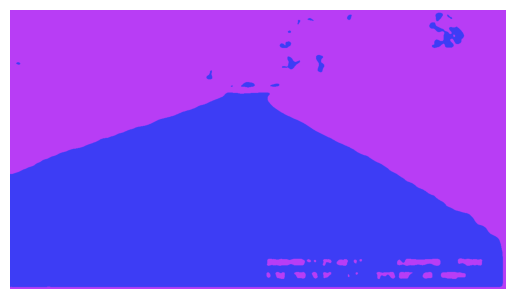

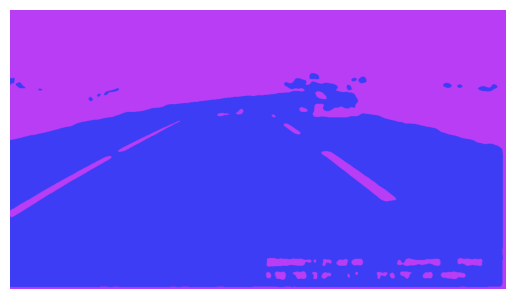

This is epoch 10/20, step 4/8, loss = 0.1540


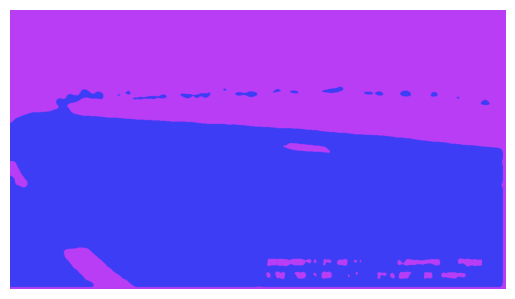

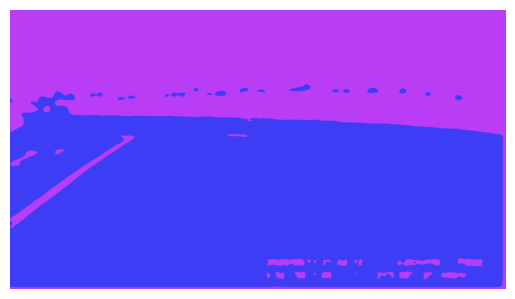

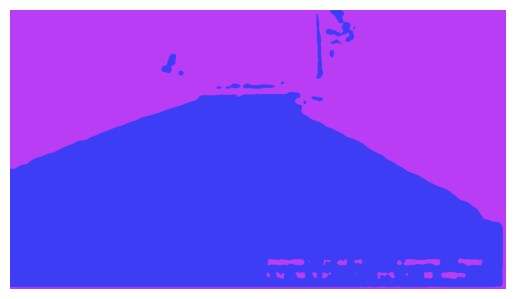

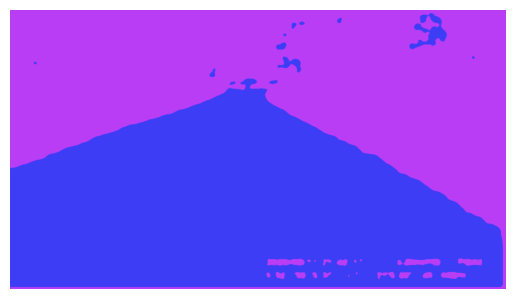

This is epoch 10/20, step 5/8, loss = 0.1411


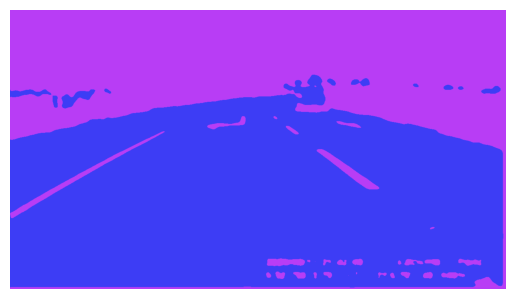

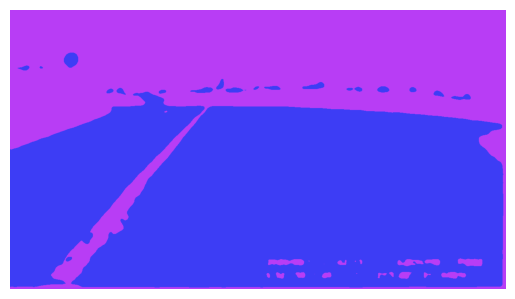

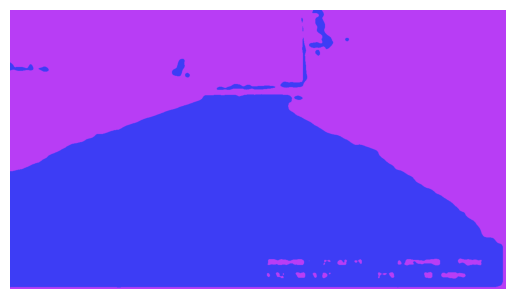

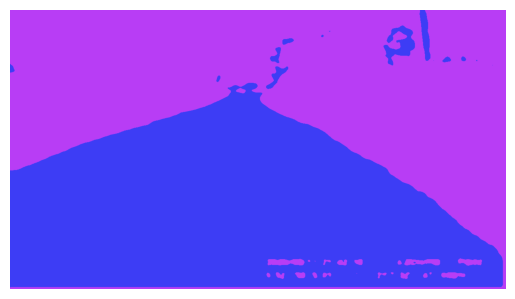

This is epoch 10/20, step 6/8, loss = 0.1417


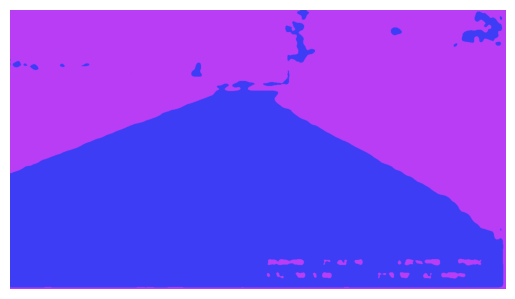

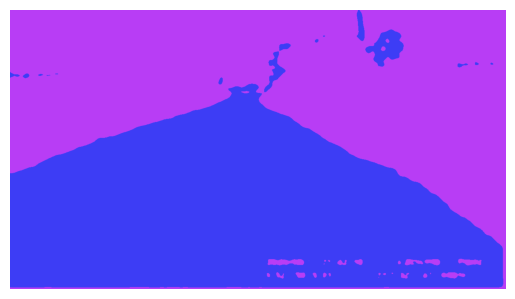

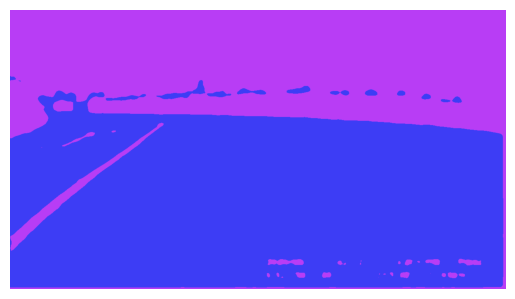

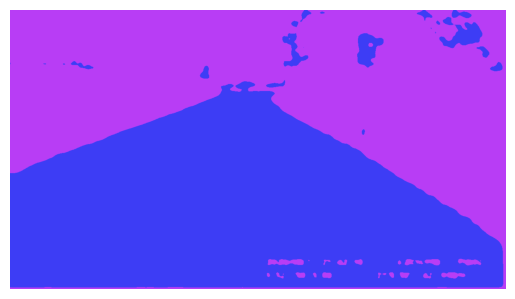

This is epoch 10/20, step 7/8, loss = 0.1165


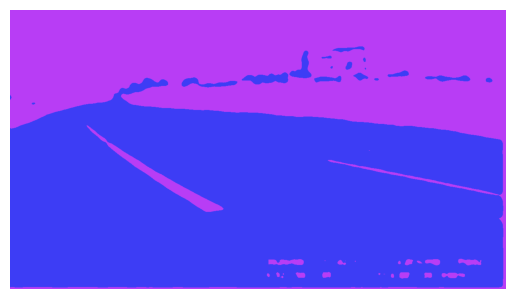

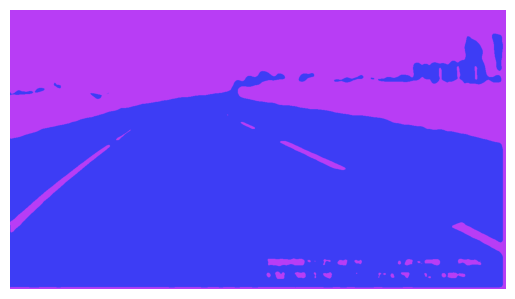

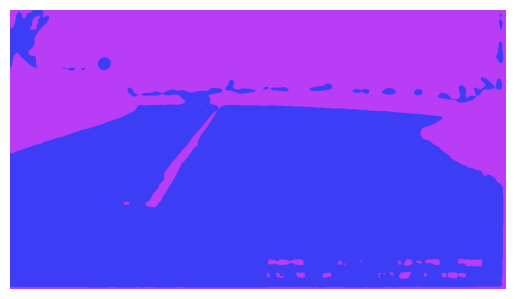

This is epoch 10/20, step 8/8, loss = 0.2007


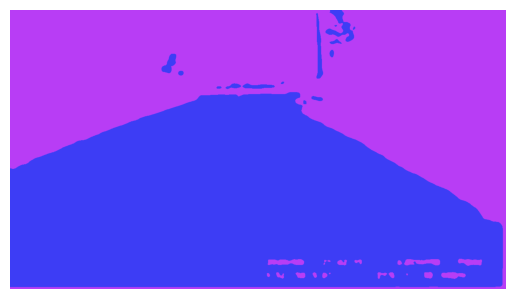

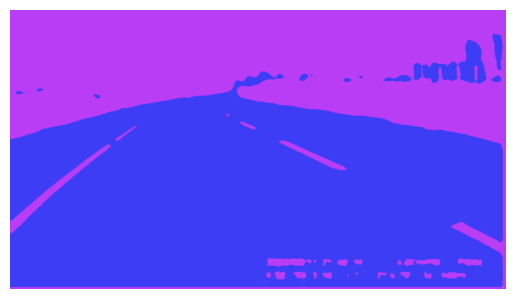

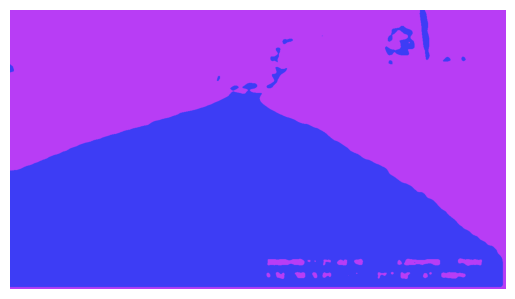

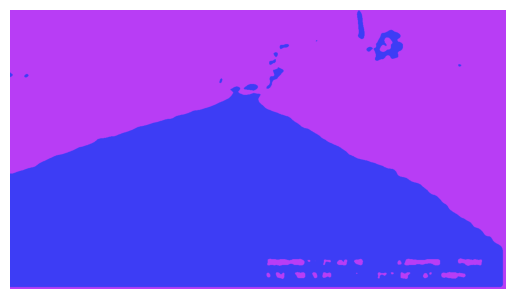

This is epoch 11/20, step 1/8, loss = 0.1058


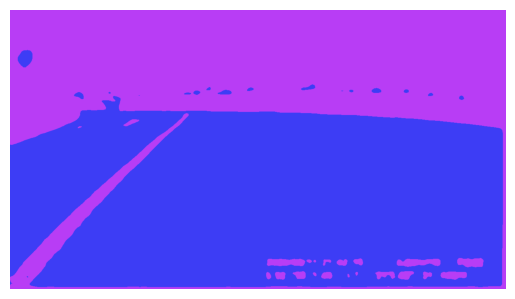

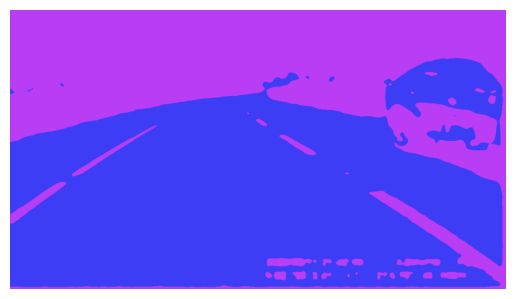

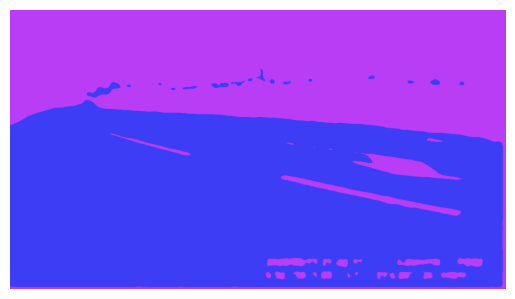

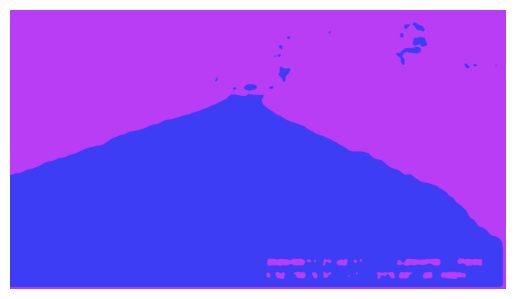

This is epoch 11/20, step 2/8, loss = 0.2525


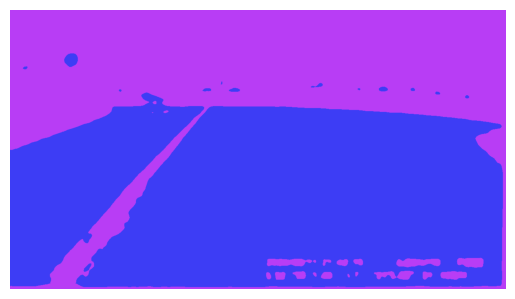

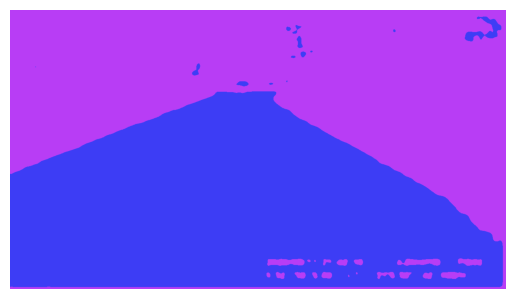

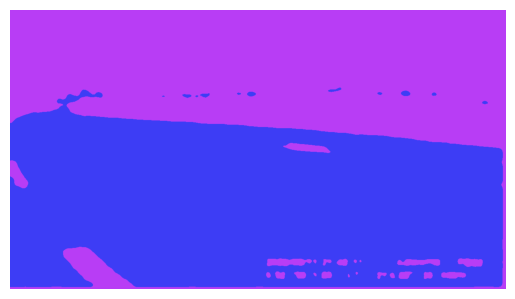

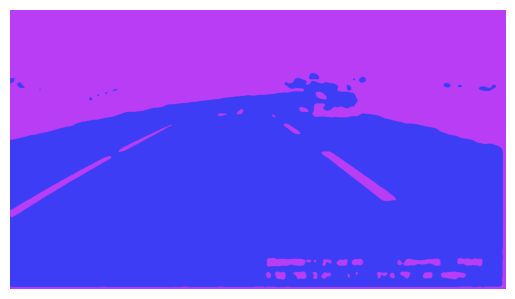

This is epoch 11/20, step 3/8, loss = 0.1824


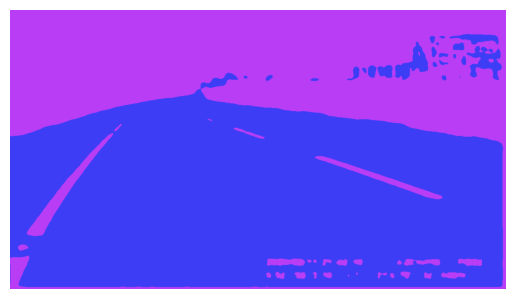

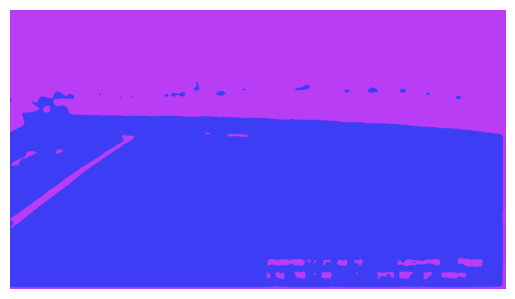

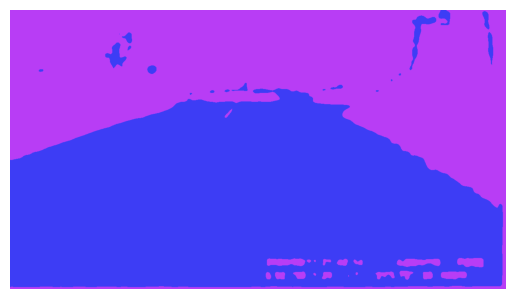

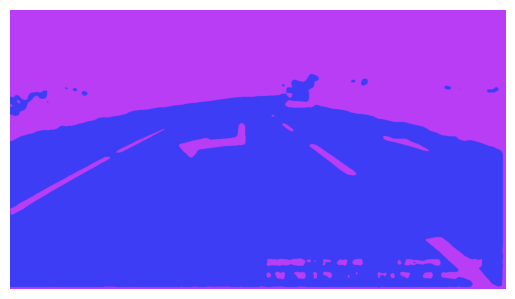

This is epoch 11/20, step 4/8, loss = 0.1973


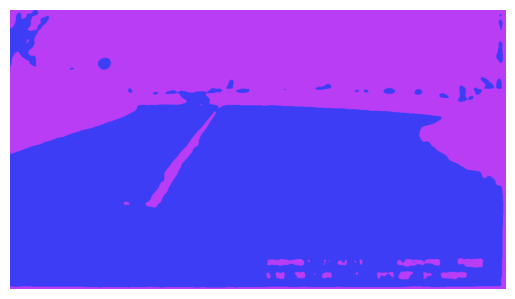

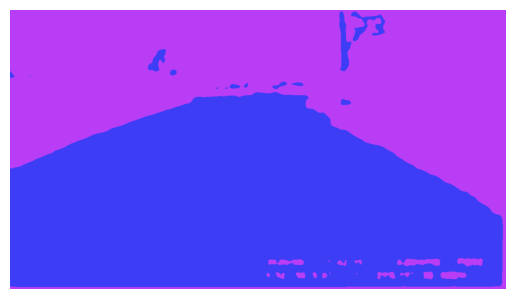

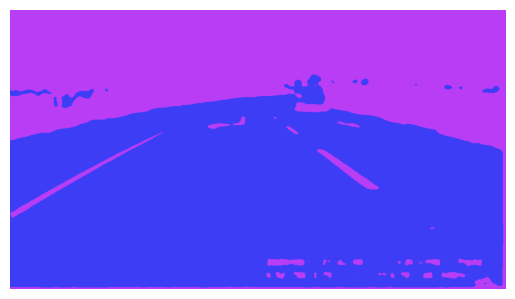

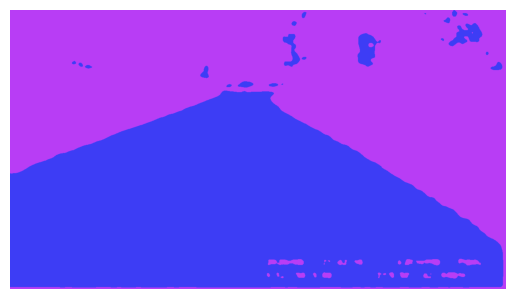

This is epoch 11/20, step 5/8, loss = 0.1316


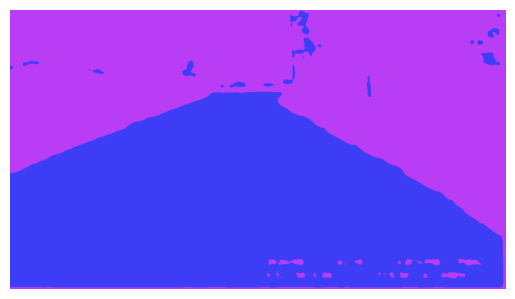

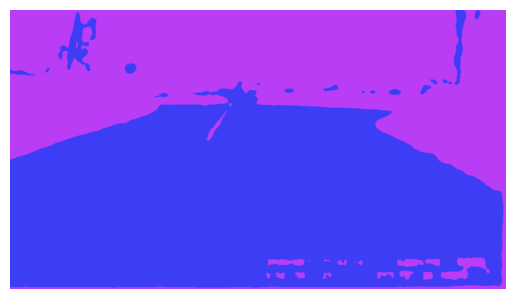

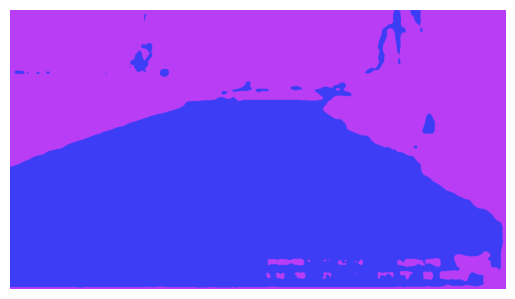

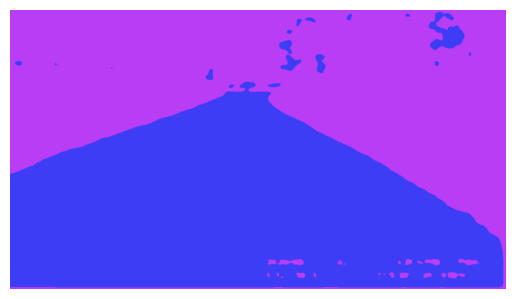

This is epoch 11/20, step 6/8, loss = 0.1191


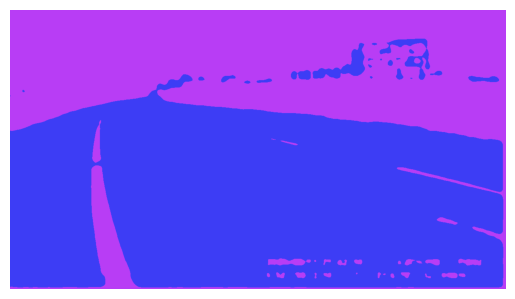

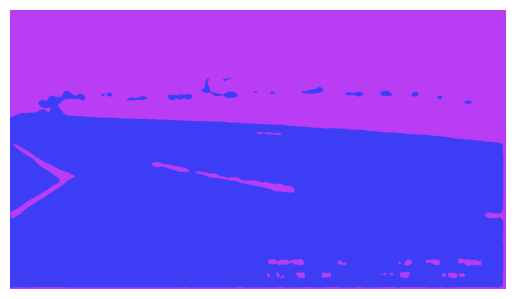

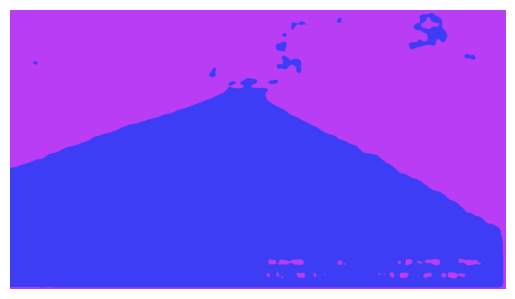

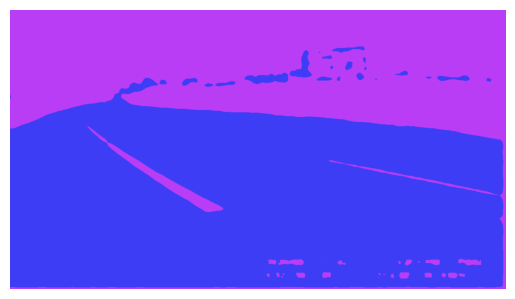

This is epoch 11/20, step 7/8, loss = 0.1888


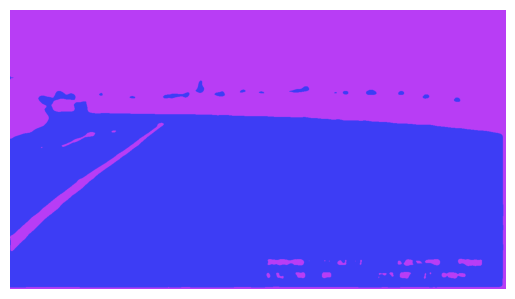

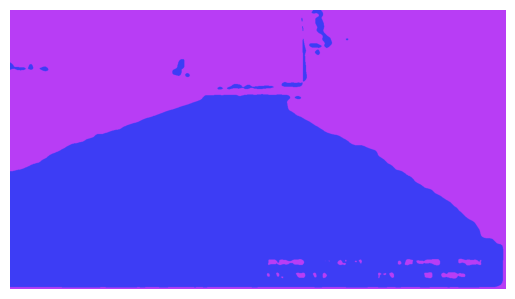

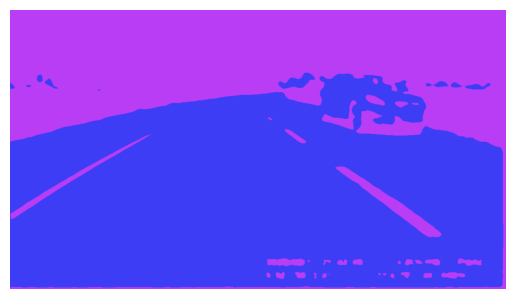

This is epoch 11/20, step 8/8, loss = 0.1862


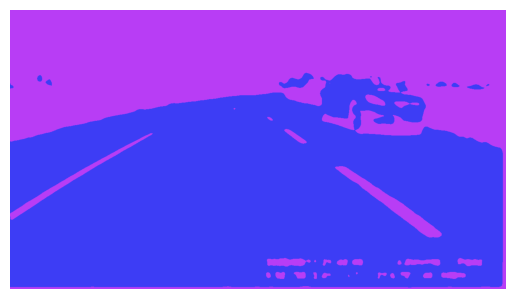

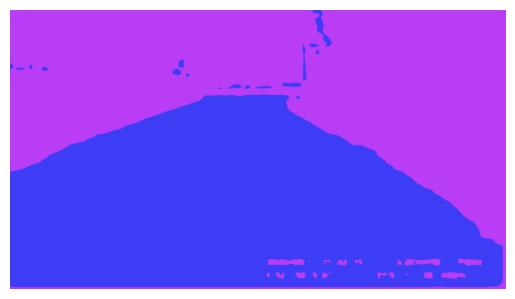

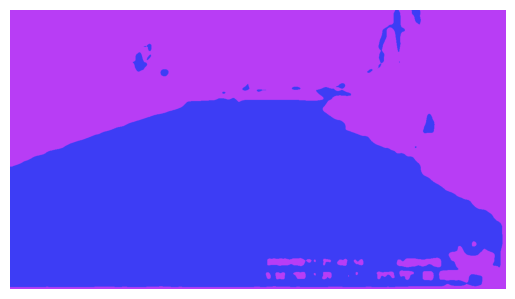

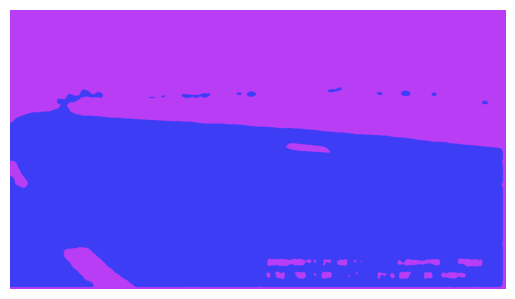

This is epoch 12/20, step 1/8, loss = 0.1901


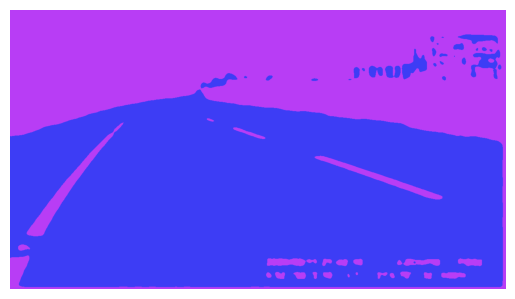

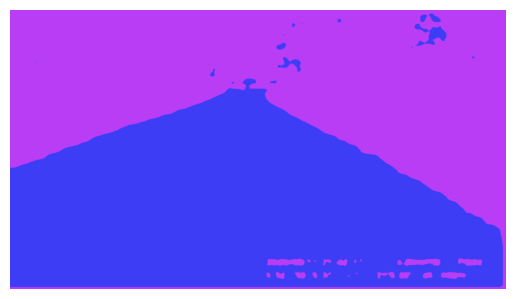

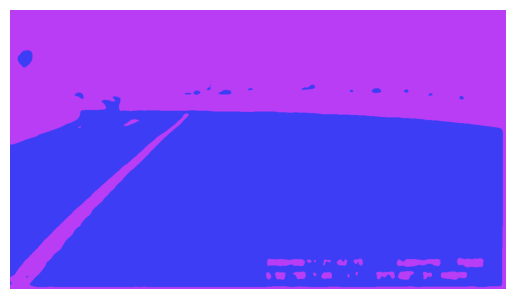

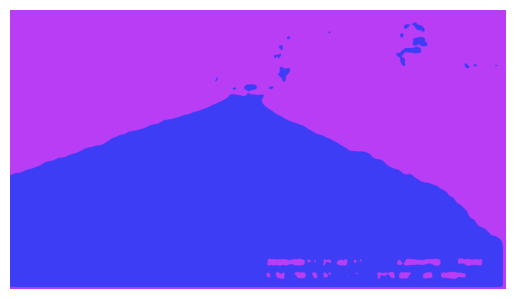

This is epoch 12/20, step 2/8, loss = 0.1461


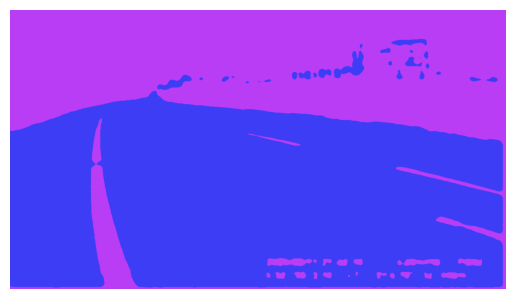

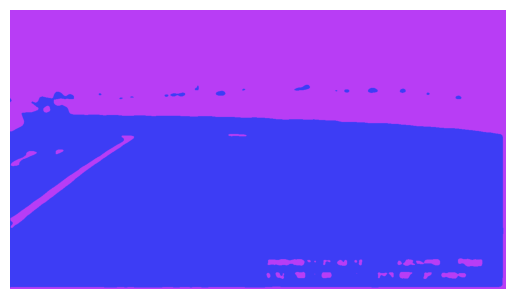

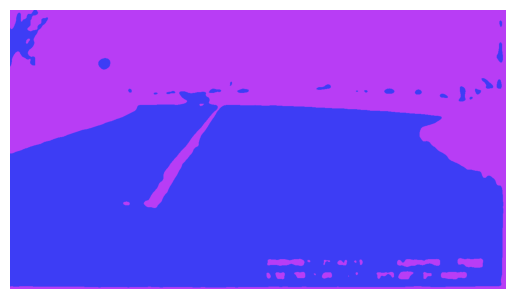

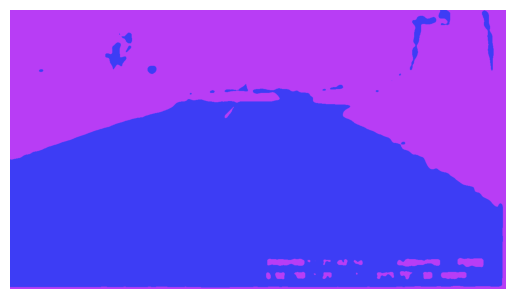

This is epoch 12/20, step 3/8, loss = 0.1832


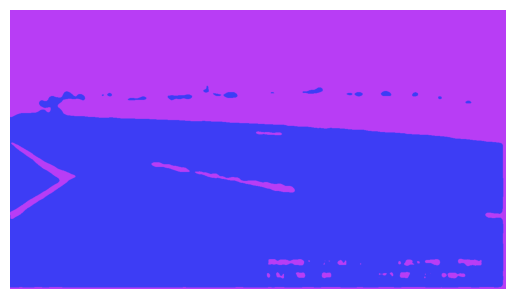

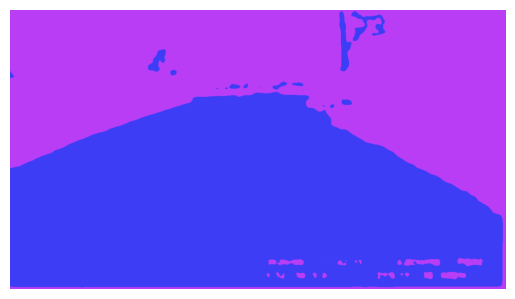

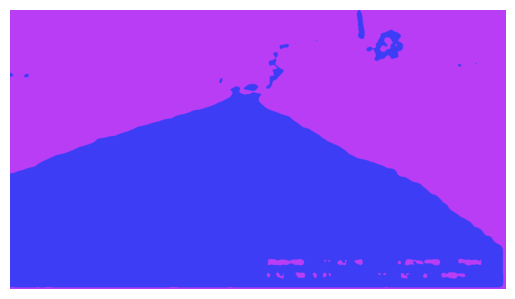

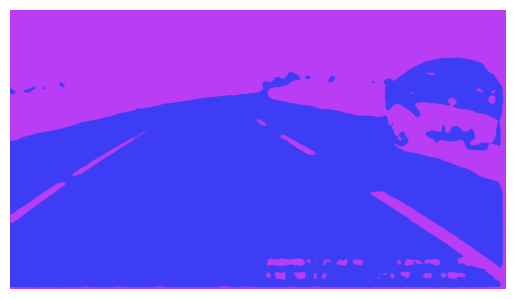

This is epoch 12/20, step 4/8, loss = 0.2045


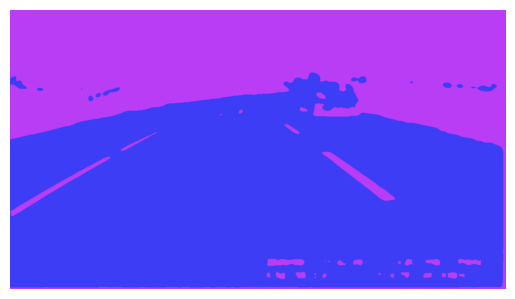

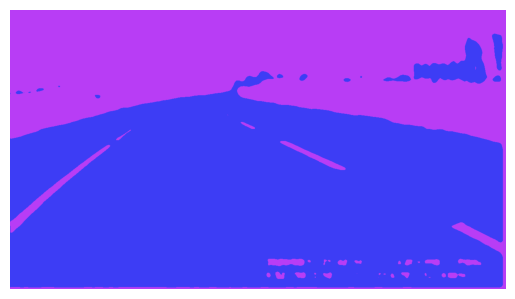

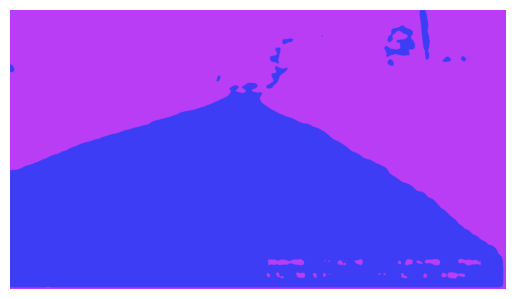

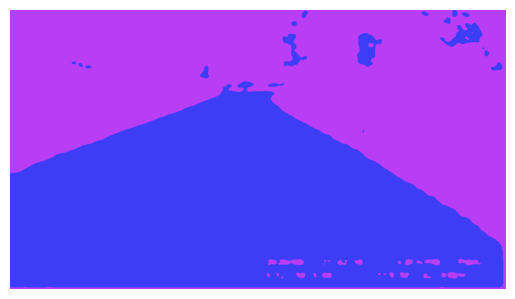

This is epoch 12/20, step 5/8, loss = 0.1405


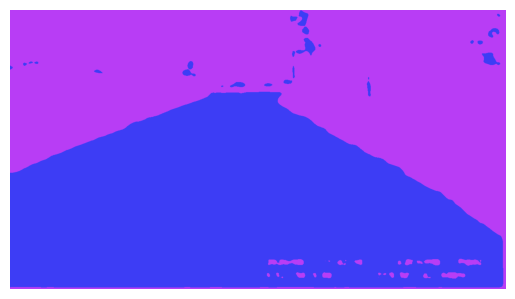

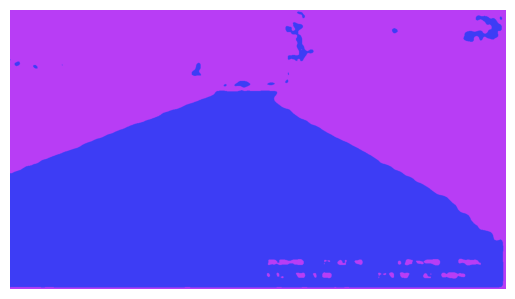

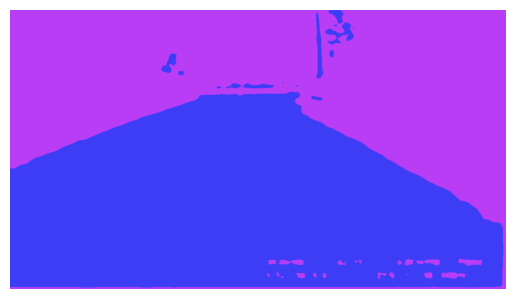

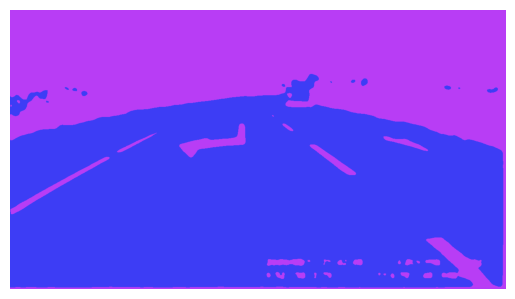

This is epoch 12/20, step 6/8, loss = 0.1093


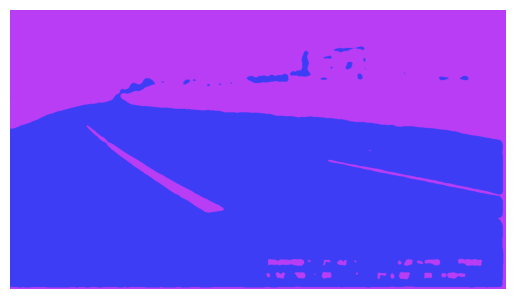

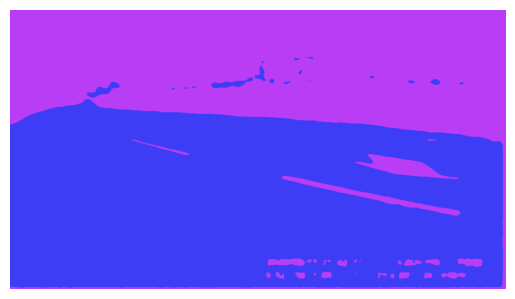

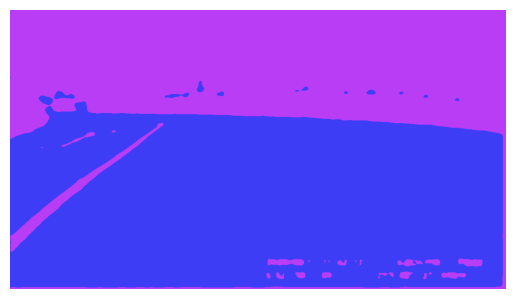

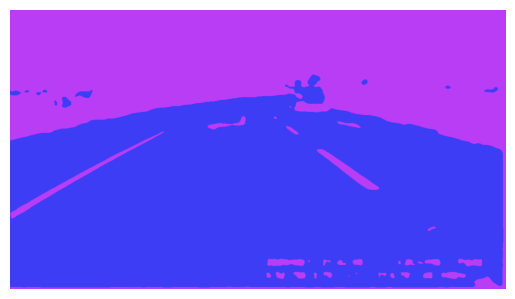

This is epoch 12/20, step 7/8, loss = 0.1962


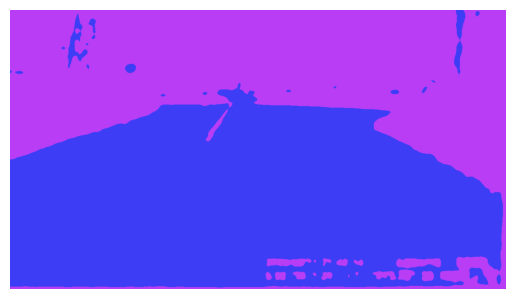

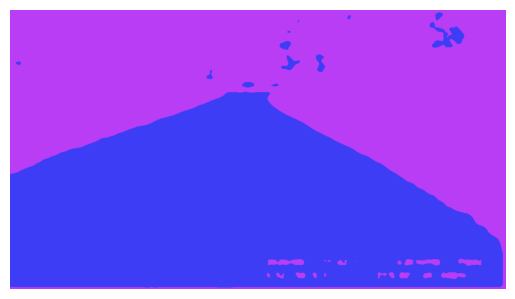

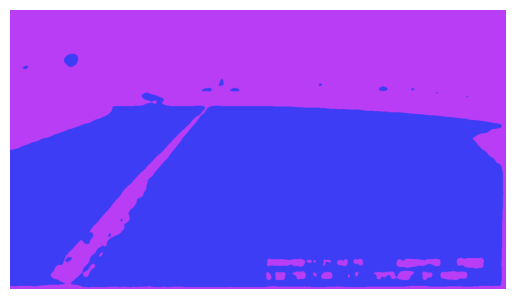

This is epoch 12/20, step 8/8, loss = 0.1573


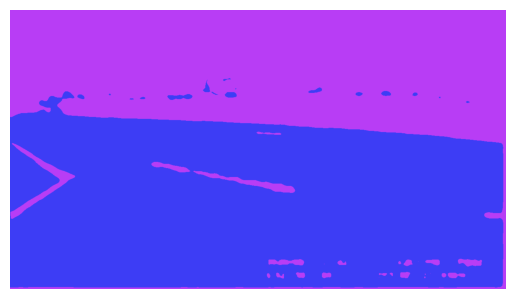

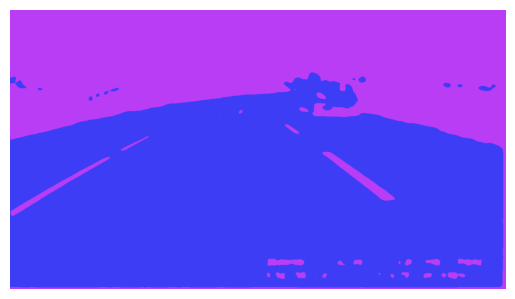

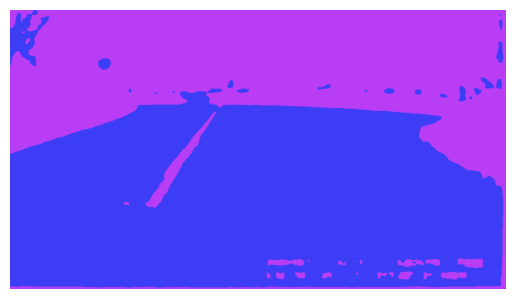

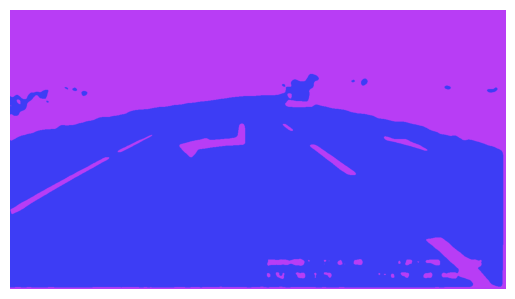

This is epoch 13/20, step 1/8, loss = 0.1886


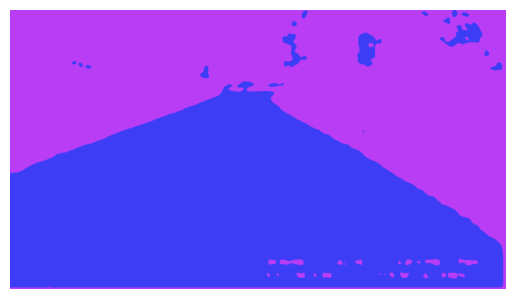

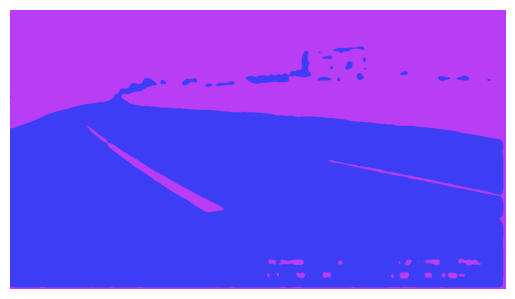

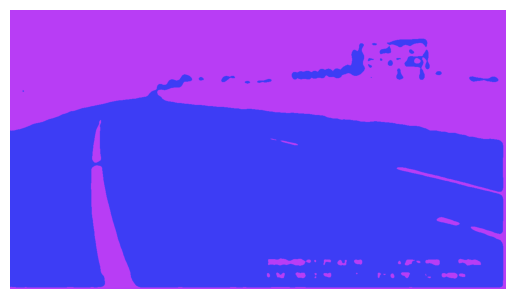

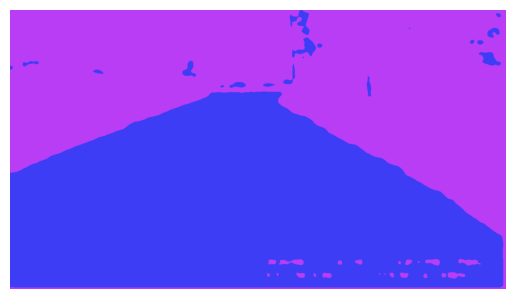

This is epoch 13/20, step 2/8, loss = 0.1608


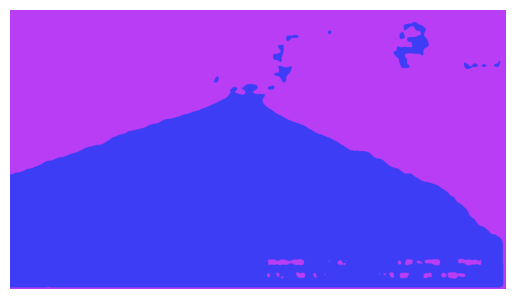

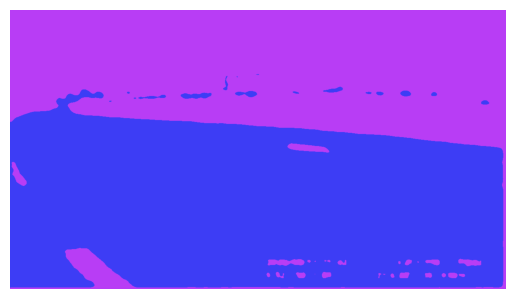

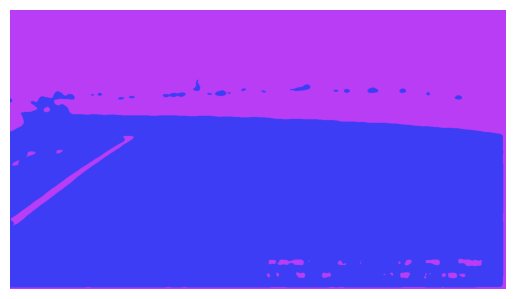

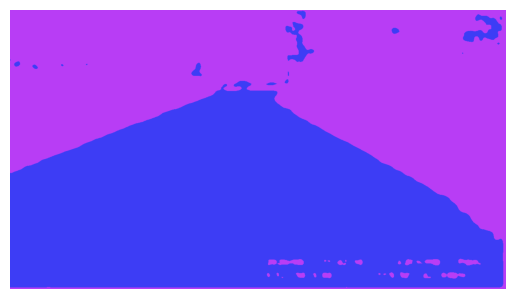

This is epoch 13/20, step 3/8, loss = 0.1326


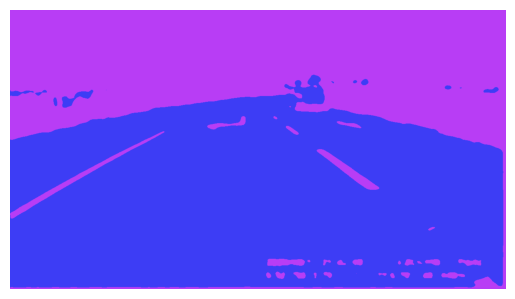

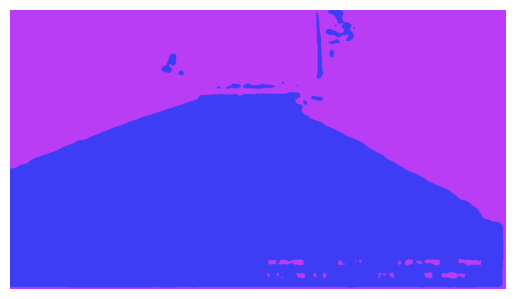

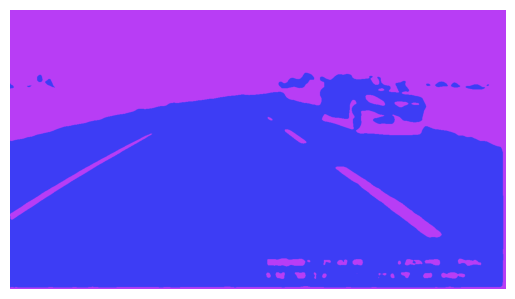

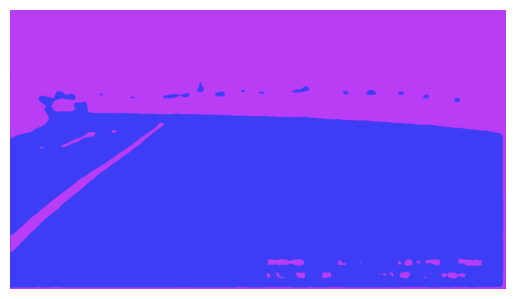

This is epoch 13/20, step 4/8, loss = 0.1801


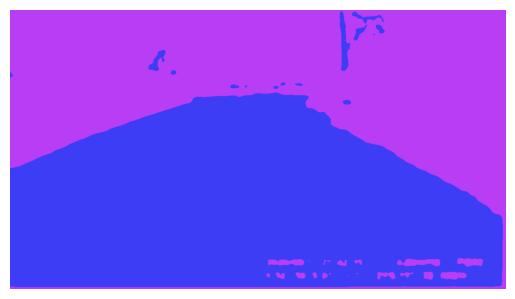

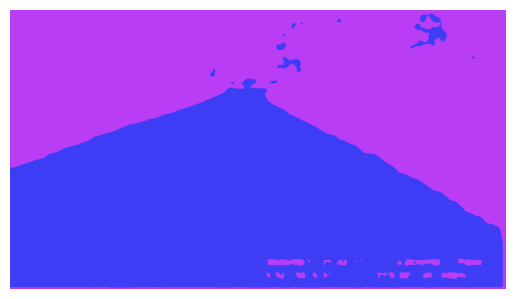

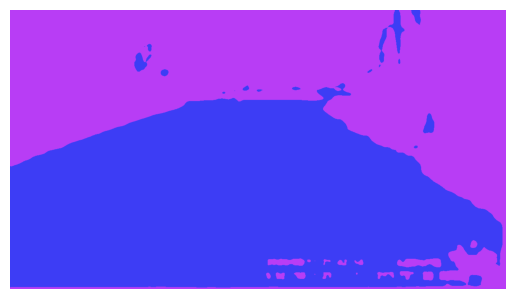

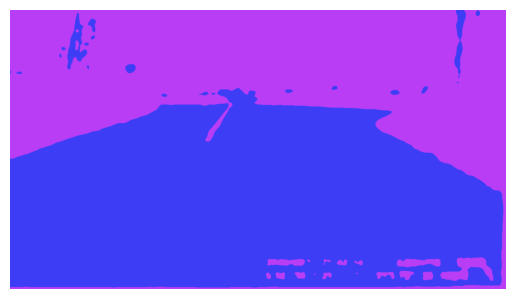

This is epoch 13/20, step 5/8, loss = 0.1123


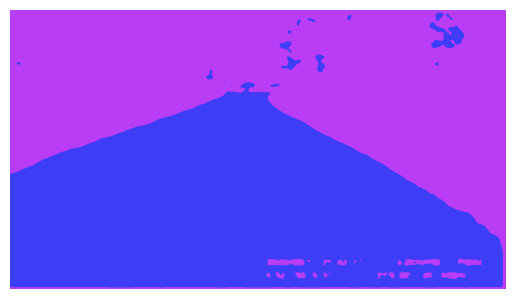

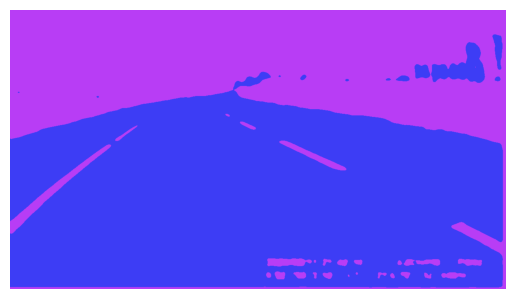

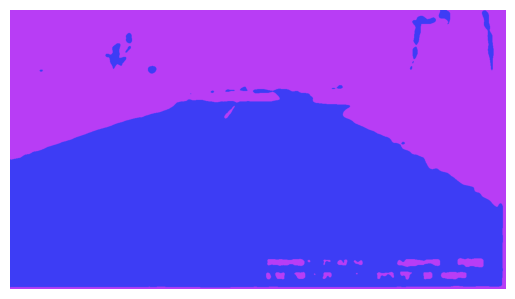

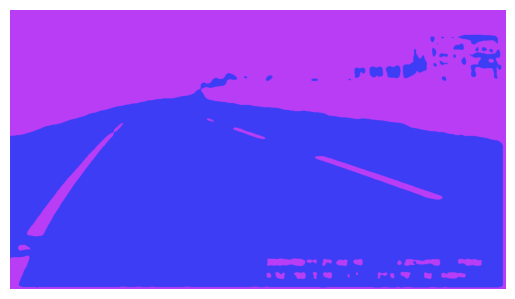

This is epoch 13/20, step 6/8, loss = 0.1588


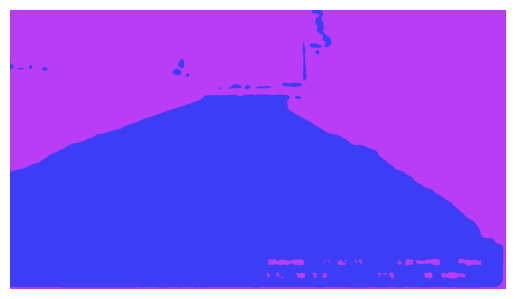

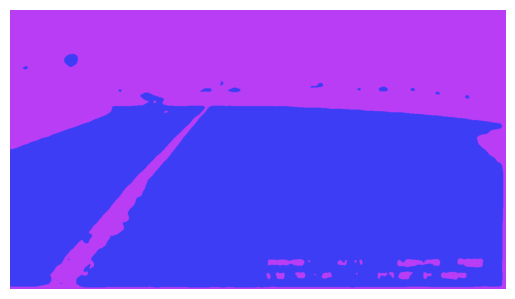

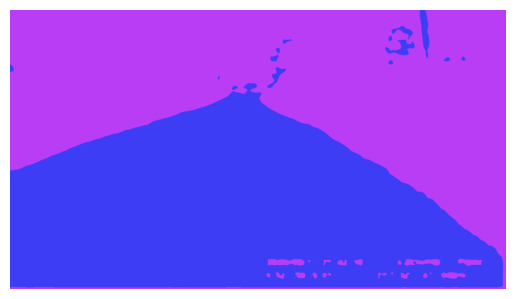

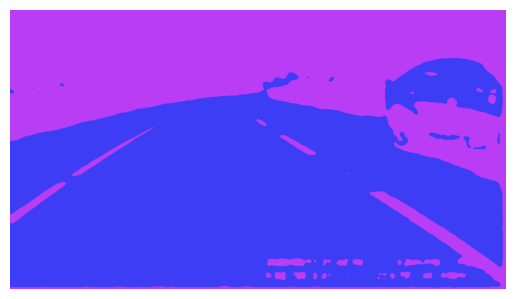

This is epoch 13/20, step 7/8, loss = 0.2046


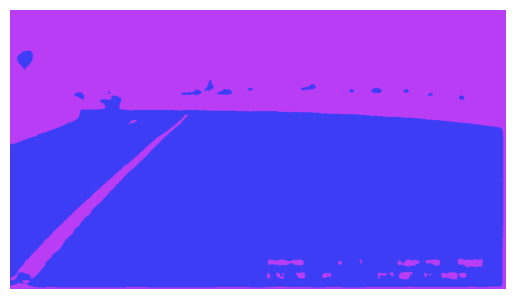

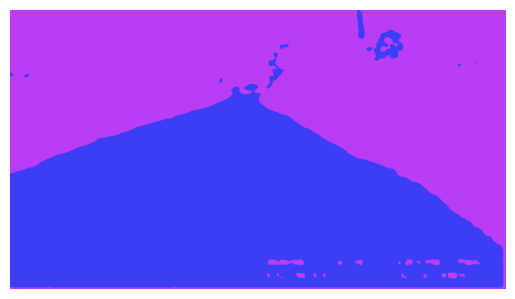

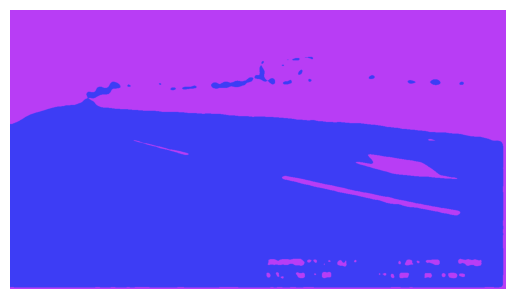

This is epoch 13/20, step 8/8, loss = 0.1527


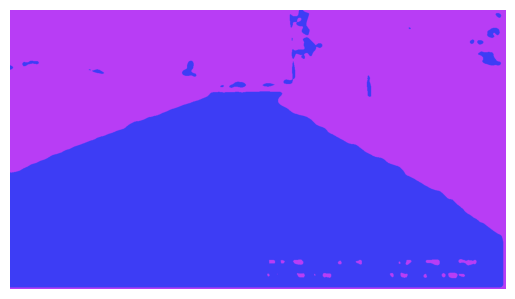

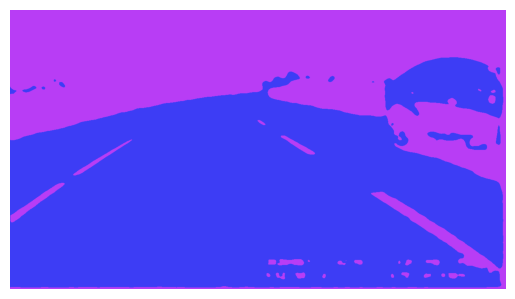

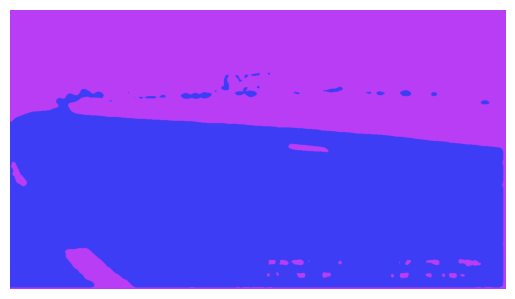

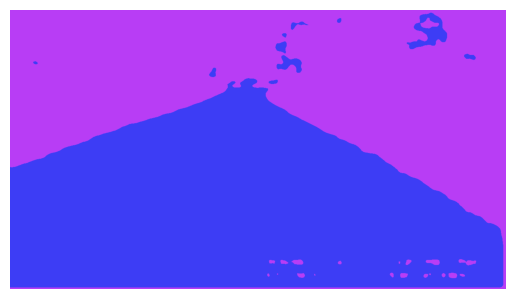

This is epoch 14/20, step 1/8, loss = 0.2066


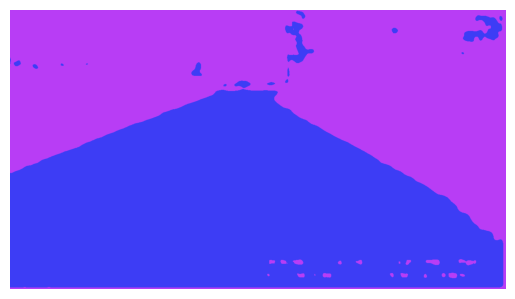

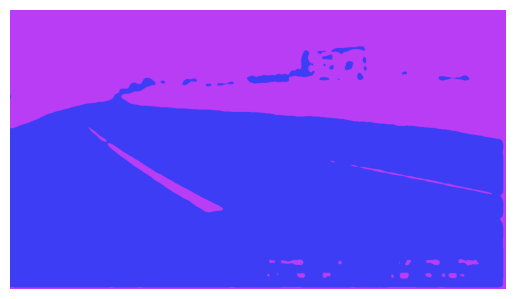

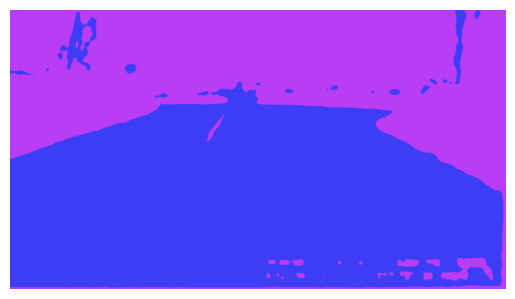

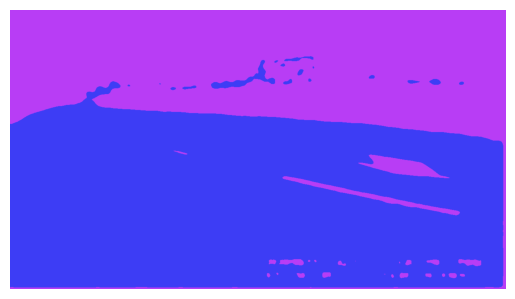

This is epoch 14/20, step 2/8, loss = 0.1593


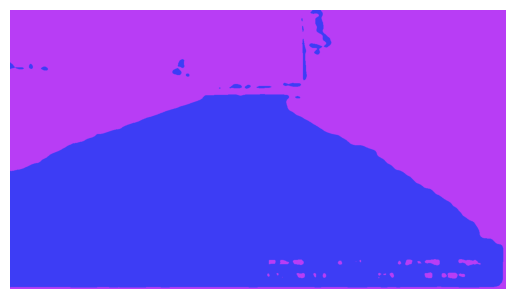

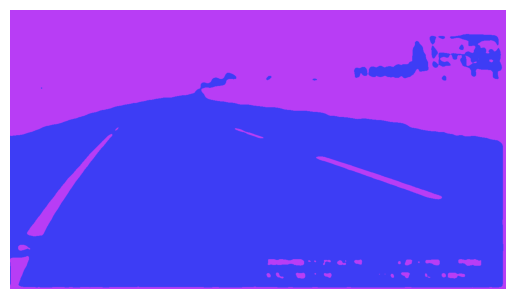

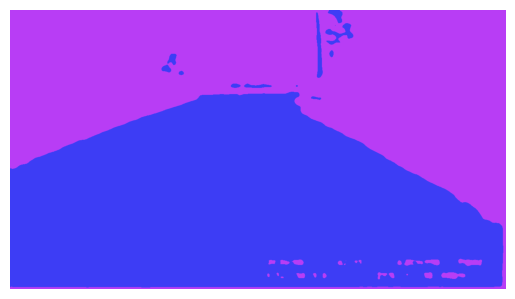

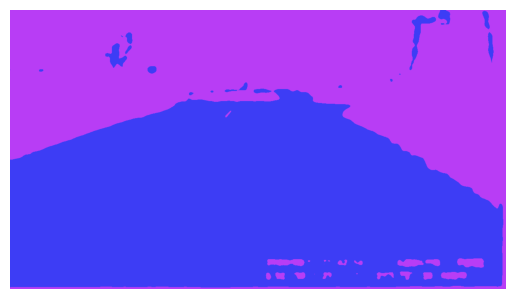

This is epoch 14/20, step 3/8, loss = 0.1208


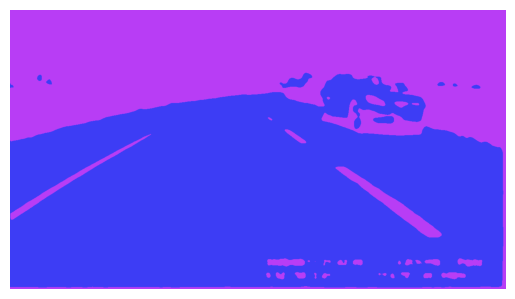

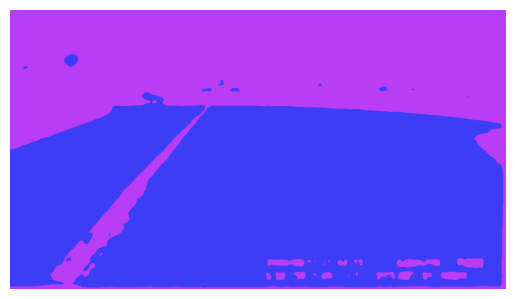

KeyboardInterrupt: 

In [25]:
num_epochs = 20
print("device",device)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # print("images:",images.size())
        # print("labels:",labels.size())
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        predicted_rgb = index_to_rgb(outputs, color_map)
        display_tensor_image(predicted_rgb[0])
        if(len(predicted_rgb)>1):
            display_tensor_image(predicted_rgb[1])
        if(len(predicted_rgb)>2):
            display_tensor_image(predicted_rgb[2])
        if(len(predicted_rgb)>3):
            display_tensor_image(predicted_rgb[3])
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'This is epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
print("Completed !!!!!")

In [20]:
with torch.no_grad():
    num_epochs = 50
    print("device",device)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            print("images:",images.size())
            print("labels:",labels.size())
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            print("outputs:",outputs.size())
            predicted_rgb = index_to_rgb(outputs, color_map)
            display_tensor_image(predicted_rgb[0])
            display_tensor_image(predicted_rgb[1])
            display_tensor_image(predicted_rgb[2])
            display_tensor_image(predicted_rgb[3])
            loss = criterion(outputs, labels)
            print(f'This is epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')
            break;
        break;
    print("Completed !!!!!")

device cuda


KeyboardInterrupt: 

In [15]:
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # fetching the class with the max value out of all the classes, as our output has multiple values i.e, num_classes
        _, predicted = torch.max(outputs, 1)
        n_samples +=labels.shape[0]
        #print(predictions==labels)
        n_correct += (predicted == labels).sum().item()
        for i in range(labels.size(0)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] +=1
            n_class_samples[label] += 1
    acc = 100.0 * n_correct/n_samples
    print(f'accuracy = {acc}')

    for i in range(10):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.4f} seconds")

RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 1